In [1]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, pipeline, TrainingArguments, EarlyStoppingCallback, DataCollatorWithPadding
from transformers import DataCollatorWithPadding, AdamW, BertModel
from torch import nn

from datasets import Dataset
import torch
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Từ điển mở rộng
nltk.download('averaged_perceptron_tagger')  # Nếu bạn dùng POS tagging
nltk.download("popular")
nltk.download('all')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

c:\Users\FPT\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FPT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FPT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\FPT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\FPT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\FPT\AppData\Roaming\n

In [2]:
df = pd.read_csv('D:\Python\Mobile\Dass21\Combined Data.csv\Combined Data.csv', index_col=0)
df.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [3]:
df.dropna(inplace = True)
df.isna().sum()

statement    0
status       0
dtype: int64

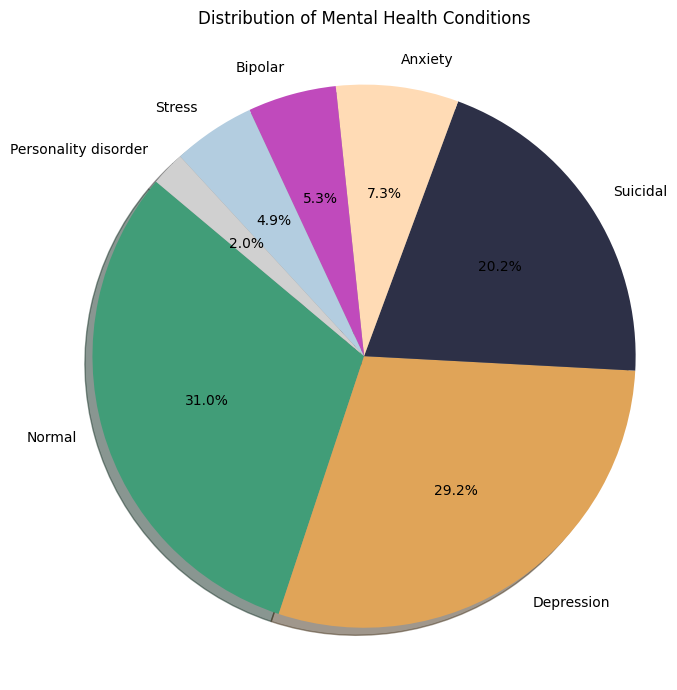

In [4]:
# Count the occurrences of each category
status_counts = df['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

In [5]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: I've had an anxiety-free week and a half and then... I started catastrophising about having a brain tumor. 

All during the holidays I've had a constant fear of having a blood clot, and then that fear went away for a few days and I've felt great. And now I'm having daily headaches on the same spot and I'm so scared I have a brain tumor. I just got blood work done (just normal stuff) so I'm hoping that if I had something it would show up in that..... 

Anyone else have any advice in dealing with thinking i have a brain tumor and how to talk myself out of it 

Status: Bipolar
Statement: I'm at risk of losing my home I'm not throwing a pity party here I just genuinely want to know if other people have done this too. I  have spent so much money over the years racked up a lot of debt. I've only been stable for the past month or so thankfully to lithium, but my monthly expenses are nearly equal to my income. I can no longer afford my home that my family currently r

In [6]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,statement
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,"i'm restless and restless, it's been a month n..."


In [7]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,statement
0,oh my gosh,Anxiety,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless its been a month now ...


In [8]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.head() 

,original_statement,status,statement,tokens
0,oh my gosh,Anxiety,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [ ]:
from transformers import TrainingArguments
from transformers import BertForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional
import torch 
import nltk  # Đảm bảo nltk được import
from nltk.corpus import stopwords  # Import stopwords
# Thêm vào đầu code

torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = True


import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:512'
print(nltk.data.path)

label_mapping = {
    'Personality disorder': 0,
    'Normal': 1,
    'Bipolar': 2,
    'Stress': 3,
    'Depression': 4,
    'Suicidal': 5,
    'Anxiety': 6
}


stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', str(text).lower())
    tokens = word_tokenize(text)
    processed_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(processed_tokens)

df_clean = df[df['status'].isin(label_mapping.keys())]
df_clean['statement'] = df_clean['statement'].apply(preprocess_text)

def split_long_texts(text, tokenizer, max_tokens=512):
    tokens = tokenizer.encode(text)
    if len(tokens) <= max_tokens:
        return [text]
    segments = []
    stride = max_tokens // 2
    start = 0
    while start < len(tokens):
        end = start + max_tokens
        decoded_segment = tokenizer.decode(tokens[start:end], skip_special_tokens=True)
        segments.append(decoded_segment)
        start += stride
    return segments



def augment_text(text, p_dropout=0.1, p_replace=0.1):
    words = text.split()
    
    
    if len(words) <= 3:
        return text
    
    # Tránh lỗi khi số lượng từ nhỏ
    max_dropout = min(int(len(words) * p_dropout), len(words) - 1)
    
    if max_dropout > 0:
        # Sử dụng random.sample để chọn các từ bị loại bỏ
        dropout_idx = random.sample(range(len(words)), max_dropout)
        augmented_words = [word for i, word in enumerate(words) if i not in dropout_idx]
    else:
        augmented_words = words
    
    return ' '.join(augmented_words)


train_df, temp_df = train_test_split(df_clean, test_size=0.4, stratify=df_clean['status'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['status'], random_state=42)

train_dataset = Dataset.from_pandas(train_df[['statement', 'status']])
val_dataset = Dataset.from_pandas(val_df[['statement', 'status']])
test_dataset = Dataset.from_pandas(test_df[['statement', 'status']])


tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-mini')


class BertContrastive(nn.Module):
    def __init__(self, num_labels, dropout, temperature):
        super(BertContrastive, self).__init__()
        self.temperature = temperature
         # self.l2_reg = l2_reg
        self.epoch_progress = 0.0  
        self.bert = BertModel.from_pretrained('prajjwal1/bert-mini', output_hidden_states=False)
        self.dropout = nn.Dropout(dropout)
        self.num_labels = num_labels

        self.attention = nn.MultiheadAttention(
            embed_dim=self.bert.config.hidden_size,
            num_heads=8,
            dropout=dropout
        )

        
        self.fusion = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size * 2, self.bert.config.hidden_size),
            nn.LayerNorm(self.bert.config.hidden_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        
        self.proj_head = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LayerNorm(128),
        )

        # Thêm auxiliary classifier
        #self.aux_classifier = nn.Linear(128, num_labels)
        #self.aux_classifier2 = nn.Linear(self.bert.config.hidden_size, num_labels)
        
     #   '''
     #   self.aux_classifier = nn.Sequential(
     #       nn.Linear(128, num_labels),
     ##       nn.Dropout(dropout)
     #   )'''
        
        self.classifier = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(self.bert.config.hidden_size, 256)),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.utils.spectral_norm(nn.Linear(256, num_labels))
        )
    
        # Add spectral normalization
        #self.classifier = nn.utils.spectral_norm(self.classifier)

        # Corrected scale factor initialization
   #     self.scale_factor = nn.Parameter(torch.tensor(0.1))

        self._init_weights()

   # '''
    def _init_weights(self):
        modules = [self.fusion, self.proj_head, self.classifier]
        for module in modules:
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
   
    def contrastive_loss(self, embeddings, labels, margin=0.5):
        sim_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature
        labels = labels.view(-1, 1)
        
        pos_mask = (labels == labels.T).float() - torch.eye(labels.shape[0], 
                                                           device=labels.device)
        neg_mask = (labels != labels.T).float()
        
        # Dynamic margin based on epoch progress
        adaptive_margin = margin * (1 - self.epoch_progress * 0.2)
        
        # Hard negative mining
        neg_sim = sim_matrix * neg_mask
        hardest_negative_per_row = torch.max(neg_sim, dim=1)[0]
        
        # Positive pair loss with margin
        pos_sim = sim_matrix * pos_mask
        pos_sim_avg = pos_sim.sum(dim=1) / (pos_mask.sum(dim=1) + 1e-8)
        
        # Combined loss with dynamic weighting
        loss = torch.mean(torch.clamp(hardest_negative_per_row - pos_sim_avg + adaptive_margin, 
                                    min=0.0))
        return loss    

    def forward(self, input_ids, attention_mask, labels=None, token_type_ids=None, epoch_progress=None):
        # First forward pass
        outputs1 = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output1 = outputs1.last_hidden_state
        pooled_output1 = outputs1.pooler_output
        
        # Second forward pass với dropout khác
        outputs2 = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output2 = outputs2.last_hidden_state
        pooled_output2 = outputs2.pooler_output
        
        # Apply attention và fusion cho cả hai forward pass
        attn_output1, _ = self.attention(
            sequence_output1.transpose(0, 1),
            sequence_output1.transpose(0, 1),
            sequence_output1.transpose(0, 1)
        )
        attn_output1 = attn_output1.transpose(0, 1)
        
        attn_output2, _ = self.attention(
            sequence_output2.transpose(0, 1),
            sequence_output2.transpose(0, 1),
            sequence_output2.transpose(0, 1)
        )
        attn_output2 = attn_output2.transpose(0, 1)
        
        # Fusion features
        fused_output1 = self.fusion(torch.cat([pooled_output1, torch.mean(attn_output1, dim=1)], dim=1))
        fused_output2 = self.fusion(torch.cat([pooled_output2, torch.mean(attn_output2, dim=1)], dim=1))
        
        # Get SimCSE embeddings
        z1 = F.normalize(self.proj_head(fused_output1), dim=1)
        z2 = F.normalize(self.proj_head(fused_output2), dim=1)
        
        # Classification logits từ first forward pass
        logits = self.classifier(self.dropout(fused_output1))
        
        # Tính SimCSE loss nếu có labels
        loss = None
        if labels is not None:
            # Classification loss
            ce_loss = F.cross_entropy(logits, labels)
            
            # SimCSE contrastive loss
            batch_size = input_ids.size(0)
            sim_matrix = torch.matmul(z1, z2.t()) / self.temperature
            sim_targets = torch.arange(batch_size, device=sim_matrix.device)
            simcse_loss = (F.cross_entropy(sim_matrix, sim_targets) + 
                          F.cross_entropy(sim_matrix.t(), sim_targets)) / 2
            
            # Combine losses with weights
            alpha = 0.8 - 0.2 * self.epoch_progress  # Gradually decrease classification weight
            beta = 1 - alpha  # Increase contrastive weight
            loss = alpha * ce_loss + beta * simcse_loss
        
        return transformers.modeling_outputs.SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs1.hidden_states,
            attentions=outputs1.attentions
        )

    
    def set_epoch_progress(self, progress):
        self.epoch_progress = float(progress)
        self.temperature = max(0.03, 0.07 * (1 - progress))
        

# Data Processing
def tokenize_and_split_function(examples):
   
    max_segments = 2  
    
    all_texts = []
    all_labels = []
    
    for text, label in zip(examples['statement'], examples['status']):
        segments = split_long_texts(text, tokenizer)[:max_segments]
        all_texts.extend(segments)
        all_labels.extend([label] * len(segments))
        
        # Giới hạn augmentation
        if len(segments) > 0:
            aug_text = augment_text(segments[0])
            all_texts.append(aug_text)
            all_labels.append(label)
    
    tokenized = tokenizer(
        all_texts,
        padding='max_length',
        truncation=True,
        max_length=256,  
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    tokenized['labels'] = [label_mapping[label] for label in all_labels]
    return tokenized


# Tokenize datasets
train_tokenized = train_dataset.map(tokenize_and_split_function, remove_columns=train_dataset.column_names, batched=True)
val_tokenized = val_dataset.map(tokenize_and_split_function, remove_columns=val_dataset.column_names, batched=True)
test_tokenized = test_dataset.map(tokenize_and_split_function, remove_columns=test_dataset.column_names, batched=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Compute class weights
labels = [label_mapping[label] for label in train_df['status']]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.FloatTensor(class_weights).to(device)

# Custom trainer với weighted loss
class ContrastiveTrainer(Trainer):
    def _save(self, output_dir: Optional[str] = None, state_dict=None):
        if state_dict is None:
            state_dict = self.model.state_dict()

        #Make all tensors contiguous before saving
        state_dict = {k: v.contiguous() if torch.is_tensor(v) else v
                     for k, v in state_dict.items()}

        super()._save(output_dir, state_dict)

    
    def training_step(self, model, inputs):
        # Giải phóng bộ nhớ cache
        torch.cuda.empty_cache()
        
        # Set epoch progress
        current_epoch = self.state.epoch
        #epoch_progress = current_epoch / self.args.num_train_epochs
        # Kiểm tra và gọi set_epoch_progress thông qua module gốc
        if hasattr(model, 'module'):
            model.module.set_epoch_progress(current_epoch / self.args.num_train_epochs)
        else:
            model.set_epoch_progress(current_epoch / self.args.num_train_epochs)

        #inputs['epoch_progress'] = epoch_progress
        return super().training_step(model, inputs)
        
    def compute_loss(self, model, inputs, return_outputs=False):
        #labels = inputs.get("labels")
        outputs = model(**inputs)

        # Get current epoch progress
        #epoch_progress = model.epoch_progress if hasattr(model, 'epoch_progress') else 0.0
        
        
        ###'''# Đảm bảo loss không None
        if outputs.loss is None:
           loss = F.cross_entropy(outputs.logits, labels)
        else:
            loss = outputs.loss

        # Thêm L2 regularization
        # Progressive L2 weight
        #base_l2 = 0.001  # starting weight
        #max_l2 = 0.005   # maximum weight
        #current_l2 = base_l2 + (max_l2 - base_l2) * epoch_progress
    
        # Calculate L2 penalty
        l2_reg = 0
        for name, param in model.named_parameters():
            if "classifier" in name:
                l2_reg += torch.norm(param, 2)
    
        # Progressive L2 regularization
        epoch_progress = getattr(model, 'epoch_progress', 0.0)
        l2_weight = 0.001 + 0.004 * epoch_progress
        final_loss = loss + l2_weight * l2_reg
        
        return (final_loss, outputs) if return_outputs else final_loss
    
    #def prediction_step(self, model, inputs, prediction_loss_only=False, ignore_keys=None):
     #   with torch.no_grad():
      #      outputs = model(**inputs)
       #     
        #    if prediction_loss_only:
         #       return (outputs.loss, None, None)
          #      
           # return (outputs.loss, outputs.logits, inputs.get("labels"))



# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_contrastive",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.2,
    learning_rate=2e-5,
    lr_scheduler_type="cosine",
    warmup_ratio=0.2,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    report_to="none",
    remove_unused_columns=False,
    dataloader_drop_last=True,
    label_smoothing_factor=0.2,
    gradient_accumulation_steps=4,
    fp16=True,
    max_grad_norm=1.0,  # Changed from gradient_clipping
    save_total_limit=3,  # Limit the number of saved checkpoints
    logging_dir="./logs",
    ddp_find_unused_parameters=False  
)

# Initialize trainer
trainer = ContrastiveTrainer(
    model=BertContrastive(num_labels=7, dropout=0.3, temperature=0.07),
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

['C:\\Users\\FPT/nltk_data', 'c:\\Users\\FPT\\AppData\\Local\\Programs\\Python\\Python310\\nltk_data', 'c:\\Users\\FPT\\AppData\\Local\\Programs\\Python\\Python310\\share\\nltk_data', 'c:\\Users\\FPT\\AppData\\Local\\Programs\\Python\\Python310\\lib\\nltk_data', 'C:\\Users\\FPT\\AppData\\Roaming\\nltk_data', 'C:\\nltk_data', 'D:\\nltk_data', 'E:\\nltk_data']


Map:  16%|█▌        | 5000/31608 [00:24<02:07, 208.16 examples/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Label mapping
label_mapping = {
    'Anxiety': 0,
    'Normal': 1,
    'Depression': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6
}

# Load dataset
def load_data(filepath):
    df = pd.read_csv(filepath)
    df['Emotion'] = df['Emotion'].map(label_mapping)  # Chuyển Emotion thành số
    return df

# Huấn luyện mô hình
def train_model(df):
    X = df['StatementStatement']
    y = df['Status']

    # Chia dữ liệu thành tập train và test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vector hóa văn bản (Bag of Words)
    vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Huấn luyện Multinomial Naive Bayes
    model = MultinomialNB()
    model.fit(X_train_vec, y_train)

    # Đánh giá mô hình
    y_pred = model.predict(X_test_vec)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

    return model, vectorizer

# Phân loại văn bản
def predict_emotion(model, vectorizer, text):
    text_vec = vectorizer.transform([text])
    label = model.predict(text_vec)[0]
    return [key for key, value in label_mapping.items() if value == label][0]

if __name__ == "__main__":
    # Đường dẫn tới file CSV
    filepath = "D:\Python\Mobile\Dass21\Combined Data.csv\Combined Data.csv"

    # Load dữ liệu và huấn luyện mô hình
    data = load_data(filepath)
    model, vectorizer = train_model(data)

    # Thử nghiệm dự đoán
    example_texts = [
        "I feel hopeless and don't want to continue.",
        "I am so stressed with this project!",
        "Today was a pretty normal day.",
        "My mood keeps changing drastically."
    ]

    for text in example_texts:
        emotion = predict_emotion(model, vectorizer, text)
        print(f"Text: \"{text}\" - Predicted Emotion: {emotion}")


Unique labels in 'status': {'Anxiety', 'Normal', 'Personality disorder', 'Stress', 'Depression', 'Bipolar', 'Suicidal'}
Invalid labels found: set()


Map: 100%|██████████| 10537/10537 [00:02<00:00, 4916.89 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-mini and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
                                         
  0%|          | 0/39580 [05:19<?, ?it/s]             

{'loss': 1.9045, 'grad_norm': 6.781533718109131, 'learning_rate': 1.8982536066818528e-08, 'epoch': 0.01}


                                         
  0%|          | 0/39580 [05:41<?, ?it/s]              

{'loss': 1.8964, 'grad_norm': 7.266733646392822, 'learning_rate': 3.7965072133637056e-08, 'epoch': 0.02}


                                         
  0%|          | 0/39580 [06:06<?, ?it/s]              

{'loss': 1.9081, 'grad_norm': 7.532681941986084, 'learning_rate': 5.694760820045559e-08, 'epoch': 0.03}


                                         
  0%|          | 0/39580 [06:27<?, ?it/s]              

{'loss': 1.8962, 'grad_norm': 6.661933422088623, 'learning_rate': 7.593014426727411e-08, 'epoch': 0.04}


                                         
  0%|          | 0/39580 [06:48<?, ?it/s]              

{'loss': 1.9219, 'grad_norm': 4.782284259796143, 'learning_rate': 9.491268033409265e-08, 'epoch': 0.05}


                                         
  0%|          | 0/39580 [07:12<?, ?it/s]              

{'loss': 1.8861, 'grad_norm': 6.672574043273926, 'learning_rate': 1.1389521640091118e-07, 'epoch': 0.06}


                                         
  0%|          | 0/39580 [07:35<?, ?it/s]              

{'loss': 1.9094, 'grad_norm': 6.003439903259277, 'learning_rate': 1.328777524677297e-07, 'epoch': 0.07}


                                         
  0%|          | 0/39580 [07:55<?, ?it/s]              

{'loss': 1.93, 'grad_norm': 6.052431583404541, 'learning_rate': 1.5186028853454822e-07, 'epoch': 0.08}


                                         
  0%|          | 0/39580 [08:17<?, ?it/s]              

{'loss': 1.9126, 'grad_norm': 8.3948392868042, 'learning_rate': 1.7084282460136675e-07, 'epoch': 0.09}


                                         
  0%|          | 0/39580 [08:41<?, ?it/s]              

{'loss': 1.8955, 'grad_norm': 6.39821720123291, 'learning_rate': 1.898253606681853e-07, 'epoch': 0.09}


                                         
  0%|          | 0/39580 [09:04<?, ?it/s]              

{'loss': 1.885, 'grad_norm': 6.71638298034668, 'learning_rate': 2.0880789673500383e-07, 'epoch': 0.1}


                                         
  0%|          | 0/39580 [09:28<?, ?it/s]              

{'loss': 1.8805, 'grad_norm': 5.5600361824035645, 'learning_rate': 2.2779043280182236e-07, 'epoch': 0.11}


                                         
  0%|          | 0/39580 [09:49<?, ?it/s]              

{'loss': 1.8604, 'grad_norm': 8.162986755371094, 'learning_rate': 2.4677296886864086e-07, 'epoch': 0.12}


                                         
  0%|          | 0/39580 [10:13<?, ?it/s]              

{'loss': 1.88, 'grad_norm': 6.437964916229248, 'learning_rate': 2.657555049354594e-07, 'epoch': 0.13}


                                         
  0%|          | 0/39580 [10:36<?, ?it/s]              

{'loss': 1.8939, 'grad_norm': 6.0843186378479, 'learning_rate': 2.847380410022779e-07, 'epoch': 0.14}


                                         
  0%|          | 0/39580 [11:00<?, ?it/s]              

{'loss': 1.8767, 'grad_norm': 6.881246566772461, 'learning_rate': 3.0372057706909645e-07, 'epoch': 0.15}


                                         
  0%|          | 0/39580 [11:22<?, ?it/s]              

{'loss': 1.8718, 'grad_norm': 7.419300556182861, 'learning_rate': 3.22703113135915e-07, 'epoch': 0.16}


                                         
  0%|          | 0/39580 [11:48<?, ?it/s]              

{'loss': 1.8611, 'grad_norm': 5.736841678619385, 'learning_rate': 3.416856492027335e-07, 'epoch': 0.17}


                                         
  0%|          | 0/39580 [12:15<?, ?it/s]              

{'loss': 1.8646, 'grad_norm': 6.552237033843994, 'learning_rate': 3.6066818526955203e-07, 'epoch': 0.18}


                                         
  0%|          | 0/39580 [12:39<?, ?it/s]               

{'loss': 1.8617, 'grad_norm': 7.06653356552124, 'learning_rate': 3.796507213363706e-07, 'epoch': 0.19}


                                         
  0%|          | 0/39580 [13:01<?, ?it/s]               

{'loss': 1.8511, 'grad_norm': 6.590609073638916, 'learning_rate': 3.9863325740318914e-07, 'epoch': 0.2}


                                         
  0%|          | 0/39580 [13:23<?, ?it/s]               

{'loss': 1.8463, 'grad_norm': 8.35180950164795, 'learning_rate': 4.1761579347000767e-07, 'epoch': 0.21}


                                         
  0%|          | 0/39580 [13:45<?, ?it/s]               

{'loss': 1.8574, 'grad_norm': 7.201739311218262, 'learning_rate': 4.365983295368262e-07, 'epoch': 0.22}


                                         
  0%|          | 0/39580 [14:07<?, ?it/s]               

{'loss': 1.8475, 'grad_norm': 6.361911773681641, 'learning_rate': 4.555808656036447e-07, 'epoch': 0.23}


                                         
  0%|          | 0/39580 [14:30<?, ?it/s]               

{'loss': 1.8672, 'grad_norm': 8.124828338623047, 'learning_rate': 4.7456340167046325e-07, 'epoch': 0.24}


                                         
  0%|          | 0/39580 [14:54<?, ?it/s]               

{'loss': 1.8176, 'grad_norm': 7.5856804847717285, 'learning_rate': 4.935459377372817e-07, 'epoch': 0.25}


                                         
  0%|          | 0/39580 [15:18<?, ?it/s]               

{'loss': 1.8091, 'grad_norm': 5.980137825012207, 'learning_rate': 5.125284738041003e-07, 'epoch': 0.26}


                                         
  0%|          | 0/39580 [15:42<?, ?it/s]               

{'loss': 1.8369, 'grad_norm': 7.428492069244385, 'learning_rate': 5.315110098709188e-07, 'epoch': 0.27}


                                         
  0%|          | 0/39580 [16:06<?, ?it/s]               

{'loss': 1.8164, 'grad_norm': 6.454822063446045, 'learning_rate': 5.504935459377373e-07, 'epoch': 0.28}


                                         
  0%|          | 0/39580 [16:30<?, ?it/s]               

{'loss': 1.7924, 'grad_norm': 6.958491325378418, 'learning_rate': 5.694760820045558e-07, 'epoch': 0.28}


                                         
  0%|          | 0/39580 [16:55<?, ?it/s]               

{'loss': 1.7821, 'grad_norm': 6.073852062225342, 'learning_rate': 5.884586180713744e-07, 'epoch': 0.29}


                                         
  0%|          | 0/39580 [17:20<?, ?it/s]               

{'loss': 1.8076, 'grad_norm': 6.060319423675537, 'learning_rate': 6.074411541381929e-07, 'epoch': 0.3}


                                         
  0%|          | 0/39580 [17:49<?, ?it/s]               

{'loss': 1.7945, 'grad_norm': 6.922138214111328, 'learning_rate': 6.264236902050115e-07, 'epoch': 0.31}


                                         
  0%|          | 0/39580 [18:15<?, ?it/s]               

{'loss': 1.7946, 'grad_norm': 8.807982444763184, 'learning_rate': 6.4540622627183e-07, 'epoch': 0.32}


                                         
  0%|          | 0/39580 [18:39<?, ?it/s]               

{'loss': 1.7592, 'grad_norm': 8.394856452941895, 'learning_rate': 6.643887623386485e-07, 'epoch': 0.33}


                                         
  0%|          | 0/39580 [19:04<?, ?it/s]               

{'loss': 1.7673, 'grad_norm': 7.335812568664551, 'learning_rate': 6.83371298405467e-07, 'epoch': 0.34}


                                         
  0%|          | 0/39580 [19:28<?, ?it/s]               

{'loss': 1.7621, 'grad_norm': 5.55386209487915, 'learning_rate': 7.023538344722855e-07, 'epoch': 0.35}


                                         
  0%|          | 0/39580 [19:53<?, ?it/s]               

{'loss': 1.7644, 'grad_norm': 6.270002841949463, 'learning_rate': 7.213363705391041e-07, 'epoch': 0.36}


                                         
  0%|          | 0/39580 [20:17<?, ?it/s]               

{'loss': 1.742, 'grad_norm': 6.1040472984313965, 'learning_rate': 7.403189066059226e-07, 'epoch': 0.37}


                                         
  0%|          | 0/39580 [20:42<?, ?it/s]               

{'loss': 1.7636, 'grad_norm': 7.086050987243652, 'learning_rate': 7.593014426727412e-07, 'epoch': 0.38}


                                         
  0%|          | 0/39580 [21:06<?, ?it/s]               

{'loss': 1.7136, 'grad_norm': 6.752301216125488, 'learning_rate': 7.782839787395596e-07, 'epoch': 0.39}


                                         
  0%|          | 0/39580 [21:30<?, ?it/s]               

{'loss': 1.7126, 'grad_norm': 7.262324333190918, 'learning_rate': 7.972665148063783e-07, 'epoch': 0.4}


                                         
  0%|          | 0/39580 [21:55<?, ?it/s]               

{'loss': 1.768, 'grad_norm': 6.354671478271484, 'learning_rate': 8.162490508731967e-07, 'epoch': 0.41}


                                         
  0%|          | 0/39580 [22:21<?, ?it/s]               

{'loss': 1.7133, 'grad_norm': 6.536283016204834, 'learning_rate': 8.352315869400153e-07, 'epoch': 0.42}


                                         
  0%|          | 0/39580 [22:49<?, ?it/s]               

{'loss': 1.6628, 'grad_norm': 5.915724277496338, 'learning_rate': 8.542141230068338e-07, 'epoch': 0.43}


                                         
  0%|          | 0/39580 [23:17<?, ?it/s]               

{'loss': 1.6854, 'grad_norm': 6.443665981292725, 'learning_rate': 8.731966590736524e-07, 'epoch': 0.44}


                                         
  0%|          | 0/39580 [23:42<?, ?it/s]               

{'loss': 1.6875, 'grad_norm': 6.667612552642822, 'learning_rate': 8.921791951404708e-07, 'epoch': 0.45}


                                         
  0%|          | 0/39580 [24:06<?, ?it/s]               

{'loss': 1.6823, 'grad_norm': 5.933440208435059, 'learning_rate': 9.111617312072894e-07, 'epoch': 0.46}


                                         
  0%|          | 0/39580 [24:30<?, ?it/s]               

{'loss': 1.6848, 'grad_norm': 5.7874932289123535, 'learning_rate': 9.301442672741079e-07, 'epoch': 0.47}


                                         
  0%|          | 0/39580 [24:54<?, ?it/s]               

{'loss': 1.665, 'grad_norm': 6.891671180725098, 'learning_rate': 9.491268033409265e-07, 'epoch': 0.47}


                                         
  0%|          | 0/39580 [25:18<?, ?it/s]               

{'loss': 1.6278, 'grad_norm': 6.06433629989624, 'learning_rate': 9.68109339407745e-07, 'epoch': 0.48}


                                         
  0%|          | 0/39580 [25:45<?, ?it/s]               

{'loss': 1.6393, 'grad_norm': 6.95818567276001, 'learning_rate': 9.870918754745634e-07, 'epoch': 0.49}


                                         
  0%|          | 0/39580 [26:09<?, ?it/s]               

{'loss': 1.6185, 'grad_norm': 6.200324535369873, 'learning_rate': 1.006074411541382e-06, 'epoch': 0.5}


                                         
  0%|          | 0/39580 [26:33<?, ?it/s]               

{'loss': 1.5811, 'grad_norm': 6.010601043701172, 'learning_rate': 1.0250569476082005e-06, 'epoch': 0.51}


                                         
  0%|          | 0/39580 [26:57<?, ?it/s]               

{'loss': 1.599, 'grad_norm': 8.4634428024292, 'learning_rate': 1.044039483675019e-06, 'epoch': 0.52}


                                         
  0%|          | 0/39580 [27:21<?, ?it/s]               

{'loss': 1.6122, 'grad_norm': 5.99493408203125, 'learning_rate': 1.0630220197418376e-06, 'epoch': 0.53}


                                         
  0%|          | 0/39580 [27:46<?, ?it/s]               

{'loss': 1.6236, 'grad_norm': 5.33767032623291, 'learning_rate': 1.082004555808656e-06, 'epoch': 0.54}


                                         
  0%|          | 0/39580 [28:11<?, ?it/s]               

{'loss': 1.604, 'grad_norm': 5.12007999420166, 'learning_rate': 1.1009870918754746e-06, 'epoch': 0.55}


                                         
  0%|          | 0/39580 [28:35<?, ?it/s]               

{'loss': 1.6182, 'grad_norm': 6.034331321716309, 'learning_rate': 1.1199696279422931e-06, 'epoch': 0.56}


                                         
  0%|          | 0/39580 [28:59<?, ?it/s]               

{'loss': 1.5432, 'grad_norm': 5.838982582092285, 'learning_rate': 1.1389521640091117e-06, 'epoch': 0.57}


                                         
  0%|          | 0/39580 [29:25<?, ?it/s]               

{'loss': 1.5486, 'grad_norm': 5.8897223472595215, 'learning_rate': 1.1579347000759302e-06, 'epoch': 0.58}


                                         
  0%|          | 0/39580 [29:49<?, ?it/s]               

{'loss': 1.5531, 'grad_norm': 5.698884963989258, 'learning_rate': 1.1769172361427487e-06, 'epoch': 0.59}


                                         
  0%|          | 0/39580 [30:14<?, ?it/s]               

{'loss': 1.526, 'grad_norm': 6.753091335296631, 'learning_rate': 1.1958997722095673e-06, 'epoch': 0.6}


                                         
  0%|          | 0/39580 [30:39<?, ?it/s]               

{'loss': 1.497, 'grad_norm': 5.610910415649414, 'learning_rate': 1.2148823082763858e-06, 'epoch': 0.61}


                                         
  0%|          | 0/39580 [31:04<?, ?it/s]               

{'loss': 1.4717, 'grad_norm': 5.57576847076416, 'learning_rate': 1.2338648443432043e-06, 'epoch': 0.62}


                                         
  0%|          | 0/39580 [31:28<?, ?it/s]               

{'loss': 1.5459, 'grad_norm': 5.431122303009033, 'learning_rate': 1.252847380410023e-06, 'epoch': 0.63}


                                         
  0%|          | 0/39580 [31:53<?, ?it/s]               

{'loss': 1.4849, 'grad_norm': 5.800791263580322, 'learning_rate': 1.2718299164768414e-06, 'epoch': 0.64}


                                         
  0%|          | 0/39580 [32:18<?, ?it/s]               

{'loss': 1.547, 'grad_norm': 6.740391254425049, 'learning_rate': 1.29081245254366e-06, 'epoch': 0.65}


                                         
  0%|          | 0/39580 [32:43<?, ?it/s]               

{'loss': 1.6048, 'grad_norm': 6.926745414733887, 'learning_rate': 1.3097949886104786e-06, 'epoch': 0.65}


                                         
  0%|          | 0/39580 [33:08<?, ?it/s]               

{'loss': 1.5252, 'grad_norm': 6.111976146697998, 'learning_rate': 1.328777524677297e-06, 'epoch': 0.66}


                                         
  0%|          | 0/39580 [33:33<?, ?it/s]               

{'loss': 1.5267, 'grad_norm': 7.135305881500244, 'learning_rate': 1.3477600607441155e-06, 'epoch': 0.67}


                                         
  0%|          | 0/39580 [33:58<?, ?it/s]               

{'loss': 1.4807, 'grad_norm': 6.208704948425293, 'learning_rate': 1.366742596810934e-06, 'epoch': 0.68}


                                         
  0%|          | 0/39580 [34:22<?, ?it/s]               

{'loss': 1.5276, 'grad_norm': 7.233537673950195, 'learning_rate': 1.3857251328777527e-06, 'epoch': 0.69}


                                         
  0%|          | 0/39580 [34:47<?, ?it/s]               

{'loss': 1.4692, 'grad_norm': 5.419264793395996, 'learning_rate': 1.404707668944571e-06, 'epoch': 0.7}


                                         
  0%|          | 0/39580 [35:12<?, ?it/s]               

{'loss': 1.4666, 'grad_norm': 5.498508453369141, 'learning_rate': 1.4236902050113896e-06, 'epoch': 0.71}


                                         
  0%|          | 0/39580 [35:37<?, ?it/s]               

{'loss': 1.4721, 'grad_norm': 5.954653263092041, 'learning_rate': 1.4426727410782081e-06, 'epoch': 0.72}


                                         
  0%|          | 0/39580 [36:02<?, ?it/s]               

{'loss': 1.4695, 'grad_norm': 5.4256205558776855, 'learning_rate': 1.4616552771450269e-06, 'epoch': 0.73}


                                         
  0%|          | 0/39580 [36:27<?, ?it/s]               

{'loss': 1.498, 'grad_norm': 5.338573932647705, 'learning_rate': 1.4806378132118452e-06, 'epoch': 0.74}


                                         
  0%|          | 0/39580 [36:52<?, ?it/s]               

{'loss': 1.4868, 'grad_norm': 5.638768672943115, 'learning_rate': 1.4996203492786637e-06, 'epoch': 0.75}


                                         
  0%|          | 0/39580 [37:16<?, ?it/s]               

{'loss': 1.4734, 'grad_norm': 6.837031364440918, 'learning_rate': 1.5186028853454824e-06, 'epoch': 0.76}


                                         
  0%|          | 0/39580 [37:42<?, ?it/s]               

{'loss': 1.4525, 'grad_norm': 5.757120609283447, 'learning_rate': 1.537585421412301e-06, 'epoch': 0.77}


                                         
  0%|          | 0/39580 [38:08<?, ?it/s]               

{'loss': 1.4537, 'grad_norm': 4.101736068725586, 'learning_rate': 1.5565679574791193e-06, 'epoch': 0.78}


                                         
  0%|          | 0/39580 [38:33<?, ?it/s]               

{'loss': 1.4402, 'grad_norm': 5.155644416809082, 'learning_rate': 1.5755504935459378e-06, 'epoch': 0.79}


                                         
  0%|          | 0/39580 [38:59<?, ?it/s]               

{'loss': 1.3498, 'grad_norm': 5.0357770919799805, 'learning_rate': 1.5945330296127566e-06, 'epoch': 0.8}


                                         
  0%|          | 0/39580 [39:24<?, ?it/s]               

{'loss': 1.4572, 'grad_norm': 5.147688388824463, 'learning_rate': 1.6135155656795749e-06, 'epoch': 0.81}


                                         
  0%|          | 0/39580 [39:49<?, ?it/s]               

{'loss': 1.4161, 'grad_norm': 8.150679588317871, 'learning_rate': 1.6324981017463934e-06, 'epoch': 0.82}


                                         
  0%|          | 0/39580 [40:15<?, ?it/s]               

{'loss': 1.45, 'grad_norm': 5.87668514251709, 'learning_rate': 1.651480637813212e-06, 'epoch': 0.83}


                                         
  0%|          | 0/39580 [40:39<?, ?it/s]               

{'loss': 1.4432, 'grad_norm': 6.621004104614258, 'learning_rate': 1.6704631738800307e-06, 'epoch': 0.84}


                                         
  0%|          | 0/39580 [41:04<?, ?it/s]               

{'loss': 1.4434, 'grad_norm': 5.4572649002075195, 'learning_rate': 1.689445709946849e-06, 'epoch': 0.84}


                                         
  0%|          | 0/39580 [41:29<?, ?it/s]               

{'loss': 1.4217, 'grad_norm': 5.729280948638916, 'learning_rate': 1.7084282460136675e-06, 'epoch': 0.85}


                                         
  0%|          | 0/39580 [41:54<?, ?it/s]               

{'loss': 1.3319, 'grad_norm': 6.268518447875977, 'learning_rate': 1.727410782080486e-06, 'epoch': 0.86}


                                         
  0%|          | 0/39580 [42:19<?, ?it/s]               

{'loss': 1.4134, 'grad_norm': 5.37209939956665, 'learning_rate': 1.7463933181473048e-06, 'epoch': 0.87}


                                         
  0%|          | 0/39580 [42:44<?, ?it/s]               

{'loss': 1.4411, 'grad_norm': 5.681509494781494, 'learning_rate': 1.765375854214123e-06, 'epoch': 0.88}


                                         
  0%|          | 0/39580 [43:08<?, ?it/s]               

{'loss': 1.3592, 'grad_norm': 5.10499382019043, 'learning_rate': 1.7843583902809416e-06, 'epoch': 0.89}


                                         
  0%|          | 0/39580 [43:34<?, ?it/s]               

{'loss': 1.3716, 'grad_norm': 5.10657262802124, 'learning_rate': 1.8033409263477604e-06, 'epoch': 0.9}


                                         
  0%|          | 0/39580 [43:59<?, ?it/s]               

{'loss': 1.3919, 'grad_norm': 5.1439666748046875, 'learning_rate': 1.8223234624145789e-06, 'epoch': 0.91}


                                         
  0%|          | 0/39580 [44:24<?, ?it/s]               

{'loss': 1.3528, 'grad_norm': 6.941906452178955, 'learning_rate': 1.8413059984813972e-06, 'epoch': 0.92}


                                         
  0%|          | 0/39580 [44:49<?, ?it/s]               

{'loss': 1.3679, 'grad_norm': 4.646480560302734, 'learning_rate': 1.8602885345482157e-06, 'epoch': 0.93}


                                         
  0%|          | 0/39580 [45:14<?, ?it/s]               

{'loss': 1.354, 'grad_norm': 4.150309085845947, 'learning_rate': 1.8792710706150345e-06, 'epoch': 0.94}


                                         
  0%|          | 0/39580 [45:39<?, ?it/s]               

{'loss': 1.4323, 'grad_norm': 6.288318157196045, 'learning_rate': 1.898253606681853e-06, 'epoch': 0.95}


                                         
  0%|          | 0/39580 [46:05<?, ?it/s]               

{'loss': 1.3896, 'grad_norm': 5.229976177215576, 'learning_rate': 1.9172361427486713e-06, 'epoch': 0.96}


                                         
  0%|          | 0/39580 [46:30<?, ?it/s]               

{'loss': 1.3476, 'grad_norm': 5.8981852531433105, 'learning_rate': 1.93621867881549e-06, 'epoch': 0.97}


                                         
  0%|          | 0/39580 [46:54<?, ?it/s]               

{'loss': 1.4024, 'grad_norm': 7.595494747161865, 'learning_rate': 1.9552012148823084e-06, 'epoch': 0.98}


                                         
  0%|          | 0/39580 [47:19<?, ?it/s]               

{'loss': 1.3631, 'grad_norm': 7.758345127105713, 'learning_rate': 1.974183750949127e-06, 'epoch': 0.99}


                                         
  0%|          | 0/39580 [47:44<?, ?it/s]               

{'loss': 1.3904, 'grad_norm': 5.87869930267334, 'learning_rate': 1.9931662870159454e-06, 'epoch': 1.0}


{'eval_loss': 1.3035351037979126, 'eval_accuracy': 0.5406662237828604, 'eval_f1': 0.19993373817835974, 'eval_precision': 0.3118988727776137, 'eval_recall': 0.257349917072959, 'eval_runtime': 190.9898, 'eval_samples_per_second': 55.17, 'eval_steps_per_second': 6.901, 'epoch': 1.0}


                                         
  0%|          | 0/39580 [51:20<?, ?it/s]               

{'loss': 1.3635, 'grad_norm': 5.436108112335205, 'learning_rate': 2.012148823082764e-06, 'epoch': 1.01}


                                         
  0%|          | 0/39580 [51:45<?, ?it/s]               

{'loss': 1.3878, 'grad_norm': 6.2826313972473145, 'learning_rate': 2.0311313591495825e-06, 'epoch': 1.02}


                                         
  0%|          | 0/39580 [52:10<?, ?it/s]               

{'loss': 1.3445, 'grad_norm': 5.39915132522583, 'learning_rate': 2.050113895216401e-06, 'epoch': 1.03}


                                         
  0%|          | 0/39580 [52:34<?, ?it/s]               

{'loss': 1.3352, 'grad_norm': 5.8375630378723145, 'learning_rate': 2.0690964312832195e-06, 'epoch': 1.03}


                                         
  0%|          | 0/39580 [52:59<?, ?it/s]               

{'loss': 1.3592, 'grad_norm': 5.015005588531494, 'learning_rate': 2.088078967350038e-06, 'epoch': 1.04}


                                         
  0%|          | 0/39580 [53:24<?, ?it/s]               

{'loss': 1.312, 'grad_norm': 6.2365288734436035, 'learning_rate': 2.1070615034168566e-06, 'epoch': 1.05}


                                         
  0%|          | 0/39580 [53:48<?, ?it/s]               

{'loss': 1.3133, 'grad_norm': 7.182867527008057, 'learning_rate': 2.126044039483675e-06, 'epoch': 1.06}


                                         
  0%|          | 0/39580 [54:13<?, ?it/s]               

{'loss': 1.3833, 'grad_norm': 6.894881248474121, 'learning_rate': 2.1450265755504936e-06, 'epoch': 1.07}


                                         
  0%|          | 0/39580 [54:38<?, ?it/s]               

{'loss': 1.3228, 'grad_norm': 4.371942520141602, 'learning_rate': 2.164009111617312e-06, 'epoch': 1.08}


                                         
  0%|          | 0/39580 [55:03<?, ?it/s]               

{'loss': 1.2974, 'grad_norm': 6.1741943359375, 'learning_rate': 2.1829916476841307e-06, 'epoch': 1.09}


                                         
  0%|          | 0/39580 [55:27<?, ?it/s]               

{'loss': 1.23, 'grad_norm': 6.626845836639404, 'learning_rate': 2.2019741837509492e-06, 'epoch': 1.1}


                                         
  0%|          | 0/39580 [55:51<?, ?it/s]               

{'loss': 1.2712, 'grad_norm': 5.182972431182861, 'learning_rate': 2.2209567198177678e-06, 'epoch': 1.11}


                                         
  0%|          | 0/39580 [56:16<?, ?it/s]               

{'loss': 1.2832, 'grad_norm': 8.018512725830078, 'learning_rate': 2.2399392558845863e-06, 'epoch': 1.12}


                                         
  0%|          | 0/39580 [56:41<?, ?it/s]               

{'loss': 1.3009, 'grad_norm': 5.832951068878174, 'learning_rate': 2.258921791951405e-06, 'epoch': 1.13}


                                         
  0%|          | 0/39580 [57:05<?, ?it/s]               

{'loss': 1.2876, 'grad_norm': 9.562484741210938, 'learning_rate': 2.2779043280182233e-06, 'epoch': 1.14}


                                         
  0%|          | 0/39580 [57:29<?, ?it/s]               

{'loss': 1.2829, 'grad_norm': 4.55044412612915, 'learning_rate': 2.296886864085042e-06, 'epoch': 1.15}


                                         
  0%|          | 0/39580 [57:54<?, ?it/s]               

{'loss': 1.3325, 'grad_norm': 6.148865222930908, 'learning_rate': 2.3158694001518604e-06, 'epoch': 1.16}


                                         
  0%|          | 0/39580 [58:19<?, ?it/s]               

{'loss': 1.2746, 'grad_norm': 5.95477819442749, 'learning_rate': 2.334851936218679e-06, 'epoch': 1.17}


                                         
  0%|          | 0/39580 [58:43<?, ?it/s]               

{'loss': 1.2723, 'grad_norm': 7.444988250732422, 'learning_rate': 2.3538344722854975e-06, 'epoch': 1.18}


                                         
  0%|          | 0/39580 [59:09<?, ?it/s]               

{'loss': 1.3168, 'grad_norm': 4.726620197296143, 'learning_rate': 2.372817008352316e-06, 'epoch': 1.19}


                                         
  0%|          | 0/39580 [59:33<?, ?it/s]               

{'loss': 1.2664, 'grad_norm': 4.022007465362549, 'learning_rate': 2.3917995444191345e-06, 'epoch': 1.2}


                                         
  0%|          | 0/39580 [59:58<?, ?it/s]               

{'loss': 1.304, 'grad_norm': 7.383367538452148, 'learning_rate': 2.410782080485953e-06, 'epoch': 1.21}


                                         
  0%|          | 0/39580 [1:00:23<?, ?it/s]             

{'loss': 1.2088, 'grad_norm': 7.247731685638428, 'learning_rate': 2.4297646165527716e-06, 'epoch': 1.21}


                                           
  0%|          | 0/39580 [1:00:47<?, ?it/s]             

{'loss': 1.2823, 'grad_norm': 6.626587390899658, 'learning_rate': 2.44874715261959e-06, 'epoch': 1.22}


                                           
  0%|          | 0/39580 [1:01:12<?, ?it/s]             

{'loss': 1.2416, 'grad_norm': 5.657367706298828, 'learning_rate': 2.4677296886864086e-06, 'epoch': 1.23}


                                           
  0%|          | 0/39580 [1:01:36<?, ?it/s]             

{'loss': 1.2169, 'grad_norm': 5.688270568847656, 'learning_rate': 2.486712224753227e-06, 'epoch': 1.24}


                                           
  0%|          | 0/39580 [1:02:01<?, ?it/s]             

{'loss': 1.2919, 'grad_norm': 5.919439792633057, 'learning_rate': 2.505694760820046e-06, 'epoch': 1.25}


                                           
  0%|          | 0/39580 [1:02:25<?, ?it/s]             

{'loss': 1.2256, 'grad_norm': 11.849943161010742, 'learning_rate': 2.524677296886864e-06, 'epoch': 1.26}


                                           
  0%|          | 0/39580 [1:02:50<?, ?it/s]             

{'loss': 1.2183, 'grad_norm': 7.510192394256592, 'learning_rate': 2.5436598329536827e-06, 'epoch': 1.27}


                                           
  0%|          | 0/39580 [1:03:14<?, ?it/s]             

{'loss': 1.269, 'grad_norm': 4.747722625732422, 'learning_rate': 2.5626423690205017e-06, 'epoch': 1.28}


                                           
  0%|          | 0/39580 [1:03:39<?, ?it/s]             

{'loss': 1.1963, 'grad_norm': 5.539303302764893, 'learning_rate': 2.58162490508732e-06, 'epoch': 1.29}


                                           
  0%|          | 0/39580 [1:04:03<?, ?it/s]             

{'loss': 1.2793, 'grad_norm': 8.497318267822266, 'learning_rate': 2.6006074411541383e-06, 'epoch': 1.3}


                                           
  0%|          | 0/39580 [1:04:31<?, ?it/s]             

{'loss': 1.1998, 'grad_norm': 4.934028625488281, 'learning_rate': 2.6195899772209573e-06, 'epoch': 1.31}


                                           
  0%|          | 0/39580 [1:04:56<?, ?it/s]             

{'loss': 1.2192, 'grad_norm': 7.271026134490967, 'learning_rate': 2.6385725132877754e-06, 'epoch': 1.32}


                                           
  0%|          | 0/39580 [1:05:21<?, ?it/s]               

{'loss': 1.2457, 'grad_norm': 4.72705602645874, 'learning_rate': 2.657555049354594e-06, 'epoch': 1.33}


                                           
  0%|          | 0/39580 [1:05:45<?, ?it/s]               

{'loss': 1.2299, 'grad_norm': 5.830032825469971, 'learning_rate': 2.6765375854214124e-06, 'epoch': 1.34}


                                           
  0%|          | 0/39580 [1:06:10<?, ?it/s]               

{'loss': 1.3395, 'grad_norm': 8.889971733093262, 'learning_rate': 2.695520121488231e-06, 'epoch': 1.35}


                                           
  0%|          | 0/39580 [1:06:34<?, ?it/s]               

{'loss': 1.2323, 'grad_norm': 8.790315628051758, 'learning_rate': 2.71450265755505e-06, 'epoch': 1.36}


                                           
  0%|          | 0/39580 [1:06:59<?, ?it/s]               

{'loss': 1.2371, 'grad_norm': 8.498093605041504, 'learning_rate': 2.733485193621868e-06, 'epoch': 1.37}


                                           
  0%|          | 0/39580 [1:07:25<?, ?it/s]               

{'loss': 1.2715, 'grad_norm': 7.1971917152404785, 'learning_rate': 2.7524677296886865e-06, 'epoch': 1.38}


                                           
  0%|          | 0/39580 [1:07:51<?, ?it/s]               

{'loss': 1.1283, 'grad_norm': 7.510544776916504, 'learning_rate': 2.7714502657555055e-06, 'epoch': 1.39}


                                           
  0%|          | 0/39580 [1:08:16<?, ?it/s]               

{'loss': 1.195, 'grad_norm': 7.349056720733643, 'learning_rate': 2.7904328018223236e-06, 'epoch': 1.4}


                                           
  0%|          | 0/39580 [1:08:40<?, ?it/s]               

{'loss': 1.199, 'grad_norm': 6.695216655731201, 'learning_rate': 2.809415337889142e-06, 'epoch': 1.4}


                                           
  0%|          | 0/39580 [1:09:05<?, ?it/s]               

{'loss': 1.1474, 'grad_norm': 4.827058792114258, 'learning_rate': 2.828397873955961e-06, 'epoch': 1.41}


                                           
  0%|          | 0/39580 [1:09:30<?, ?it/s]               

{'loss': 1.2232, 'grad_norm': 4.820675373077393, 'learning_rate': 2.847380410022779e-06, 'epoch': 1.42}


                                           
  0%|          | 0/39580 [1:09:54<?, ?it/s]               

{'loss': 1.2519, 'grad_norm': 4.273978233337402, 'learning_rate': 2.8663629460895977e-06, 'epoch': 1.43}


                                           
  0%|          | 0/39580 [1:10:17<?, ?it/s]               

{'loss': 1.1708, 'grad_norm': 8.836321830749512, 'learning_rate': 2.8853454821564162e-06, 'epoch': 1.44}


                                           
  0%|          | 0/39580 [1:10:43<?, ?it/s]               

{'loss': 1.1577, 'grad_norm': 7.872626304626465, 'learning_rate': 2.9043280182232348e-06, 'epoch': 1.45}


                                           
  0%|          | 0/39580 [1:11:08<?, ?it/s]               

{'loss': 1.2186, 'grad_norm': 11.652875900268555, 'learning_rate': 2.9233105542900537e-06, 'epoch': 1.46}


                                           
  0%|          | 0/39580 [1:11:31<?, ?it/s]               

{'loss': 1.1554, 'grad_norm': 7.26560640335083, 'learning_rate': 2.942293090356872e-06, 'epoch': 1.47}


                                           
  0%|          | 0/39580 [1:11:54<?, ?it/s]               

{'loss': 1.2332, 'grad_norm': 4.772738933563232, 'learning_rate': 2.9612756264236903e-06, 'epoch': 1.48}


                                           
  0%|          | 0/39580 [1:12:16<?, ?it/s]               

{'loss': 1.1547, 'grad_norm': 8.238712310791016, 'learning_rate': 2.9802581624905093e-06, 'epoch': 1.49}


                                           
  0%|          | 0/39580 [1:12:39<?, ?it/s]               

{'loss': 1.1491, 'grad_norm': 7.161807060241699, 'learning_rate': 2.9992406985573274e-06, 'epoch': 1.5}


                                           
  0%|          | 0/39580 [1:13:02<?, ?it/s]               

{'loss': 1.2157, 'grad_norm': 9.07370662689209, 'learning_rate': 3.018223234624146e-06, 'epoch': 1.51}


                                           
  0%|          | 0/39580 [1:13:24<?, ?it/s]               

{'loss': 1.1609, 'grad_norm': 10.924820899963379, 'learning_rate': 3.037205770690965e-06, 'epoch': 1.52}


                                           
  0%|          | 0/39580 [1:13:48<?, ?it/s]               

{'loss': 1.1391, 'grad_norm': 9.03322696685791, 'learning_rate': 3.056188306757783e-06, 'epoch': 1.53}


                                           
  0%|          | 0/39580 [1:14:12<?, ?it/s]               

{'loss': 1.1589, 'grad_norm': 9.818289756774902, 'learning_rate': 3.075170842824602e-06, 'epoch': 1.54}


                                           
  0%|          | 0/39580 [1:14:38<?, ?it/s]               

{'loss': 1.103, 'grad_norm': 12.107394218444824, 'learning_rate': 3.09415337889142e-06, 'epoch': 1.55}


                                           
  0%|          | 0/39580 [1:15:03<?, ?it/s]               

{'loss': 1.1712, 'grad_norm': 8.504629135131836, 'learning_rate': 3.1131359149582386e-06, 'epoch': 1.56}


                                           
  0%|          | 0/39580 [1:15:26<?, ?it/s]               

{'loss': 1.134, 'grad_norm': 8.453020095825195, 'learning_rate': 3.1321184510250575e-06, 'epoch': 1.57}


                                           
  0%|          | 0/39580 [1:15:48<?, ?it/s]               

{'loss': 1.1265, 'grad_norm': 10.963301658630371, 'learning_rate': 3.1511009870918756e-06, 'epoch': 1.58}


                                           
  0%|          | 0/39580 [1:16:12<?, ?it/s]               

{'loss': 1.1353, 'grad_norm': 11.298511505126953, 'learning_rate': 3.170083523158694e-06, 'epoch': 1.59}


                                           
  0%|          | 0/39580 [1:16:36<?, ?it/s]               

{'loss': 1.1502, 'grad_norm': 8.937603950500488, 'learning_rate': 3.189066059225513e-06, 'epoch': 1.59}


                                           
  0%|          | 0/39580 [1:16:58<?, ?it/s]               

{'loss': 1.1709, 'grad_norm': 6.993666172027588, 'learning_rate': 3.208048595292331e-06, 'epoch': 1.6}


                                           
  0%|          | 0/39580 [1:17:21<?, ?it/s]               

{'loss': 1.1268, 'grad_norm': 8.333600997924805, 'learning_rate': 3.2270311313591497e-06, 'epoch': 1.61}


                                           
  0%|          | 0/39580 [1:17:44<?, ?it/s]               

{'loss': 1.1556, 'grad_norm': 9.15424919128418, 'learning_rate': 3.2460136674259683e-06, 'epoch': 1.62}


                                           
  0%|          | 0/39580 [1:18:07<?, ?it/s]               

{'loss': 1.1123, 'grad_norm': 17.349645614624023, 'learning_rate': 3.264996203492787e-06, 'epoch': 1.63}


                                           
  0%|          | 0/39580 [1:18:30<?, ?it/s]               

{'loss': 1.1356, 'grad_norm': 8.872285842895508, 'learning_rate': 3.2839787395596057e-06, 'epoch': 1.64}


                                           
  0%|          | 0/39580 [1:18:53<?, ?it/s]               

{'loss': 1.0176, 'grad_norm': 8.16823673248291, 'learning_rate': 3.302961275626424e-06, 'epoch': 1.65}


                                           
  0%|          | 0/39580 [1:19:15<?, ?it/s]               

{'loss': 1.1424, 'grad_norm': 7.7541117668151855, 'learning_rate': 3.3219438116932424e-06, 'epoch': 1.66}


                                           
  0%|          | 0/39580 [1:19:38<?, ?it/s]               

{'loss': 1.1307, 'grad_norm': 6.881016254425049, 'learning_rate': 3.3409263477600613e-06, 'epoch': 1.67}


                                           
  0%|          | 0/39580 [1:20:01<?, ?it/s]               

{'loss': 1.1504, 'grad_norm': 8.083966255187988, 'learning_rate': 3.3599088838268794e-06, 'epoch': 1.68}


                                           
  0%|          | 0/39580 [1:20:24<?, ?it/s]               

{'loss': 1.0736, 'grad_norm': 8.695137023925781, 'learning_rate': 3.378891419893698e-06, 'epoch': 1.69}


                                           
  0%|          | 0/39580 [1:20:46<?, ?it/s]               

{'loss': 1.1542, 'grad_norm': 8.855749130249023, 'learning_rate': 3.397873955960517e-06, 'epoch': 1.7}


                                           
  0%|          | 0/39580 [1:21:09<?, ?it/s]               

{'loss': 1.096, 'grad_norm': 20.272502899169922, 'learning_rate': 3.416856492027335e-06, 'epoch': 1.71}


                                           
  0%|          | 0/39580 [1:21:32<?, ?it/s]               

{'loss': 1.1346, 'grad_norm': 11.040966987609863, 'learning_rate': 3.435839028094154e-06, 'epoch': 1.72}


                                           
  0%|          | 0/39580 [1:21:55<?, ?it/s]               

{'loss': 1.1019, 'grad_norm': 5.113995552062988, 'learning_rate': 3.454821564160972e-06, 'epoch': 1.73}


                                           
  0%|          | 0/39580 [1:22:18<?, ?it/s]               

{'loss': 1.0748, 'grad_norm': 11.643346786499023, 'learning_rate': 3.4738041002277906e-06, 'epoch': 1.74}


                                           
  0%|          | 0/39580 [1:22:40<?, ?it/s]               

{'loss': 1.1142, 'grad_norm': 10.62111759185791, 'learning_rate': 3.4927866362946096e-06, 'epoch': 1.75}


                                           
  0%|          | 0/39580 [1:23:03<?, ?it/s]               

{'loss': 1.0018, 'grad_norm': 8.423551559448242, 'learning_rate': 3.5117691723614277e-06, 'epoch': 1.76}


                                           
  0%|          | 0/39580 [1:23:26<?, ?it/s]               

{'loss': 1.0869, 'grad_norm': 10.693641662597656, 'learning_rate': 3.530751708428246e-06, 'epoch': 1.77}


                                           
  0%|          | 0/39580 [1:23:49<?, ?it/s]               

{'loss': 1.0726, 'grad_norm': 10.273809432983398, 'learning_rate': 3.549734244495065e-06, 'epoch': 1.77}


                                           
  0%|          | 0/39580 [1:24:12<?, ?it/s]               

{'loss': 1.1555, 'grad_norm': 6.998386383056641, 'learning_rate': 3.5687167805618832e-06, 'epoch': 1.78}


                                           
  0%|          | 0/39580 [1:24:35<?, ?it/s]               

{'loss': 1.077, 'grad_norm': 6.818355083465576, 'learning_rate': 3.5876993166287018e-06, 'epoch': 1.79}


                                           
  0%|          | 0/39580 [1:24:57<?, ?it/s]               

{'loss': 1.1372, 'grad_norm': 12.327679634094238, 'learning_rate': 3.6066818526955207e-06, 'epoch': 1.8}


                                           
  0%|          | 0/39580 [1:25:20<?, ?it/s]               

{'loss': 1.088, 'grad_norm': 12.766919136047363, 'learning_rate': 3.625664388762339e-06, 'epoch': 1.81}


                                           
  0%|          | 0/39580 [1:25:43<?, ?it/s]               

{'loss': 1.0675, 'grad_norm': 7.449977397918701, 'learning_rate': 3.6446469248291578e-06, 'epoch': 1.82}


                                           
  0%|          | 0/39580 [1:26:06<?, ?it/s]               

{'loss': 1.1741, 'grad_norm': 11.831316947937012, 'learning_rate': 3.663629460895976e-06, 'epoch': 1.83}


                                           
  0%|          | 0/39580 [1:26:29<?, ?it/s]               

{'loss': 1.0829, 'grad_norm': 15.062392234802246, 'learning_rate': 3.6826119969627944e-06, 'epoch': 1.84}


                                           
  0%|          | 0/39580 [1:26:51<?, ?it/s]               

{'loss': 1.0558, 'grad_norm': 6.773420810699463, 'learning_rate': 3.7015945330296134e-06, 'epoch': 1.85}


                                           
  0%|          | 0/39580 [1:27:14<?, ?it/s]               

{'loss': 1.118, 'grad_norm': 9.245349884033203, 'learning_rate': 3.7205770690964315e-06, 'epoch': 1.86}


                                           
  0%|          | 0/39580 [1:27:36<?, ?it/s]               

{'loss': 0.98, 'grad_norm': 16.190425872802734, 'learning_rate': 3.73955960516325e-06, 'epoch': 1.87}


                                           
  0%|          | 0/39580 [1:27:59<?, ?it/s]               

{'loss': 1.0671, 'grad_norm': 5.989975929260254, 'learning_rate': 3.758542141230069e-06, 'epoch': 1.88}


                                           
  0%|          | 0/39580 [1:28:22<?, ?it/s]               

{'loss': 1.1324, 'grad_norm': 10.689846992492676, 'learning_rate': 3.777524677296887e-06, 'epoch': 1.89}


                                           
  0%|          | 0/39580 [1:28:44<?, ?it/s]                

{'loss': 1.0502, 'grad_norm': 7.839616775512695, 'learning_rate': 3.796507213363706e-06, 'epoch': 1.9}


                                           
  0%|          | 0/39580 [1:29:07<?, ?it/s]                

{'loss': 1.0626, 'grad_norm': 11.228259086608887, 'learning_rate': 3.815489749430524e-06, 'epoch': 1.91}


                                           
  0%|          | 0/39580 [1:29:30<?, ?it/s]                

{'loss': 1.0557, 'grad_norm': 8.731637001037598, 'learning_rate': 3.834472285497343e-06, 'epoch': 1.92}


                                           
  0%|          | 0/39580 [1:29:53<?, ?it/s]                

{'loss': 1.0551, 'grad_norm': 7.369215488433838, 'learning_rate': 3.853454821564161e-06, 'epoch': 1.93}


                                           
  0%|          | 0/39580 [1:30:16<?, ?it/s]                

{'loss': 0.9098, 'grad_norm': 13.776960372924805, 'learning_rate': 3.87243735763098e-06, 'epoch': 1.94}


                                           
  0%|          | 0/39580 [1:30:39<?, ?it/s]                

{'loss': 1.0094, 'grad_norm': 14.922910690307617, 'learning_rate': 3.891419893697798e-06, 'epoch': 1.95}


                                           
  0%|          | 0/39580 [1:31:01<?, ?it/s]                

{'loss': 1.0408, 'grad_norm': 14.49189281463623, 'learning_rate': 3.910402429764617e-06, 'epoch': 1.96}


                                           
  0%|          | 0/39580 [1:31:23<?, ?it/s]                

{'loss': 1.0013, 'grad_norm': 8.074590682983398, 'learning_rate': 3.929384965831435e-06, 'epoch': 1.96}


                                           
  0%|          | 0/39580 [1:31:46<?, ?it/s]                

{'loss': 1.0558, 'grad_norm': 13.741362571716309, 'learning_rate': 3.948367501898254e-06, 'epoch': 1.97}


                                           
  0%|          | 0/39580 [1:32:09<?, ?it/s]                

{'loss': 1.1325, 'grad_norm': 8.54836368560791, 'learning_rate': 3.967350037965072e-06, 'epoch': 1.98}


                                           
  0%|          | 0/39580 [1:32:32<?, ?it/s]                

{'loss': 1.025, 'grad_norm': 8.981844902038574, 'learning_rate': 3.986332574031891e-06, 'epoch': 1.99}


{'eval_loss': 0.9857298731803894, 'eval_accuracy': 0.6111796526525577, 'eval_f1': 0.3383157578598897, 'eval_precision': 0.32815693863098555, 'eval_recall': 0.38700316043361305, 'eval_runtime': 171.5949, 'eval_samples_per_second': 61.406, 'eval_steps_per_second': 7.681, 'epoch': 2.0}


                                           
  0%|          | 0/39580 [1:35:47<?, ?it/s]                

{'loss': 1.0352, 'grad_norm': 8.053272247314453, 'learning_rate': 4.005315110098709e-06, 'epoch': 2.0}


                                           
  0%|          | 0/39580 [1:36:09<?, ?it/s]                

{'loss': 0.9993, 'grad_norm': 6.401072025299072, 'learning_rate': 4.024297646165528e-06, 'epoch': 2.01}


                                           
  0%|          | 0/39580 [1:36:32<?, ?it/s]                

{'loss': 0.9309, 'grad_norm': 8.908872604370117, 'learning_rate': 4.0432801822323464e-06, 'epoch': 2.02}


                                           
  0%|          | 0/39580 [1:36:54<?, ?it/s]                

{'loss': 1.0781, 'grad_norm': 18.409168243408203, 'learning_rate': 4.062262718299165e-06, 'epoch': 2.03}


                                           
  0%|          | 0/39580 [1:37:17<?, ?it/s]                

{'loss': 0.9994, 'grad_norm': 8.006268501281738, 'learning_rate': 4.0812452543659835e-06, 'epoch': 2.04}


                                           
  0%|          | 0/39580 [1:37:40<?, ?it/s]                

{'loss': 0.9454, 'grad_norm': 12.994401931762695, 'learning_rate': 4.100227790432802e-06, 'epoch': 2.05}


                                           
  0%|          | 0/39580 [1:38:03<?, ?it/s]                

{'loss': 0.9682, 'grad_norm': 13.9449462890625, 'learning_rate': 4.1192103264996205e-06, 'epoch': 2.06}


                                           
  0%|          | 0/39580 [1:38:25<?, ?it/s]                

{'loss': 0.9618, 'grad_norm': 10.504644393920898, 'learning_rate': 4.138192862566439e-06, 'epoch': 2.07}


                                           
  0%|          | 0/39580 [1:38:48<?, ?it/s]                

{'loss': 1.0413, 'grad_norm': 15.46628475189209, 'learning_rate': 4.157175398633258e-06, 'epoch': 2.08}


                                           
  0%|          | 0/39580 [1:39:10<?, ?it/s]                

{'loss': 1.0523, 'grad_norm': 18.973779678344727, 'learning_rate': 4.176157934700076e-06, 'epoch': 2.09}


                                           
  0%|          | 0/39580 [1:39:33<?, ?it/s]                

{'loss': 1.0198, 'grad_norm': 13.982255935668945, 'learning_rate': 4.195140470766895e-06, 'epoch': 2.1}


                                           
  0%|          | 0/39580 [1:39:55<?, ?it/s]                

{'loss': 0.9973, 'grad_norm': 5.509376525878906, 'learning_rate': 4.214123006833713e-06, 'epoch': 2.11}


                                           
  0%|          | 0/39580 [1:40:18<?, ?it/s]                

{'loss': 0.9418, 'grad_norm': 6.099702835083008, 'learning_rate': 4.233105542900532e-06, 'epoch': 2.12}


                                           
  0%|          | 0/39580 [1:40:41<?, ?it/s]                

{'loss': 1.0543, 'grad_norm': 22.023571014404297, 'learning_rate': 4.25208807896735e-06, 'epoch': 2.13}


                                           
  0%|          | 0/39580 [1:41:04<?, ?it/s]                

{'loss': 1.0449, 'grad_norm': 13.960505485534668, 'learning_rate': 4.271070615034169e-06, 'epoch': 2.14}


                                           
  0%|          | 0/39580 [1:41:26<?, ?it/s]                

{'loss': 0.9795, 'grad_norm': 16.882123947143555, 'learning_rate': 4.290053151100987e-06, 'epoch': 2.15}


                                           
  0%|          | 0/39580 [1:41:49<?, ?it/s]                

{'loss': 0.975, 'grad_norm': 14.241255760192871, 'learning_rate': 4.309035687167806e-06, 'epoch': 2.15}


                                           
  0%|          | 0/39580 [1:42:11<?, ?it/s]                

{'loss': 0.9592, 'grad_norm': 17.469114303588867, 'learning_rate': 4.328018223234624e-06, 'epoch': 2.16}


                                           
  0%|          | 0/39580 [1:42:34<?, ?it/s]                

{'loss': 1.0652, 'grad_norm': 19.448890686035156, 'learning_rate': 4.347000759301443e-06, 'epoch': 2.17}


                                           
  0%|          | 0/39580 [1:42:57<?, ?it/s]                

{'loss': 0.9862, 'grad_norm': 17.956144332885742, 'learning_rate': 4.365983295368261e-06, 'epoch': 2.18}


                                           
  0%|          | 0/39580 [1:43:19<?, ?it/s]                

{'loss': 1.0048, 'grad_norm': 6.523434638977051, 'learning_rate': 4.38496583143508e-06, 'epoch': 2.19}


                                           
  0%|          | 0/39580 [1:43:42<?, ?it/s]                

{'loss': 1.0413, 'grad_norm': 15.391818046569824, 'learning_rate': 4.4039483675018985e-06, 'epoch': 2.2}


                                           
  0%|          | 0/39580 [1:44:04<?, ?it/s]                

{'loss': 1.0113, 'grad_norm': 7.022346019744873, 'learning_rate': 4.422930903568717e-06, 'epoch': 2.21}


                                           
  0%|          | 0/39580 [1:44:27<?, ?it/s]                

{'loss': 0.9765, 'grad_norm': 10.486368179321289, 'learning_rate': 4.4419134396355355e-06, 'epoch': 2.22}


                                           
  0%|          | 0/39580 [1:44:50<?, ?it/s]                

{'loss': 0.9611, 'grad_norm': 12.600993156433105, 'learning_rate': 4.460895975702354e-06, 'epoch': 2.23}


                                           
  0%|          | 0/39580 [1:45:12<?, ?it/s]                

{'loss': 1.0058, 'grad_norm': 21.893531799316406, 'learning_rate': 4.4798785117691726e-06, 'epoch': 2.24}


                                           
  0%|          | 0/39580 [1:45:35<?, ?it/s]                

{'loss': 0.8984, 'grad_norm': 10.432188034057617, 'learning_rate': 4.498861047835991e-06, 'epoch': 2.25}


                                           
  0%|          | 0/39580 [1:45:58<?, ?it/s]                

{'loss': 0.9922, 'grad_norm': 12.501123428344727, 'learning_rate': 4.51784358390281e-06, 'epoch': 2.26}


                                           
  0%|          | 0/39580 [1:46:20<?, ?it/s]                

{'loss': 1.0186, 'grad_norm': 11.425581932067871, 'learning_rate': 4.536826119969628e-06, 'epoch': 2.27}


                                           
  0%|          | 0/39580 [1:46:43<?, ?it/s]                

{'loss': 1.0221, 'grad_norm': 4.125765323638916, 'learning_rate': 4.555808656036447e-06, 'epoch': 2.28}


                                           
  0%|          | 0/39580 [1:47:06<?, ?it/s]                

{'loss': 1.0535, 'grad_norm': 24.960241317749023, 'learning_rate': 4.574791192103265e-06, 'epoch': 2.29}


                                           
  0%|          | 0/39580 [1:47:28<?, ?it/s]                

{'loss': 0.9933, 'grad_norm': 5.319580554962158, 'learning_rate': 4.593773728170084e-06, 'epoch': 2.3}


                                           
  0%|          | 0/39580 [1:47:51<?, ?it/s]                

{'loss': 0.9485, 'grad_norm': 5.7121148109436035, 'learning_rate': 4.612756264236902e-06, 'epoch': 2.31}


                                           
  0%|          | 0/39580 [1:48:13<?, ?it/s]                

{'loss': 1.0054, 'grad_norm': 10.599714279174805, 'learning_rate': 4.631738800303721e-06, 'epoch': 2.32}


                                           
  0%|          | 0/39580 [1:48:36<?, ?it/s]                

{'loss': 0.9181, 'grad_norm': 9.165621757507324, 'learning_rate': 4.650721336370539e-06, 'epoch': 2.33}


                                           
  0%|          | 0/39580 [1:48:59<?, ?it/s]                

{'loss': 0.9029, 'grad_norm': 9.547904014587402, 'learning_rate': 4.669703872437358e-06, 'epoch': 2.33}


                                           
  0%|          | 0/39580 [1:49:22<?, ?it/s]                

{'loss': 0.9714, 'grad_norm': 15.514917373657227, 'learning_rate': 4.688686408504176e-06, 'epoch': 2.34}


                                           
  0%|          | 0/39580 [1:49:45<?, ?it/s]                

{'loss': 0.8902, 'grad_norm': 5.501564025878906, 'learning_rate': 4.707668944570995e-06, 'epoch': 2.35}


                                           
  0%|          | 0/39580 [1:50:07<?, ?it/s]                

{'loss': 0.9044, 'grad_norm': 24.39622688293457, 'learning_rate': 4.726651480637814e-06, 'epoch': 2.36}


                                           
  0%|          | 0/39580 [1:50:30<?, ?it/s]                

{'loss': 0.9038, 'grad_norm': 6.758551597595215, 'learning_rate': 4.745634016704632e-06, 'epoch': 2.37}


                                           
  0%|          | 0/39580 [1:50:53<?, ?it/s]                

{'loss': 0.9166, 'grad_norm': 5.8299641609191895, 'learning_rate': 4.7646165527714505e-06, 'epoch': 2.38}


                                           
  0%|          | 0/39580 [1:51:16<?, ?it/s]                

{'loss': 1.0343, 'grad_norm': 14.342028617858887, 'learning_rate': 4.783599088838269e-06, 'epoch': 2.39}


                                           
  0%|          | 0/39580 [1:51:38<?, ?it/s]                

{'loss': 0.9538, 'grad_norm': 9.4110107421875, 'learning_rate': 4.8025816249050875e-06, 'epoch': 2.4}


                                           
  0%|          | 0/39580 [1:52:01<?, ?it/s]                

{'loss': 0.9065, 'grad_norm': 24.431760787963867, 'learning_rate': 4.821564160971906e-06, 'epoch': 2.41}


                                           
  0%|          | 0/39580 [1:52:24<?, ?it/s]                

{'loss': 0.9507, 'grad_norm': 17.534738540649414, 'learning_rate': 4.840546697038725e-06, 'epoch': 2.42}


                                           
  0%|          | 0/39580 [1:52:46<?, ?it/s]                

{'loss': 0.8933, 'grad_norm': 7.148378849029541, 'learning_rate': 4.859529233105543e-06, 'epoch': 2.43}


                                           
  0%|          | 0/39580 [1:53:09<?, ?it/s]                

{'loss': 1.0324, 'grad_norm': 14.349488258361816, 'learning_rate': 4.878511769172362e-06, 'epoch': 2.44}


                                           
  0%|          | 0/39580 [1:53:32<?, ?it/s]                

{'loss': 0.9053, 'grad_norm': 12.241732597351074, 'learning_rate': 4.89749430523918e-06, 'epoch': 2.45}


                                           
  0%|          | 0/39580 [1:53:54<?, ?it/s]                

{'loss': 0.9049, 'grad_norm': 12.187847137451172, 'learning_rate': 4.916476841305999e-06, 'epoch': 2.46}


                                           
  0%|          | 0/39580 [1:54:17<?, ?it/s]                

{'loss': 0.9509, 'grad_norm': 5.260674476623535, 'learning_rate': 4.935459377372817e-06, 'epoch': 2.47}


                                           
  0%|          | 0/39580 [1:54:40<?, ?it/s]                

{'loss': 0.9798, 'grad_norm': 19.768796920776367, 'learning_rate': 4.954441913439636e-06, 'epoch': 2.48}


                                           
  0%|          | 0/39580 [1:55:03<?, ?it/s]                

{'loss': 0.9732, 'grad_norm': 14.84368896484375, 'learning_rate': 4.973424449506454e-06, 'epoch': 2.49}


                                           
  0%|          | 0/39580 [1:55:25<?, ?it/s]                

{'loss': 0.9158, 'grad_norm': 7.285784721374512, 'learning_rate': 4.992406985573273e-06, 'epoch': 2.5}


                                           
  0%|          | 0/39580 [1:55:48<?, ?it/s]                

{'loss': 1.004, 'grad_norm': 10.427937507629395, 'learning_rate': 5.011389521640092e-06, 'epoch': 2.51}


                                           
  0%|          | 0/39580 [1:56:10<?, ?it/s]                

{'loss': 0.9438, 'grad_norm': 25.47098731994629, 'learning_rate': 5.030372057706911e-06, 'epoch': 2.52}


                                           
  0%|          | 0/39580 [1:56:33<?, ?it/s]                

{'loss': 1.0211, 'grad_norm': 20.943105697631836, 'learning_rate': 5.049354593773728e-06, 'epoch': 2.52}


                                           
  0%|          | 0/39580 [1:56:55<?, ?it/s]                

{'loss': 0.9352, 'grad_norm': 21.593299865722656, 'learning_rate': 5.068337129840547e-06, 'epoch': 2.53}


                                           
  0%|          | 0/39580 [1:57:18<?, ?it/s]                

{'loss': 0.9186, 'grad_norm': 5.397031784057617, 'learning_rate': 5.0873196659073655e-06, 'epoch': 2.54}


                                           
  0%|          | 0/39580 [1:57:41<?, ?it/s]                

{'loss': 0.8648, 'grad_norm': 9.584195137023926, 'learning_rate': 5.106302201974184e-06, 'epoch': 2.55}


                                           
  0%|          | 0/39580 [1:58:03<?, ?it/s]                

{'loss': 0.9105, 'grad_norm': 11.039591789245605, 'learning_rate': 5.125284738041003e-06, 'epoch': 2.56}


                                           
  0%|          | 0/39580 [1:58:26<?, ?it/s]                

{'loss': 0.9889, 'grad_norm': 25.08954620361328, 'learning_rate': 5.144267274107821e-06, 'epoch': 2.57}


                                           
  0%|          | 0/39580 [1:58:49<?, ?it/s]                

{'loss': 0.9447, 'grad_norm': 8.909172058105469, 'learning_rate': 5.16324981017464e-06, 'epoch': 2.58}


                                           
  0%|          | 0/39580 [1:59:12<?, ?it/s]                

{'loss': 0.9235, 'grad_norm': 5.847607135772705, 'learning_rate': 5.182232346241458e-06, 'epoch': 2.59}


                                           
  0%|          | 0/39580 [1:59:35<?, ?it/s]                

{'loss': 0.8637, 'grad_norm': 12.02507209777832, 'learning_rate': 5.201214882308277e-06, 'epoch': 2.6}


                                           
  0%|          | 0/39580 [1:59:58<?, ?it/s]                

{'loss': 0.9516, 'grad_norm': 17.63705825805664, 'learning_rate': 5.220197418375096e-06, 'epoch': 2.61}


                                           
  0%|          | 0/39580 [2:00:21<?, ?it/s]                

{'loss': 0.9503, 'grad_norm': 6.873347759246826, 'learning_rate': 5.2391799544419145e-06, 'epoch': 2.62}


                                           
  0%|          | 0/39580 [2:00:43<?, ?it/s]                

{'loss': 0.88, 'grad_norm': 3.940760374069214, 'learning_rate': 5.258162490508732e-06, 'epoch': 2.63}


                                           
  0%|          | 0/39580 [2:01:06<?, ?it/s]                

{'loss': 0.9167, 'grad_norm': 6.009947776794434, 'learning_rate': 5.277145026575551e-06, 'epoch': 2.64}


                                           
  0%|          | 0/39580 [2:01:29<?, ?it/s]                

{'loss': 0.8733, 'grad_norm': 16.393348693847656, 'learning_rate': 5.296127562642369e-06, 'epoch': 2.65}


                                           
  0%|          | 0/39580 [2:01:52<?, ?it/s]                

{'loss': 0.9286, 'grad_norm': 11.104180335998535, 'learning_rate': 5.315110098709188e-06, 'epoch': 2.66}


                                           
  0%|          | 0/39580 [2:02:15<?, ?it/s]                

{'loss': 0.927, 'grad_norm': 21.233993530273438, 'learning_rate': 5.334092634776007e-06, 'epoch': 2.67}


                                           
  0%|          | 0/39580 [2:02:37<?, ?it/s]                

{'loss': 0.9426, 'grad_norm': 11.242561340332031, 'learning_rate': 5.353075170842825e-06, 'epoch': 2.68}


                                           
  0%|          | 0/39580 [2:03:00<?, ?it/s]                

{'loss': 0.8982, 'grad_norm': 5.567835807800293, 'learning_rate': 5.372057706909643e-06, 'epoch': 2.69}


                                           
  0%|          | 0/39580 [2:03:23<?, ?it/s]                

{'loss': 0.9318, 'grad_norm': 18.347885131835938, 'learning_rate': 5.391040242976462e-06, 'epoch': 2.7}


                                           
  0%|          | 0/39580 [2:03:45<?, ?it/s]                

{'loss': 0.9532, 'grad_norm': 36.40949630737305, 'learning_rate': 5.4100227790432804e-06, 'epoch': 2.71}


                                           
  0%|          | 0/39580 [2:04:08<?, ?it/s]                

{'loss': 0.8995, 'grad_norm': 29.326385498046875, 'learning_rate': 5.4290053151101e-06, 'epoch': 2.71}


                                           
  0%|          | 0/39580 [2:04:31<?, ?it/s]                

{'loss': 0.9124, 'grad_norm': 2.1680731773376465, 'learning_rate': 5.447987851176918e-06, 'epoch': 2.72}


                                           
  0%|          | 0/39580 [2:04:53<?, ?it/s]                

{'loss': 0.8577, 'grad_norm': 10.704232215881348, 'learning_rate': 5.466970387243736e-06, 'epoch': 2.73}


                                           
  0%|          | 0/39580 [2:05:16<?, ?it/s]                

{'loss': 0.8849, 'grad_norm': 12.967594146728516, 'learning_rate': 5.4859529233105546e-06, 'epoch': 2.74}


                                           
  0%|          | 0/39580 [2:05:39<?, ?it/s]                

{'loss': 0.9293, 'grad_norm': 20.072662353515625, 'learning_rate': 5.504935459377373e-06, 'epoch': 2.75}


                                           
  0%|          | 0/39580 [2:06:01<?, ?it/s]                

{'loss': 0.9103, 'grad_norm': 9.76231575012207, 'learning_rate': 5.523917995444192e-06, 'epoch': 2.76}


                                           
  0%|          | 0/39580 [2:06:25<?, ?it/s]                

{'loss': 0.8766, 'grad_norm': 17.904836654663086, 'learning_rate': 5.542900531511011e-06, 'epoch': 2.77}


                                           
  0%|          | 0/39580 [2:06:47<?, ?it/s]                

{'loss': 0.868, 'grad_norm': 12.68100357055664, 'learning_rate': 5.561883067577829e-06, 'epoch': 2.78}


                                           
  0%|          | 0/39580 [2:07:10<?, ?it/s]                

{'loss': 0.9286, 'grad_norm': 8.943753242492676, 'learning_rate': 5.580865603644647e-06, 'epoch': 2.79}


                                           
  0%|          | 0/39580 [2:07:33<?, ?it/s]                

{'loss': 0.8854, 'grad_norm': 22.137622833251953, 'learning_rate': 5.599848139711466e-06, 'epoch': 2.8}


                                           
  0%|          | 0/39580 [2:07:56<?, ?it/s]                

{'loss': 0.8831, 'grad_norm': 24.715463638305664, 'learning_rate': 5.618830675778284e-06, 'epoch': 2.81}


                                           
  0%|          | 0/39580 [2:08:18<?, ?it/s]                

{'loss': 0.8238, 'grad_norm': 17.743698120117188, 'learning_rate': 5.637813211845104e-06, 'epoch': 2.82}


                                           
  0%|          | 0/39580 [2:08:41<?, ?it/s]                

{'loss': 0.9054, 'grad_norm': 8.613927841186523, 'learning_rate': 5.656795747911922e-06, 'epoch': 2.83}


                                           
  0%|          | 0/39580 [2:09:03<?, ?it/s]                

{'loss': 0.8643, 'grad_norm': 15.881367683410645, 'learning_rate': 5.67577828397874e-06, 'epoch': 2.84}


                                           
  0%|          | 0/39580 [2:09:26<?, ?it/s]                

{'loss': 0.9015, 'grad_norm': 7.400337219238281, 'learning_rate': 5.694760820045558e-06, 'epoch': 2.85}


                                           
  0%|          | 0/39580 [2:09:49<?, ?it/s]                

{'loss': 0.8406, 'grad_norm': 11.40087604522705, 'learning_rate': 5.713743356112377e-06, 'epoch': 2.86}


                                           
  0%|          | 0/39580 [2:10:14<?, ?it/s]                

{'loss': 0.9179, 'grad_norm': 4.264243125915527, 'learning_rate': 5.732725892179195e-06, 'epoch': 2.87}


                                           
  0%|          | 0/39580 [2:10:38<?, ?it/s]                

{'loss': 0.9134, 'grad_norm': 11.606842994689941, 'learning_rate': 5.751708428246015e-06, 'epoch': 2.88}


                                           
  0%|          | 0/39580 [2:11:02<?, ?it/s]                

{'loss': 0.8177, 'grad_norm': 10.16572380065918, 'learning_rate': 5.7706909643128325e-06, 'epoch': 2.89}


                                           
  0%|          | 0/39580 [2:11:25<?, ?it/s]                

{'loss': 0.8407, 'grad_norm': 12.598143577575684, 'learning_rate': 5.789673500379651e-06, 'epoch': 2.89}


                                           
  0%|          | 0/39580 [2:11:49<?, ?it/s]                

{'loss': 0.8022, 'grad_norm': 6.530345916748047, 'learning_rate': 5.8086560364464695e-06, 'epoch': 2.9}


                                           
  0%|          | 0/39580 [2:12:13<?, ?it/s]                

{'loss': 0.8925, 'grad_norm': 16.85447883605957, 'learning_rate': 5.827638572513288e-06, 'epoch': 2.91}


                                           
  0%|          | 0/39580 [2:12:37<?, ?it/s]                

{'loss': 0.9195, 'grad_norm': 14.597683906555176, 'learning_rate': 5.8466211085801074e-06, 'epoch': 2.92}


                                           
  0%|          | 0/39580 [2:13:01<?, ?it/s]                

{'loss': 0.998, 'grad_norm': 11.083624839782715, 'learning_rate': 5.865603644646926e-06, 'epoch': 2.93}


                                           
  0%|          | 0/39580 [2:13:25<?, ?it/s]                

{'loss': 0.9216, 'grad_norm': 5.017083168029785, 'learning_rate': 5.884586180713744e-06, 'epoch': 2.94}


                                           
  0%|          | 0/39580 [2:13:49<?, ?it/s]                

{'loss': 0.8791, 'grad_norm': 13.89981746673584, 'learning_rate': 5.903568716780562e-06, 'epoch': 2.95}


                                           
  0%|          | 0/39580 [2:14:14<?, ?it/s]                

{'loss': 0.8502, 'grad_norm': 29.379423141479492, 'learning_rate': 5.922551252847381e-06, 'epoch': 2.96}


                                           
  0%|          | 0/39580 [2:14:38<?, ?it/s]                

{'loss': 0.9269, 'grad_norm': 11.952815055847168, 'learning_rate': 5.9415337889142e-06, 'epoch': 2.97}


                                           
  0%|          | 0/39580 [2:15:02<?, ?it/s]                

{'loss': 0.9211, 'grad_norm': 12.616369247436523, 'learning_rate': 5.960516324981019e-06, 'epoch': 2.98}


                                           
  0%|          | 0/39580 [2:15:27<?, ?it/s]                

{'loss': 0.8543, 'grad_norm': 4.125850200653076, 'learning_rate': 5.979498861047836e-06, 'epoch': 2.99}


                                           
  0%|          | 0/39580 [2:15:51<?, ?it/s]                

{'loss': 0.9157, 'grad_norm': 8.022698402404785, 'learning_rate': 5.998481397114655e-06, 'epoch': 3.0}


{'eval_loss': 0.8483139276504517, 'eval_accuracy': 0.6592009110752586, 'eval_f1': 0.4567417197688027, 'eval_precision': 0.47811200573693696, 'eval_recall': 0.4885486975096485, 'eval_runtime': 178.9489, 'eval_samples_per_second': 58.883, 'eval_steps_per_second': 7.365, 'epoch': 3.0}


                                           
  0%|          | 0/39580 [2:19:15<?, ?it/s]                

{'loss': 0.8226, 'grad_norm': 5.997342586517334, 'learning_rate': 6.017463933181473e-06, 'epoch': 3.01}


                                           
  0%|          | 0/39580 [2:19:38<?, ?it/s]                

{'loss': 0.8325, 'grad_norm': 24.48729705810547, 'learning_rate': 6.036446469248292e-06, 'epoch': 3.02}


                                           
  0%|          | 0/39580 [2:20:03<?, ?it/s]                

{'loss': 0.8701, 'grad_norm': 12.83834457397461, 'learning_rate': 6.055429005315111e-06, 'epoch': 3.03}


                                           
  0%|          | 0/39580 [2:20:29<?, ?it/s]                

{'loss': 0.8171, 'grad_norm': 32.75111389160156, 'learning_rate': 6.07441154138193e-06, 'epoch': 3.04}


                                           
  0%|          | 0/39580 [2:20:53<?, ?it/s]                

{'loss': 0.861, 'grad_norm': 11.756657600402832, 'learning_rate': 6.0933940774487474e-06, 'epoch': 3.05}


                                           
  0%|          | 0/39580 [2:21:17<?, ?it/s]                

{'loss': 0.8855, 'grad_norm': 10.750813484191895, 'learning_rate': 6.112376613515566e-06, 'epoch': 3.06}


                                           
  0%|          | 0/39580 [2:21:42<?, ?it/s]                

{'loss': 0.84, 'grad_norm': 14.193553924560547, 'learning_rate': 6.1313591495823845e-06, 'epoch': 3.07}


                                           
  0%|          | 0/39580 [2:22:07<?, ?it/s]                

{'loss': 0.8989, 'grad_norm': 9.536857604980469, 'learning_rate': 6.150341685649204e-06, 'epoch': 3.08}


                                           
  0%|          | 0/39580 [2:22:31<?, ?it/s]                

{'loss': 0.866, 'grad_norm': 17.304798126220703, 'learning_rate': 6.169324221716022e-06, 'epoch': 3.08}


                                           
  0%|          | 0/39580 [2:22:56<?, ?it/s]                

{'loss': 0.875, 'grad_norm': 18.733915328979492, 'learning_rate': 6.18830675778284e-06, 'epoch': 3.09}


                                           
  0%|          | 0/39580 [2:23:20<?, ?it/s]                

{'loss': 0.8241, 'grad_norm': 6.891103744506836, 'learning_rate': 6.207289293849659e-06, 'epoch': 3.1}


                                           
  0%|          | 0/39580 [2:23:44<?, ?it/s]                

{'loss': 0.9091, 'grad_norm': 10.04080581665039, 'learning_rate': 6.226271829916477e-06, 'epoch': 3.11}


                                           
  0%|          | 0/39580 [2:24:10<?, ?it/s]                

{'loss': 0.7884, 'grad_norm': 14.0333251953125, 'learning_rate': 6.245254365983296e-06, 'epoch': 3.12}


                                           
  0%|          | 0/39580 [2:24:34<?, ?it/s]                

{'loss': 0.8353, 'grad_norm': 16.61358642578125, 'learning_rate': 6.264236902050115e-06, 'epoch': 3.13}


                                           
  0%|          | 0/39580 [2:24:59<?, ?it/s]                

{'loss': 0.8904, 'grad_norm': 4.471676826477051, 'learning_rate': 6.283219438116933e-06, 'epoch': 3.14}


                                           
  0%|          | 0/39580 [2:25:23<?, ?it/s]                

{'loss': 0.8378, 'grad_norm': 20.4199161529541, 'learning_rate': 6.302201974183751e-06, 'epoch': 3.15}


                                           
  0%|          | 0/39580 [2:25:48<?, ?it/s]                

{'loss': 0.9128, 'grad_norm': 19.12438201904297, 'learning_rate': 6.32118451025057e-06, 'epoch': 3.16}


                                           
  0%|          | 0/39580 [2:26:11<?, ?it/s]                

{'loss': 0.8988, 'grad_norm': 7.2920918464660645, 'learning_rate': 6.340167046317388e-06, 'epoch': 3.17}


                                           
  0%|          | 0/39580 [2:26:32<?, ?it/s]                

{'loss': 0.8257, 'grad_norm': 14.303485870361328, 'learning_rate': 6.359149582384208e-06, 'epoch': 3.18}


                                           
  0%|          | 0/39580 [2:26:55<?, ?it/s]                

{'loss': 0.8944, 'grad_norm': 17.748291015625, 'learning_rate': 6.378132118451026e-06, 'epoch': 3.19}


                                           
  0%|          | 0/39580 [2:27:19<?, ?it/s]                

{'loss': 0.8192, 'grad_norm': 7.693470478057861, 'learning_rate': 6.397114654517844e-06, 'epoch': 3.2}


                                           
  0%|          | 0/39580 [2:27:44<?, ?it/s]                

{'loss': 0.8521, 'grad_norm': 16.337238311767578, 'learning_rate': 6.416097190584662e-06, 'epoch': 3.21}


                                           
  0%|          | 0/39580 [2:28:09<?, ?it/s]                

{'loss': 0.7989, 'grad_norm': 18.741249084472656, 'learning_rate': 6.435079726651481e-06, 'epoch': 3.22}


                                           
  0%|          | 0/39580 [2:28:33<?, ?it/s]                

{'loss': 0.8399, 'grad_norm': 23.731075286865234, 'learning_rate': 6.4540622627182995e-06, 'epoch': 3.23}


                                           
  0%|          | 0/39580 [2:28:57<?, ?it/s]                

{'loss': 0.854, 'grad_norm': 24.212236404418945, 'learning_rate': 6.473044798785119e-06, 'epoch': 3.24}


                                           
  0%|          | 0/39580 [2:29:21<?, ?it/s]                

{'loss': 0.7862, 'grad_norm': 12.772549629211426, 'learning_rate': 6.4920273348519365e-06, 'epoch': 3.25}


                                           
  0%|          | 0/39580 [2:29:46<?, ?it/s]                

{'loss': 0.7595, 'grad_norm': 12.787792205810547, 'learning_rate': 6.511009870918755e-06, 'epoch': 3.26}


                                           
  0%|          | 0/39580 [2:30:11<?, ?it/s]                

{'loss': 0.7687, 'grad_norm': 12.363590240478516, 'learning_rate': 6.529992406985574e-06, 'epoch': 3.26}


                                           
  0%|          | 0/39580 [2:30:35<?, ?it/s]                

{'loss': 0.8439, 'grad_norm': 6.721357345581055, 'learning_rate': 6.548974943052392e-06, 'epoch': 3.27}


                                           
  0%|          | 0/39580 [2:31:00<?, ?it/s]                

{'loss': 0.8081, 'grad_norm': 13.997309684753418, 'learning_rate': 6.5679574791192115e-06, 'epoch': 3.28}


                                           
  0%|          | 0/39580 [2:31:24<?, ?it/s]                

{'loss': 0.862, 'grad_norm': 30.56717300415039, 'learning_rate': 6.58694001518603e-06, 'epoch': 3.29}


                                           
  0%|          | 0/39580 [2:31:48<?, ?it/s]                

{'loss': 0.8419, 'grad_norm': 9.836735725402832, 'learning_rate': 6.605922551252848e-06, 'epoch': 3.3}


                                           
  0%|          | 0/39580 [2:32:12<?, ?it/s]                

{'loss': 0.775, 'grad_norm': 19.659711837768555, 'learning_rate': 6.624905087319666e-06, 'epoch': 3.31}


                                           
  0%|          | 0/39580 [2:32:37<?, ?it/s]                

{'loss': 0.8521, 'grad_norm': 10.509561538696289, 'learning_rate': 6.643887623386485e-06, 'epoch': 3.32}


                                           
  0%|          | 0/39580 [2:33:02<?, ?it/s]                

{'loss': 0.855, 'grad_norm': 12.767932891845703, 'learning_rate': 6.662870159453303e-06, 'epoch': 3.33}


                                           
  0%|          | 0/39580 [2:33:26<?, ?it/s]                

{'loss': 0.8339, 'grad_norm': 17.596858978271484, 'learning_rate': 6.681852695520123e-06, 'epoch': 3.34}


                                           
  0%|          | 0/39580 [2:33:49<?, ?it/s]                

{'loss': 0.7395, 'grad_norm': 23.406169891357422, 'learning_rate': 6.70083523158694e-06, 'epoch': 3.35}


                                           
  0%|          | 0/39580 [2:34:11<?, ?it/s]                

{'loss': 0.8464, 'grad_norm': 4.497544765472412, 'learning_rate': 6.719817767653759e-06, 'epoch': 3.36}


                                           
  0%|          | 0/39580 [2:34:31<?, ?it/s]                

{'loss': 0.8081, 'grad_norm': 40.90102005004883, 'learning_rate': 6.738800303720577e-06, 'epoch': 3.37}


                                           
  0%|          | 0/39580 [2:34:55<?, ?it/s]                

{'loss': 0.8396, 'grad_norm': 19.229198455810547, 'learning_rate': 6.757782839787396e-06, 'epoch': 3.38}


                                           
  0%|          | 0/39580 [2:35:15<?, ?it/s]                

{'loss': 0.9306, 'grad_norm': 6.52122688293457, 'learning_rate': 6.776765375854215e-06, 'epoch': 3.39}


                                           
  0%|          | 0/39580 [2:35:35<?, ?it/s]                

{'loss': 0.8613, 'grad_norm': 9.627395629882812, 'learning_rate': 6.795747911921034e-06, 'epoch': 3.4}


                                           
  0%|          | 0/39580 [2:35:54<?, ?it/s]                

{'loss': 0.8171, 'grad_norm': 25.42774772644043, 'learning_rate': 6.8147304479878515e-06, 'epoch': 3.41}


                                           
  0%|          | 0/39580 [2:36:13<?, ?it/s]                

{'loss': 0.8034, 'grad_norm': 17.591506958007812, 'learning_rate': 6.83371298405467e-06, 'epoch': 3.42}


                                           
  0%|          | 0/39580 [2:36:32<?, ?it/s]                

{'loss': 0.8759, 'grad_norm': 4.845323085784912, 'learning_rate': 6.8526955201214886e-06, 'epoch': 3.43}


                                           
  0%|          | 0/39580 [2:36:52<?, ?it/s]                

{'loss': 0.8415, 'grad_norm': 11.12725830078125, 'learning_rate': 6.871678056188308e-06, 'epoch': 3.44}


                                           
  0%|          | 0/39580 [2:37:11<?, ?it/s]                

{'loss': 0.7611, 'grad_norm': 11.668724060058594, 'learning_rate': 6.8906605922551265e-06, 'epoch': 3.45}


                                           
  0%|          | 0/39580 [2:37:31<?, ?it/s]                

{'loss': 0.8, 'grad_norm': 12.761807441711426, 'learning_rate': 6.909643128321944e-06, 'epoch': 3.45}


                                           
  0%|          | 0/39580 [2:37:50<?, ?it/s]                

{'loss': 0.7748, 'grad_norm': 18.002777099609375, 'learning_rate': 6.928625664388763e-06, 'epoch': 3.46}


                                           
  0%|          | 0/39580 [2:38:09<?, ?it/s]                

{'loss': 0.8725, 'grad_norm': 11.603888511657715, 'learning_rate': 6.947608200455581e-06, 'epoch': 3.47}


                                           
  0%|          | 0/39580 [2:38:29<?, ?it/s]                

{'loss': 0.8671, 'grad_norm': 15.807866096496582, 'learning_rate': 6.9665907365224e-06, 'epoch': 3.48}


                                           
  0%|          | 0/39580 [2:38:48<?, ?it/s]                

{'loss': 0.8368, 'grad_norm': 8.409049987792969, 'learning_rate': 6.985573272589219e-06, 'epoch': 3.49}


                                           
  0%|          | 0/39580 [2:39:08<?, ?it/s]                

{'loss': 0.8282, 'grad_norm': 10.034148216247559, 'learning_rate': 7.004555808656038e-06, 'epoch': 3.5}


                                           
  0%|          | 0/39580 [2:39:27<?, ?it/s]                

{'loss': 0.8355, 'grad_norm': 13.656588554382324, 'learning_rate': 7.023538344722855e-06, 'epoch': 3.51}


                                           
  0%|          | 0/39580 [2:39:47<?, ?it/s]                

{'loss': 0.8207, 'grad_norm': 12.090187072753906, 'learning_rate': 7.042520880789674e-06, 'epoch': 3.52}


                                           
  0%|          | 0/39580 [2:40:06<?, ?it/s]                

{'loss': 0.8674, 'grad_norm': 13.884026527404785, 'learning_rate': 7.061503416856492e-06, 'epoch': 3.53}


                                           
  0%|          | 0/39580 [2:40:26<?, ?it/s]                

{'loss': 0.7906, 'grad_norm': 18.692401885986328, 'learning_rate': 7.080485952923312e-06, 'epoch': 3.54}


                                           
  0%|          | 0/39580 [2:40:45<?, ?it/s]                

{'loss': 0.9248, 'grad_norm': 21.117862701416016, 'learning_rate': 7.09946848899013e-06, 'epoch': 3.55}


                                           
  0%|          | 0/39580 [2:41:05<?, ?it/s]                

{'loss': 0.8401, 'grad_norm': 8.100530624389648, 'learning_rate': 7.118451025056948e-06, 'epoch': 3.56}


                                           
  0%|          | 0/39580 [2:41:24<?, ?it/s]                

{'loss': 0.8803, 'grad_norm': 12.483731269836426, 'learning_rate': 7.1374335611237665e-06, 'epoch': 3.57}


                                           
  0%|          | 0/39580 [2:41:43<?, ?it/s]                

{'loss': 0.7843, 'grad_norm': 11.097543716430664, 'learning_rate': 7.156416097190585e-06, 'epoch': 3.58}


                                           
  0%|          | 0/39580 [2:42:03<?, ?it/s]                

{'loss': 0.7935, 'grad_norm': 3.8094444274902344, 'learning_rate': 7.1753986332574035e-06, 'epoch': 3.59}


                                           
  0%|          | 0/39580 [2:42:22<?, ?it/s]                

{'loss': 0.8501, 'grad_norm': 7.1298508644104, 'learning_rate': 7.194381169324223e-06, 'epoch': 3.6}


                                           
  0%|          | 0/39580 [2:42:42<?, ?it/s]                

{'loss': 0.7719, 'grad_norm': 25.148744583129883, 'learning_rate': 7.2133637053910414e-06, 'epoch': 3.61}


                                           
  0%|          | 0/39580 [2:43:01<?, ?it/s]                

{'loss': 0.8431, 'grad_norm': 13.403111457824707, 'learning_rate': 7.232346241457859e-06, 'epoch': 3.62}


                                           
  0%|          | 0/39580 [2:43:21<?, ?it/s]                

{'loss': 0.831, 'grad_norm': 31.748830795288086, 'learning_rate': 7.251328777524678e-06, 'epoch': 3.63}


                                           
  0%|          | 0/39580 [2:43:40<?, ?it/s]                

{'loss': 0.832, 'grad_norm': 13.751605033874512, 'learning_rate': 7.270311313591496e-06, 'epoch': 3.64}


                                           
  0%|          | 0/39580 [2:44:00<?, ?it/s]                

{'loss': 0.9519, 'grad_norm': 10.035350799560547, 'learning_rate': 7.2892938496583155e-06, 'epoch': 3.64}


                                           
  0%|          | 0/39580 [2:44:19<?, ?it/s]                

{'loss': 0.7673, 'grad_norm': 24.165945053100586, 'learning_rate': 7.308276385725134e-06, 'epoch': 3.65}


                                           
  0%|          | 0/39580 [2:44:39<?, ?it/s]                

{'loss': 0.8229, 'grad_norm': 30.963836669921875, 'learning_rate': 7.327258921791952e-06, 'epoch': 3.66}


                                           
  0%|          | 0/39580 [2:44:59<?, ?it/s]                

{'loss': 0.8127, 'grad_norm': 8.261945724487305, 'learning_rate': 7.34624145785877e-06, 'epoch': 3.67}


                                           
  0%|          | 0/39580 [2:45:18<?, ?it/s]                

{'loss': 0.6971, 'grad_norm': 13.631850242614746, 'learning_rate': 7.365223993925589e-06, 'epoch': 3.68}


                                           
  0%|          | 0/39580 [2:45:38<?, ?it/s]                

{'loss': 0.908, 'grad_norm': 23.3999080657959, 'learning_rate': 7.384206529992407e-06, 'epoch': 3.69}


                                           
  0%|          | 0/39580 [2:45:58<?, ?it/s]                

{'loss': 0.755, 'grad_norm': 9.245640754699707, 'learning_rate': 7.403189066059227e-06, 'epoch': 3.7}


                                           
  0%|          | 0/39580 [2:46:17<?, ?it/s]                

{'loss': 0.8711, 'grad_norm': 6.858055591583252, 'learning_rate': 7.422171602126044e-06, 'epoch': 3.71}


                                           
  0%|          | 0/39580 [2:46:37<?, ?it/s]                

{'loss': 0.7696, 'grad_norm': 20.75617027282715, 'learning_rate': 7.441154138192863e-06, 'epoch': 3.72}


                                           
  0%|          | 0/39580 [2:46:56<?, ?it/s]                

{'loss': 0.8172, 'grad_norm': 26.74806022644043, 'learning_rate': 7.4601366742596815e-06, 'epoch': 3.73}


                                           
  0%|          | 0/39580 [2:47:16<?, ?it/s]                

{'loss': 0.8036, 'grad_norm': 11.003649711608887, 'learning_rate': 7.4791192103265e-06, 'epoch': 3.74}


                                           
  0%|          | 0/39580 [2:47:35<?, ?it/s]                

{'loss': 0.7941, 'grad_norm': 15.964193344116211, 'learning_rate': 7.498101746393319e-06, 'epoch': 3.75}


                                           
  0%|          | 0/39580 [2:47:54<?, ?it/s]                

{'loss': 0.7575, 'grad_norm': 7.206452369689941, 'learning_rate': 7.517084282460138e-06, 'epoch': 3.76}


                                           
  0%|          | 0/39580 [2:48:14<?, ?it/s]                

{'loss': 0.8496, 'grad_norm': 10.4799222946167, 'learning_rate': 7.5360668185269556e-06, 'epoch': 3.77}


                                           
  0%|          | 0/39580 [2:48:33<?, ?it/s]                

{'loss': 0.7831, 'grad_norm': 12.289904594421387, 'learning_rate': 7.555049354593774e-06, 'epoch': 3.78}


                                           
  0%|          | 0/39580 [2:48:53<?, ?it/s]                

{'loss': 0.7025, 'grad_norm': 13.299138069152832, 'learning_rate': 7.574031890660593e-06, 'epoch': 3.79}


                                           
  0%|          | 0/39580 [2:49:12<?, ?it/s]                

{'loss': 0.9252, 'grad_norm': 21.67481803894043, 'learning_rate': 7.593014426727412e-06, 'epoch': 3.8}


                                           
  0%|          | 0/39580 [2:49:32<?, ?it/s]                

{'loss': 0.7447, 'grad_norm': 11.432907104492188, 'learning_rate': 7.6119969627942305e-06, 'epoch': 3.81}


                                           
  0%|          | 0/39580 [2:49:52<?, ?it/s]                

{'loss': 0.8385, 'grad_norm': 24.214984893798828, 'learning_rate': 7.630979498861048e-06, 'epoch': 3.82}


                                           
  0%|          | 0/39580 [2:50:11<?, ?it/s]                

{'loss': 0.8498, 'grad_norm': 15.736380577087402, 'learning_rate': 7.649962034927867e-06, 'epoch': 3.82}


                                           
  0%|          | 0/39580 [2:50:31<?, ?it/s]                

{'loss': 0.8154, 'grad_norm': 13.740530967712402, 'learning_rate': 7.668944570994685e-06, 'epoch': 3.83}


                                           
  0%|          | 0/39580 [2:50:51<?, ?it/s]                

{'loss': 0.7466, 'grad_norm': 8.861577987670898, 'learning_rate': 7.687927107061504e-06, 'epoch': 3.84}


                                           
  0%|          | 0/39580 [2:51:10<?, ?it/s]                

{'loss': 0.7409, 'grad_norm': 14.518856048583984, 'learning_rate': 7.706909643128322e-06, 'epoch': 3.85}


                                           
  0%|          | 0/39580 [2:51:30<?, ?it/s]                

{'loss': 0.6812, 'grad_norm': 14.758543968200684, 'learning_rate': 7.72589217919514e-06, 'epoch': 3.86}


                                           
  0%|          | 0/39580 [2:51:50<?, ?it/s]                

{'loss': 0.7466, 'grad_norm': 11.504440307617188, 'learning_rate': 7.74487471526196e-06, 'epoch': 3.87}


                                           
  0%|          | 0/39580 [2:52:09<?, ?it/s]                

{'loss': 0.791, 'grad_norm': 16.662830352783203, 'learning_rate': 7.763857251328778e-06, 'epoch': 3.88}


                                           
  0%|          | 0/39580 [2:52:29<?, ?it/s]                

{'loss': 0.8391, 'grad_norm': 24.831533432006836, 'learning_rate': 7.782839787395596e-06, 'epoch': 3.89}


                                           
  0%|          | 0/39580 [2:52:48<?, ?it/s]                

{'loss': 0.8154, 'grad_norm': 16.89289093017578, 'learning_rate': 7.801822323462415e-06, 'epoch': 3.9}


                                           
  0%|          | 0/39580 [2:53:08<?, ?it/s]                

{'loss': 0.7032, 'grad_norm': 4.467473983764648, 'learning_rate': 7.820804859529233e-06, 'epoch': 3.91}


                                           
  0%|          | 0/39580 [2:53:27<?, ?it/s]                

{'loss': 0.8041, 'grad_norm': 10.108407974243164, 'learning_rate': 7.839787395596052e-06, 'epoch': 3.92}


                                           
  0%|          | 0/39580 [2:53:47<?, ?it/s]                

{'loss': 0.7562, 'grad_norm': 5.1586713790893555, 'learning_rate': 7.85876993166287e-06, 'epoch': 3.93}


                                           
  0%|          | 0/39580 [2:54:06<?, ?it/s]                

{'loss': 0.8079, 'grad_norm': 14.441492080688477, 'learning_rate': 7.877752467729689e-06, 'epoch': 3.94}


                                           
  0%|          | 0/39580 [2:54:26<?, ?it/s]                

{'loss': 0.778, 'grad_norm': 17.93697738647461, 'learning_rate': 7.896735003796508e-06, 'epoch': 3.95}


                                           
  0%|          | 0/39580 [2:54:46<?, ?it/s]                

{'loss': 0.7562, 'grad_norm': 4.091307640075684, 'learning_rate': 7.915717539863326e-06, 'epoch': 3.96}


                                           
  0%|          | 0/39580 [2:55:05<?, ?it/s]                

{'loss': 0.766, 'grad_norm': 19.032649993896484, 'learning_rate': 7.934700075930145e-06, 'epoch': 3.97}


                                           
  0%|          | 0/39580 [2:55:25<?, ?it/s]                

{'loss': 0.7645, 'grad_norm': 20.59929656982422, 'learning_rate': 7.953682611996963e-06, 'epoch': 3.98}


                                           
  0%|          | 0/39580 [2:55:45<?, ?it/s]                

{'loss': 0.7518, 'grad_norm': 11.491216659545898, 'learning_rate': 7.972665148063782e-06, 'epoch': 3.99}


                                           
  0%|          | 0/39580 [2:56:04<?, ?it/s]                

{'loss': 0.7588, 'grad_norm': 18.77153205871582, 'learning_rate': 7.9916476841306e-06, 'epoch': 4.0}


{'eval_loss': 0.737375795841217, 'eval_accuracy': 0.7058935180791497, 'eval_f1': 0.5245115568310004, 'eval_precision': 0.5338324176391311, 'eval_recall': 0.5416911104105614, 'eval_runtime': 144.881, 'eval_samples_per_second': 72.729, 'eval_steps_per_second': 9.097, 'epoch': 4.0}


                                           
  0%|          | 0/39580 [2:58:49<?, ?it/s]                

{'loss': 0.8712, 'grad_norm': 40.879981994628906, 'learning_rate': 8.010630220197419e-06, 'epoch': 4.01}


                                           
  0%|          | 0/39580 [2:59:09<?, ?it/s]                

{'loss': 0.773, 'grad_norm': 21.996355056762695, 'learning_rate': 8.029612756264237e-06, 'epoch': 4.01}


                                           
  0%|          | 0/39580 [2:59:28<?, ?it/s]                

{'loss': 0.8243, 'grad_norm': 4.110564231872559, 'learning_rate': 8.048595292331056e-06, 'epoch': 4.02}


                                           
  0%|          | 0/39580 [2:59:48<?, ?it/s]                

{'loss': 0.7434, 'grad_norm': 5.547402858734131, 'learning_rate': 8.067577828397874e-06, 'epoch': 4.03}


                                           
  0%|          | 0/39580 [3:00:08<?, ?it/s]                

{'loss': 0.7354, 'grad_norm': 33.6383171081543, 'learning_rate': 8.086560364464693e-06, 'epoch': 4.04}


                                           
  0%|          | 0/39580 [3:00:28<?, ?it/s]                

{'loss': 0.766, 'grad_norm': 11.402295112609863, 'learning_rate': 8.105542900531511e-06, 'epoch': 4.05}


                                           
  0%|          | 0/39580 [3:00:48<?, ?it/s]                

{'loss': 0.7874, 'grad_norm': 16.258085250854492, 'learning_rate': 8.12452543659833e-06, 'epoch': 4.06}


                                           
  0%|          | 0/39580 [3:01:07<?, ?it/s]                

{'loss': 0.7298, 'grad_norm': 15.596636772155762, 'learning_rate': 8.143507972665148e-06, 'epoch': 4.07}


                                           
  0%|          | 0/39580 [3:01:27<?, ?it/s]                

{'loss': 0.7928, 'grad_norm': 15.132148742675781, 'learning_rate': 8.162490508731967e-06, 'epoch': 4.08}


                                           
  0%|          | 0/39580 [3:01:46<?, ?it/s]                

{'loss': 0.8162, 'grad_norm': 21.859760284423828, 'learning_rate': 8.181473044798786e-06, 'epoch': 4.09}


                                           
  0%|          | 0/39580 [3:02:06<?, ?it/s]                

{'loss': 0.8368, 'grad_norm': 10.14914608001709, 'learning_rate': 8.200455580865604e-06, 'epoch': 4.1}


                                           
  0%|          | 0/39580 [3:02:25<?, ?it/s]                

{'loss': 0.7638, 'grad_norm': 9.355070114135742, 'learning_rate': 8.219438116932423e-06, 'epoch': 4.11}


                                           
  0%|          | 0/39580 [3:02:45<?, ?it/s]                

{'loss': 0.773, 'grad_norm': 14.903036117553711, 'learning_rate': 8.238420652999241e-06, 'epoch': 4.12}


                                           
  0%|          | 0/39580 [3:03:04<?, ?it/s]                

{'loss': 0.7328, 'grad_norm': 18.40943717956543, 'learning_rate': 8.25740318906606e-06, 'epoch': 4.13}


                                           
  0%|          | 0/39580 [3:03:24<?, ?it/s]                

{'loss': 0.753, 'grad_norm': 16.52802276611328, 'learning_rate': 8.276385725132878e-06, 'epoch': 4.14}


                                           
  0%|          | 0/39580 [3:03:43<?, ?it/s]                

{'loss': 0.7064, 'grad_norm': 8.603109359741211, 'learning_rate': 8.295368261199697e-06, 'epoch': 4.15}


                                           
  0%|          | 0/39580 [3:04:03<?, ?it/s]                

{'loss': 0.7899, 'grad_norm': 7.127761363983154, 'learning_rate': 8.314350797266515e-06, 'epoch': 4.16}


                                           
  0%|          | 0/39580 [3:04:23<?, ?it/s]                

{'loss': 0.7521, 'grad_norm': 9.914599418640137, 'learning_rate': 8.333333333333334e-06, 'epoch': 4.17}


                                           
  0%|          | 0/39580 [3:04:42<?, ?it/s]                

{'loss': 0.6975, 'grad_norm': 20.033544540405273, 'learning_rate': 8.352315869400152e-06, 'epoch': 4.18}


                                           
  0%|          | 0/39580 [3:05:02<?, ?it/s]                

{'loss': 0.7058, 'grad_norm': 14.468106269836426, 'learning_rate': 8.37129840546697e-06, 'epoch': 4.19}


                                           
  0%|          | 0/39580 [3:05:22<?, ?it/s]                

{'loss': 0.6958, 'grad_norm': 14.760231018066406, 'learning_rate': 8.39028094153379e-06, 'epoch': 4.2}


                                           
  0%|          | 0/39580 [3:05:41<?, ?it/s]                

{'loss': 0.725, 'grad_norm': 14.183677673339844, 'learning_rate': 8.409263477600608e-06, 'epoch': 4.2}


                                           
  0%|          | 0/39580 [3:06:01<?, ?it/s]                

{'loss': 0.6584, 'grad_norm': 26.59519386291504, 'learning_rate': 8.428246013667426e-06, 'epoch': 4.21}


                                           
  0%|          | 0/39580 [3:06:21<?, ?it/s]                

{'loss': 0.6743, 'grad_norm': 5.766632080078125, 'learning_rate': 8.447228549734245e-06, 'epoch': 4.22}


                                           
  0%|          | 0/39580 [3:06:40<?, ?it/s]                

{'loss': 0.8392, 'grad_norm': 28.57036590576172, 'learning_rate': 8.466211085801063e-06, 'epoch': 4.23}


                                           
  0%|          | 0/39580 [3:07:00<?, ?it/s]                

{'loss': 0.7272, 'grad_norm': 7.364418029785156, 'learning_rate': 8.485193621867882e-06, 'epoch': 4.24}


                                           
  0%|          | 0/39580 [3:07:19<?, ?it/s]                

{'loss': 0.8076, 'grad_norm': 23.479021072387695, 'learning_rate': 8.5041761579347e-06, 'epoch': 4.25}


                                           
  0%|          | 0/39580 [3:07:39<?, ?it/s]                

{'loss': 0.802, 'grad_norm': 18.58649253845215, 'learning_rate': 8.523158694001519e-06, 'epoch': 4.26}


                                           
  0%|          | 0/39580 [3:07:58<?, ?it/s]                

{'loss': 0.6975, 'grad_norm': 18.45518684387207, 'learning_rate': 8.542141230068338e-06, 'epoch': 4.27}


                                           
  0%|          | 0/39580 [3:08:18<?, ?it/s]                

{'loss': 0.6962, 'grad_norm': 8.873688697814941, 'learning_rate': 8.561123766135156e-06, 'epoch': 4.28}


                                           
  0%|          | 0/39580 [3:08:37<?, ?it/s]                

{'loss': 0.7604, 'grad_norm': 13.245271682739258, 'learning_rate': 8.580106302201975e-06, 'epoch': 4.29}


                                           
  0%|          | 0/39580 [3:08:57<?, ?it/s]                

{'loss': 0.5815, 'grad_norm': 18.28141212463379, 'learning_rate': 8.599088838268793e-06, 'epoch': 4.3}


                                           
  0%|          | 0/39580 [3:09:16<?, ?it/s]                

{'loss': 0.6372, 'grad_norm': 17.950231552124023, 'learning_rate': 8.618071374335612e-06, 'epoch': 4.31}


                                           
  0%|          | 0/39580 [3:09:36<?, ?it/s]                

{'loss': 0.6941, 'grad_norm': 23.53057289123535, 'learning_rate': 8.63705391040243e-06, 'epoch': 4.32}


                                           
  0%|          | 0/39580 [3:09:55<?, ?it/s]                

{'loss': 0.7483, 'grad_norm': 4.870722770690918, 'learning_rate': 8.656036446469249e-06, 'epoch': 4.33}


                                           
  0%|          | 0/39580 [3:10:15<?, ?it/s]                

{'loss': 0.6794, 'grad_norm': 15.603994369506836, 'learning_rate': 8.675018982536067e-06, 'epoch': 4.34}


                                           
  0%|          | 0/39580 [3:10:35<?, ?it/s]                

{'loss': 0.7699, 'grad_norm': 15.226490020751953, 'learning_rate': 8.694001518602886e-06, 'epoch': 4.35}


                                           
  0%|          | 0/39580 [3:10:55<?, ?it/s]                

{'loss': 0.7402, 'grad_norm': 17.15919303894043, 'learning_rate': 8.712984054669704e-06, 'epoch': 4.36}


                                           
  0%|          | 0/39580 [3:11:15<?, ?it/s]                

{'loss': 0.8036, 'grad_norm': 31.46242332458496, 'learning_rate': 8.731966590736523e-06, 'epoch': 4.37}


                                           
  0%|          | 0/39580 [3:11:35<?, ?it/s]                

{'loss': 0.6653, 'grad_norm': 48.213191986083984, 'learning_rate': 8.750949126803341e-06, 'epoch': 4.38}


                                           
  0%|          | 0/39580 [3:11:54<?, ?it/s]                

{'loss': 0.6869, 'grad_norm': 13.808045387268066, 'learning_rate': 8.76993166287016e-06, 'epoch': 4.38}


                                           
  0%|          | 0/39580 [3:12:14<?, ?it/s]                

{'loss': 0.7004, 'grad_norm': 6.328959941864014, 'learning_rate': 8.788914198936978e-06, 'epoch': 4.39}


                                           
  0%|          | 0/39580 [3:12:34<?, ?it/s]                

{'loss': 0.7523, 'grad_norm': 6.655340194702148, 'learning_rate': 8.807896735003797e-06, 'epoch': 4.4}


                                           
  0%|          | 0/39580 [3:12:53<?, ?it/s]                

{'loss': 0.7324, 'grad_norm': 19.372568130493164, 'learning_rate': 8.826879271070615e-06, 'epoch': 4.41}


                                           
  0%|          | 0/39580 [3:13:13<?, ?it/s]                

{'loss': 0.689, 'grad_norm': 17.271329879760742, 'learning_rate': 8.845861807137434e-06, 'epoch': 4.42}


                                           
  0%|          | 0/39580 [3:13:32<?, ?it/s]                

{'loss': 0.7297, 'grad_norm': 11.43354606628418, 'learning_rate': 8.864844343204253e-06, 'epoch': 4.43}


                                           
  0%|          | 0/39580 [3:13:52<?, ?it/s]                

{'loss': 0.7179, 'grad_norm': 12.753850936889648, 'learning_rate': 8.883826879271071e-06, 'epoch': 4.44}


                                           
  0%|          | 0/39580 [3:14:12<?, ?it/s]                

{'loss': 0.7597, 'grad_norm': 32.335540771484375, 'learning_rate': 8.90280941533789e-06, 'epoch': 4.45}


                                           
  0%|          | 0/39580 [3:14:31<?, ?it/s]                

{'loss': 0.7622, 'grad_norm': 19.78553009033203, 'learning_rate': 8.921791951404708e-06, 'epoch': 4.46}


                                           
  0%|          | 0/39580 [3:14:51<?, ?it/s]                

{'loss': 0.7675, 'grad_norm': 16.339826583862305, 'learning_rate': 8.940774487471527e-06, 'epoch': 4.47}


                                           
  0%|          | 0/39580 [3:15:11<?, ?it/s]                

{'loss': 0.6661, 'grad_norm': 10.74133586883545, 'learning_rate': 8.959757023538345e-06, 'epoch': 4.48}


                                           
  0%|          | 0/39580 [3:15:30<?, ?it/s]                

{'loss': 0.661, 'grad_norm': 24.28737449645996, 'learning_rate': 8.978739559605164e-06, 'epoch': 4.49}


                                           
  0%|          | 0/39580 [3:15:50<?, ?it/s]                

{'loss': 0.6803, 'grad_norm': 11.71721076965332, 'learning_rate': 8.997722095671982e-06, 'epoch': 4.5}


                                           
  0%|          | 0/39580 [3:16:10<?, ?it/s]                

{'loss': 0.7442, 'grad_norm': 40.895084381103516, 'learning_rate': 9.0167046317388e-06, 'epoch': 4.51}


                                           
  0%|          | 0/39580 [3:16:29<?, ?it/s]                

{'loss': 0.7508, 'grad_norm': 9.477216720581055, 'learning_rate': 9.03568716780562e-06, 'epoch': 4.52}


                                           
  0%|          | 0/39580 [3:16:49<?, ?it/s]                

{'loss': 0.7223, 'grad_norm': 13.180760383605957, 'learning_rate': 9.054669703872438e-06, 'epoch': 4.53}


                                           
  0%|          | 0/39580 [3:17:08<?, ?it/s]                

{'loss': 0.7033, 'grad_norm': 8.461947441101074, 'learning_rate': 9.073652239939256e-06, 'epoch': 4.54}


                                           
  0%|          | 0/39580 [3:17:28<?, ?it/s]                

{'loss': 0.836, 'grad_norm': 19.254056930541992, 'learning_rate': 9.092634776006075e-06, 'epoch': 4.55}


                                           
  0%|          | 0/39580 [3:17:48<?, ?it/s]                

{'loss': 0.798, 'grad_norm': 8.53461742401123, 'learning_rate': 9.111617312072893e-06, 'epoch': 4.56}


                                           
  0%|          | 0/39580 [3:18:07<?, ?it/s]                

{'loss': 0.7091, 'grad_norm': 21.596755981445312, 'learning_rate': 9.130599848139712e-06, 'epoch': 4.57}


                                           
  0%|          | 0/39580 [3:18:27<?, ?it/s]                

{'loss': 0.6851, 'grad_norm': 11.977944374084473, 'learning_rate': 9.14958238420653e-06, 'epoch': 4.57}


                                           
  0%|          | 0/39580 [3:18:47<?, ?it/s]                

{'loss': 0.6274, 'grad_norm': 16.341365814208984, 'learning_rate': 9.168564920273349e-06, 'epoch': 4.58}


                                           
  0%|          | 0/39580 [3:19:06<?, ?it/s]                

{'loss': 0.6946, 'grad_norm': 20.922597885131836, 'learning_rate': 9.187547456340167e-06, 'epoch': 4.59}


                                           
  0%|          | 0/39580 [3:19:26<?, ?it/s]                

{'loss': 0.6754, 'grad_norm': 13.681497573852539, 'learning_rate': 9.206529992406986e-06, 'epoch': 4.6}


                                           
  0%|          | 0/39580 [3:19:45<?, ?it/s]                

{'loss': 0.794, 'grad_norm': 24.285919189453125, 'learning_rate': 9.225512528473805e-06, 'epoch': 4.61}


                                           
  0%|          | 0/39580 [3:20:05<?, ?it/s]                

{'loss': 0.7896, 'grad_norm': 10.554081916809082, 'learning_rate': 9.244495064540623e-06, 'epoch': 4.62}


                                           
  0%|          | 0/39580 [3:20:25<?, ?it/s]                

{'loss': 0.6728, 'grad_norm': 23.62117576599121, 'learning_rate': 9.263477600607442e-06, 'epoch': 4.63}


                                           
  0%|          | 0/39580 [3:20:44<?, ?it/s]                

{'loss': 0.7931, 'grad_norm': 19.604223251342773, 'learning_rate': 9.28246013667426e-06, 'epoch': 4.64}


                                           
  0%|          | 0/39580 [3:21:04<?, ?it/s]                

{'loss': 0.7471, 'grad_norm': 14.099035263061523, 'learning_rate': 9.301442672741079e-06, 'epoch': 4.65}


                                           
  0%|          | 0/39580 [3:21:24<?, ?it/s]                

{'loss': 0.7727, 'grad_norm': 21.771099090576172, 'learning_rate': 9.320425208807897e-06, 'epoch': 4.66}


                                           
  0%|          | 0/39580 [3:21:44<?, ?it/s]                

{'loss': 0.6456, 'grad_norm': 25.489315032958984, 'learning_rate': 9.339407744874716e-06, 'epoch': 4.67}


                                           
  0%|          | 0/39580 [3:22:04<?, ?it/s]                

{'loss': 0.7089, 'grad_norm': 10.258816719055176, 'learning_rate': 9.358390280941534e-06, 'epoch': 4.68}


                                           
  0%|          | 0/39580 [3:22:24<?, ?it/s]                

{'loss': 0.6328, 'grad_norm': 18.147674560546875, 'learning_rate': 9.377372817008353e-06, 'epoch': 4.69}


                                           
  0%|          | 0/39580 [3:22:43<?, ?it/s]                

{'loss': 0.6398, 'grad_norm': 19.294498443603516, 'learning_rate': 9.396355353075171e-06, 'epoch': 4.7}


                                           
  0%|          | 0/39580 [3:23:03<?, ?it/s]                

{'loss': 0.6993, 'grad_norm': 10.175861358642578, 'learning_rate': 9.41533788914199e-06, 'epoch': 4.71}


                                           
  0%|          | 0/39580 [3:23:23<?, ?it/s]                

{'loss': 0.6236, 'grad_norm': 21.511714935302734, 'learning_rate': 9.434320425208808e-06, 'epoch': 4.72}


                                           
  0%|          | 0/39580 [3:23:42<?, ?it/s]                

{'loss': 0.6522, 'grad_norm': 11.2882661819458, 'learning_rate': 9.453302961275629e-06, 'epoch': 4.73}


                                           
  0%|          | 0/39580 [3:24:02<?, ?it/s]                

{'loss': 0.6419, 'grad_norm': 15.990723609924316, 'learning_rate': 9.472285497342445e-06, 'epoch': 4.74}


                                           
  0%|          | 0/39580 [3:24:22<?, ?it/s]                

{'loss': 0.6582, 'grad_norm': 29.048330307006836, 'learning_rate': 9.491268033409264e-06, 'epoch': 4.75}


                                           
  0%|          | 0/39580 [3:24:41<?, ?it/s]                

{'loss': 0.714, 'grad_norm': 18.184574127197266, 'learning_rate': 9.510250569476082e-06, 'epoch': 4.76}


                                           
  0%|          | 0/39580 [3:25:01<?, ?it/s]                

{'loss': 0.6827, 'grad_norm': 17.29563331604004, 'learning_rate': 9.529233105542901e-06, 'epoch': 4.76}


                                           
  0%|          | 0/39580 [3:25:20<?, ?it/s]                

{'loss': 0.6765, 'grad_norm': 21.406768798828125, 'learning_rate': 9.54821564160972e-06, 'epoch': 4.77}


                                           
  0%|          | 0/39580 [3:25:40<?, ?it/s]                

{'loss': 0.6361, 'grad_norm': 19.531707763671875, 'learning_rate': 9.567198177676538e-06, 'epoch': 4.78}


                                           
  0%|          | 0/39580 [3:26:00<?, ?it/s]                

{'loss': 0.7084, 'grad_norm': 20.954322814941406, 'learning_rate': 9.586180713743357e-06, 'epoch': 4.79}


                                           
  0%|          | 0/39580 [3:26:20<?, ?it/s]                

{'loss': 0.6914, 'grad_norm': 16.278339385986328, 'learning_rate': 9.605163249810175e-06, 'epoch': 4.8}


                                           
  0%|          | 0/39580 [3:26:39<?, ?it/s]                

{'loss': 0.6737, 'grad_norm': 16.269454956054688, 'learning_rate': 9.624145785876994e-06, 'epoch': 4.81}


                                           
  0%|          | 0/39580 [3:26:59<?, ?it/s]                

{'loss': 0.7218, 'grad_norm': 6.564281463623047, 'learning_rate': 9.643128321943812e-06, 'epoch': 4.82}


                                           
  0%|          | 0/39580 [3:27:19<?, ?it/s]                

{'loss': 0.5951, 'grad_norm': 6.406619071960449, 'learning_rate': 9.662110858010632e-06, 'epoch': 4.83}


                                           
  0%|          | 0/39580 [3:27:38<?, ?it/s]                

{'loss': 0.7262, 'grad_norm': 13.578781127929688, 'learning_rate': 9.68109339407745e-06, 'epoch': 4.84}


                                           
  0%|          | 0/39580 [3:27:58<?, ?it/s]                

{'loss': 0.6229, 'grad_norm': 4.0845866203308105, 'learning_rate': 9.700075930144268e-06, 'epoch': 4.85}


                                           
  0%|          | 0/39580 [3:28:18<?, ?it/s]                

{'loss': 0.703, 'grad_norm': 17.324356079101562, 'learning_rate': 9.719058466211086e-06, 'epoch': 4.86}


                                           
  0%|          | 0/39580 [3:28:37<?, ?it/s]                

{'loss': 0.5374, 'grad_norm': 30.58555030822754, 'learning_rate': 9.738041002277905e-06, 'epoch': 4.87}


                                           
  0%|          | 0/39580 [3:28:57<?, ?it/s]                

{'loss': 0.6309, 'grad_norm': 4.38105583190918, 'learning_rate': 9.757023538344723e-06, 'epoch': 4.88}


                                           
  0%|          | 0/39580 [3:29:16<?, ?it/s]                

{'loss': 0.7003, 'grad_norm': 29.663965225219727, 'learning_rate': 9.776006074411542e-06, 'epoch': 4.89}


                                           
  0%|          | 0/39580 [3:29:36<?, ?it/s]                

{'loss': 0.6149, 'grad_norm': 27.768095016479492, 'learning_rate': 9.79498861047836e-06, 'epoch': 4.9}


                                           
  0%|          | 0/39580 [3:29:56<?, ?it/s]                

{'loss': 0.7477, 'grad_norm': 18.008386611938477, 'learning_rate': 9.813971146545179e-06, 'epoch': 4.91}


                                           
  0%|          | 0/39580 [3:30:15<?, ?it/s]                

{'loss': 0.6569, 'grad_norm': 6.0099568367004395, 'learning_rate': 9.832953682611997e-06, 'epoch': 4.92}


                                           
  0%|          | 0/39580 [3:30:35<?, ?it/s]                

{'loss': 0.7145, 'grad_norm': 8.468093872070312, 'learning_rate': 9.851936218678816e-06, 'epoch': 4.93}


                                           
  0%|          | 0/39580 [3:30:55<?, ?it/s]                

{'loss': 0.694, 'grad_norm': 3.5808286666870117, 'learning_rate': 9.870918754745634e-06, 'epoch': 4.94}


                                           
  0%|          | 0/39580 [3:31:14<?, ?it/s]                

{'loss': 0.6346, 'grad_norm': 11.028132438659668, 'learning_rate': 9.889901290812453e-06, 'epoch': 4.94}


                                           
  0%|          | 0/39580 [3:31:34<?, ?it/s]                

{'loss': 0.7045, 'grad_norm': 10.126849174499512, 'learning_rate': 9.908883826879272e-06, 'epoch': 4.95}


                                           
  0%|          | 0/39580 [3:31:54<?, ?it/s]                

{'loss': 0.6442, 'grad_norm': 8.80348014831543, 'learning_rate': 9.92786636294609e-06, 'epoch': 4.96}


                                           
  0%|          | 0/39580 [3:32:13<?, ?it/s]                

{'loss': 0.6837, 'grad_norm': 20.961952209472656, 'learning_rate': 9.946848899012909e-06, 'epoch': 4.97}


                                           
  0%|          | 0/39580 [3:32:33<?, ?it/s]                

{'loss': 0.678, 'grad_norm': 8.853753089904785, 'learning_rate': 9.965831435079727e-06, 'epoch': 4.98}


                                           
  0%|          | 0/39580 [3:32:53<?, ?it/s]                

{'loss': 0.5969, 'grad_norm': 23.66146469116211, 'learning_rate': 9.984813971146546e-06, 'epoch': 4.99}


{'eval_loss': 0.640886127948761, 'eval_accuracy': 0.7487899781721553, 'eval_f1': 0.6375227596941756, 'eval_precision': 0.7138072186856146, 'eval_recall': 0.6374757062781228, 'eval_runtime': 146.7192, 'eval_samples_per_second': 71.817, 'eval_steps_per_second': 8.983, 'epoch': 5.0}


                                           
  0%|          | 0/39580 [3:35:39<?, ?it/s]                 

{'loss': 0.6288, 'grad_norm': 9.795027732849121, 'learning_rate': 1.0003796507213364e-05, 'epoch': 5.0}


                                           
  0%|          | 0/39580 [3:36:00<?, ?it/s]                

{'loss': 0.6836, 'grad_norm': 2.5421605110168457, 'learning_rate': 1.0022779043280184e-05, 'epoch': 5.01}


                                           
  0%|          | 0/39580 [3:36:21<?, ?it/s]                

{'loss': 0.6377, 'grad_norm': 22.198081970214844, 'learning_rate': 1.0041761579347003e-05, 'epoch': 5.02}


                                           
  0%|          | 0/39580 [3:36:42<?, ?it/s]                

{'loss': 0.6435, 'grad_norm': 7.202115058898926, 'learning_rate': 1.0060744115413821e-05, 'epoch': 5.03}


                                           
  0%|          | 0/39580 [3:37:02<?, ?it/s]                

{'loss': 0.6743, 'grad_norm': 11.092123031616211, 'learning_rate': 1.0079726651480638e-05, 'epoch': 5.04}


                                           
  0%|          | 0/39580 [3:37:23<?, ?it/s]                

{'loss': 0.7279, 'grad_norm': 4.593706130981445, 'learning_rate': 1.0098709187547457e-05, 'epoch': 5.05}


                                           
  0%|          | 0/39580 [3:37:44<?, ?it/s]                

{'loss': 0.6765, 'grad_norm': 13.087091445922852, 'learning_rate': 1.0117691723614275e-05, 'epoch': 5.06}


                                           
  0%|          | 0/39580 [3:38:05<?, ?it/s]                

{'loss': 0.6532, 'grad_norm': 20.325361251831055, 'learning_rate': 1.0136674259681094e-05, 'epoch': 5.07}


                                           
  0%|          | 0/39580 [3:38:26<?, ?it/s]                

{'loss': 0.6841, 'grad_norm': 23.200597763061523, 'learning_rate': 1.0155656795747912e-05, 'epoch': 5.08}


                                           
  0%|          | 0/39580 [3:38:46<?, ?it/s]                

{'loss': 0.6024, 'grad_norm': 16.865440368652344, 'learning_rate': 1.0174639331814731e-05, 'epoch': 5.09}


                                           
  0%|          | 0/39580 [3:39:07<?, ?it/s]                

{'loss': 0.6792, 'grad_norm': 13.262837409973145, 'learning_rate': 1.019362186788155e-05, 'epoch': 5.1}


                                           
  0%|          | 0/39580 [3:39:28<?, ?it/s]                

{'loss': 0.6977, 'grad_norm': 28.62660026550293, 'learning_rate': 1.0212604403948368e-05, 'epoch': 5.11}


                                           
  0%|          | 0/39580 [3:39:49<?, ?it/s]                

{'loss': 0.6668, 'grad_norm': 8.914382934570312, 'learning_rate': 1.0231586940015188e-05, 'epoch': 5.12}


                                           
  0%|          | 0/39580 [3:40:10<?, ?it/s]                

{'loss': 0.6225, 'grad_norm': 12.077852249145508, 'learning_rate': 1.0250569476082007e-05, 'epoch': 5.13}


                                           
  0%|          | 0/39580 [3:40:31<?, ?it/s]                

{'loss': 0.6443, 'grad_norm': 30.667346954345703, 'learning_rate': 1.0269552012148825e-05, 'epoch': 5.13}


                                           
  0%|          | 0/39580 [3:40:51<?, ?it/s]                

{'loss': 0.6299, 'grad_norm': 19.586870193481445, 'learning_rate': 1.0288534548215642e-05, 'epoch': 5.14}


                                           
  0%|          | 0/39580 [3:41:12<?, ?it/s]                

{'loss': 0.7151, 'grad_norm': 4.758602619171143, 'learning_rate': 1.030751708428246e-05, 'epoch': 5.15}


                                           
  0%|          | 0/39580 [3:41:33<?, ?it/s]                

{'loss': 0.7602, 'grad_norm': 21.118389129638672, 'learning_rate': 1.032649962034928e-05, 'epoch': 5.16}


                                           
  0%|          | 0/39580 [3:41:54<?, ?it/s]                

{'loss': 0.6822, 'grad_norm': 17.501317977905273, 'learning_rate': 1.0345482156416098e-05, 'epoch': 5.17}


                                           
  0%|          | 0/39580 [3:42:15<?, ?it/s]                

{'loss': 0.6165, 'grad_norm': 23.395353317260742, 'learning_rate': 1.0364464692482916e-05, 'epoch': 5.18}


                                           
  0%|          | 0/39580 [3:42:35<?, ?it/s]                

{'loss': 0.6445, 'grad_norm': 26.357120513916016, 'learning_rate': 1.0383447228549735e-05, 'epoch': 5.19}


                                           
  0%|          | 0/39580 [3:42:56<?, ?it/s]                

{'loss': 0.6396, 'grad_norm': 14.685632705688477, 'learning_rate': 1.0402429764616553e-05, 'epoch': 5.2}


                                           
  0%|          | 0/39580 [3:43:17<?, ?it/s]                

{'loss': 0.6577, 'grad_norm': 11.925140380859375, 'learning_rate': 1.0421412300683372e-05, 'epoch': 5.21}


                                           
  0%|          | 0/39580 [3:43:37<?, ?it/s]                

{'loss': 0.56, 'grad_norm': 16.92893409729004, 'learning_rate': 1.0440394836750192e-05, 'epoch': 5.22}


                                           
  0%|          | 0/39580 [3:43:58<?, ?it/s]                

{'loss': 0.6295, 'grad_norm': 16.676734924316406, 'learning_rate': 1.045937737281701e-05, 'epoch': 5.23}


                                           
  0%|          | 0/39580 [3:44:19<?, ?it/s]                

{'loss': 0.6488, 'grad_norm': 6.681787014007568, 'learning_rate': 1.0478359908883829e-05, 'epoch': 5.24}


                                           
  0%|          | 0/39580 [3:44:40<?, ?it/s]                

{'loss': 0.6347, 'grad_norm': 15.274462699890137, 'learning_rate': 1.0497342444950646e-05, 'epoch': 5.25}


                                           
  0%|          | 0/39580 [3:45:00<?, ?it/s]                

{'loss': 0.6165, 'grad_norm': 15.347599029541016, 'learning_rate': 1.0516324981017464e-05, 'epoch': 5.26}


                                           
  0%|          | 0/39580 [3:45:21<?, ?it/s]                

{'loss': 0.6619, 'grad_norm': 6.897571086883545, 'learning_rate': 1.0535307517084283e-05, 'epoch': 5.27}


                                           
  0%|          | 0/39580 [3:45:42<?, ?it/s]                

{'loss': 0.6327, 'grad_norm': 7.285301685333252, 'learning_rate': 1.0554290053151101e-05, 'epoch': 5.28}


                                           
  0%|          | 0/39580 [3:46:03<?, ?it/s]                

{'loss': 0.6595, 'grad_norm': 5.789418697357178, 'learning_rate': 1.057327258921792e-05, 'epoch': 5.29}


                                           
  0%|          | 0/39580 [3:46:23<?, ?it/s]                

{'loss': 0.6151, 'grad_norm': 10.880417823791504, 'learning_rate': 1.0592255125284739e-05, 'epoch': 5.3}


                                           
  0%|          | 0/39580 [3:46:44<?, ?it/s]                

{'loss': 0.5859, 'grad_norm': 11.616003036499023, 'learning_rate': 1.0611237661351557e-05, 'epoch': 5.31}


                                           
  0%|          | 0/39580 [3:47:05<?, ?it/s]                

{'loss': 0.618, 'grad_norm': 28.79874038696289, 'learning_rate': 1.0630220197418376e-05, 'epoch': 5.32}


                                           
  0%|          | 0/39580 [3:47:26<?, ?it/s]                

{'loss': 0.5538, 'grad_norm': 19.128005981445312, 'learning_rate': 1.0649202733485196e-05, 'epoch': 5.32}


                                           
  0%|          | 0/39580 [3:47:46<?, ?it/s]                

{'loss': 0.6511, 'grad_norm': 9.007640838623047, 'learning_rate': 1.0668185269552014e-05, 'epoch': 5.33}


                                           
  0%|          | 0/39580 [3:48:07<?, ?it/s]                

{'loss': 0.6283, 'grad_norm': 22.641845703125, 'learning_rate': 1.0687167805618833e-05, 'epoch': 5.34}


                                           
  0%|          | 0/39580 [3:48:28<?, ?it/s]                

{'loss': 0.633, 'grad_norm': 24.33152961730957, 'learning_rate': 1.070615034168565e-05, 'epoch': 5.35}


                                           
  0%|          | 0/39580 [3:48:48<?, ?it/s]                

{'loss': 0.6739, 'grad_norm': 18.873516082763672, 'learning_rate': 1.0725132877752468e-05, 'epoch': 5.36}


                                           
  0%|          | 0/39580 [3:49:09<?, ?it/s]                

{'loss': 0.6225, 'grad_norm': 7.463794231414795, 'learning_rate': 1.0744115413819287e-05, 'epoch': 5.37}


                                           
  0%|          | 0/39580 [3:49:30<?, ?it/s]                

{'loss': 0.8146, 'grad_norm': 19.010530471801758, 'learning_rate': 1.0763097949886105e-05, 'epoch': 5.38}


                                           
  0%|          | 0/39580 [3:49:51<?, ?it/s]                

{'loss': 0.6427, 'grad_norm': 18.23872184753418, 'learning_rate': 1.0782080485952924e-05, 'epoch': 5.39}


                                           
  0%|          | 0/39580 [3:50:11<?, ?it/s]                

{'loss': 0.6541, 'grad_norm': 13.396796226501465, 'learning_rate': 1.0801063022019742e-05, 'epoch': 5.4}


                                           
  0%|          | 0/39580 [3:50:32<?, ?it/s]                

{'loss': 0.6139, 'grad_norm': 17.98758316040039, 'learning_rate': 1.0820045558086561e-05, 'epoch': 5.41}


                                           
  0%|          | 0/39580 [3:50:53<?, ?it/s]                

{'loss': 0.6314, 'grad_norm': 18.974258422851562, 'learning_rate': 1.083902809415338e-05, 'epoch': 5.42}


                                           
  0%|          | 0/39580 [3:51:14<?, ?it/s]                

{'loss': 0.5716, 'grad_norm': 24.407939910888672, 'learning_rate': 1.08580106302202e-05, 'epoch': 5.43}


                                           
  0%|          | 0/39580 [3:51:34<?, ?it/s]                

{'loss': 0.6669, 'grad_norm': 22.92230987548828, 'learning_rate': 1.0876993166287018e-05, 'epoch': 5.44}


                                           
  0%|          | 0/39580 [3:51:55<?, ?it/s]                

{'loss': 0.6307, 'grad_norm': 18.94512939453125, 'learning_rate': 1.0895975702353837e-05, 'epoch': 5.45}


                                           
  0%|          | 0/39580 [3:52:16<?, ?it/s]                

{'loss': 0.529, 'grad_norm': 12.966320991516113, 'learning_rate': 1.0914958238420654e-05, 'epoch': 5.46}


                                           
  0%|          | 0/39580 [3:52:37<?, ?it/s]                

{'loss': 0.6677, 'grad_norm': 11.884342193603516, 'learning_rate': 1.0933940774487472e-05, 'epoch': 5.47}


                                           
  0%|          | 0/39580 [3:52:57<?, ?it/s]                

{'loss': 0.6206, 'grad_norm': 9.315463066101074, 'learning_rate': 1.095292331055429e-05, 'epoch': 5.48}


                                           
  0%|          | 0/39580 [3:53:18<?, ?it/s]                

{'loss': 0.6126, 'grad_norm': 10.403999328613281, 'learning_rate': 1.0971905846621109e-05, 'epoch': 5.49}


                                           
  0%|          | 0/39580 [3:53:39<?, ?it/s]                

{'loss': 0.6467, 'grad_norm': 10.819497108459473, 'learning_rate': 1.0990888382687928e-05, 'epoch': 5.5}


                                           
  0%|          | 0/39580 [3:53:59<?, ?it/s]                

{'loss': 0.6928, 'grad_norm': 18.490022659301758, 'learning_rate': 1.1009870918754746e-05, 'epoch': 5.5}


                                           
  0%|          | 0/39580 [3:54:20<?, ?it/s]                

{'loss': 0.6701, 'grad_norm': 18.865062713623047, 'learning_rate': 1.1028853454821565e-05, 'epoch': 5.51}


                                           
  0%|          | 0/39580 [3:54:41<?, ?it/s]                

{'loss': 0.5958, 'grad_norm': 12.644123077392578, 'learning_rate': 1.1047835990888383e-05, 'epoch': 5.52}


                                           
  0%|          | 0/39580 [3:55:01<?, ?it/s]                

{'loss': 0.5785, 'grad_norm': 24.17318344116211, 'learning_rate': 1.1066818526955203e-05, 'epoch': 5.53}


                                           
  0%|          | 0/39580 [3:55:22<?, ?it/s]                

{'loss': 0.6597, 'grad_norm': 6.824512004852295, 'learning_rate': 1.1085801063022022e-05, 'epoch': 5.54}


                                           
  0%|          | 0/39580 [3:55:43<?, ?it/s]                

{'loss': 0.5881, 'grad_norm': 14.228928565979004, 'learning_rate': 1.110478359908884e-05, 'epoch': 5.55}


                                           
  0%|          | 0/39580 [3:56:04<?, ?it/s]                

{'loss': 0.6498, 'grad_norm': 16.53935432434082, 'learning_rate': 1.1123766135155657e-05, 'epoch': 5.56}


                                           
  0%|          | 0/39580 [3:56:25<?, ?it/s]                

{'loss': 0.6499, 'grad_norm': 17.92060089111328, 'learning_rate': 1.1142748671222476e-05, 'epoch': 5.57}


                                           
  0%|          | 0/39580 [3:56:45<?, ?it/s]                

{'loss': 0.7245, 'grad_norm': 23.31061363220215, 'learning_rate': 1.1161731207289294e-05, 'epoch': 5.58}


                                           
  0%|          | 0/39580 [3:57:06<?, ?it/s]                

{'loss': 0.663, 'grad_norm': 12.147388458251953, 'learning_rate': 1.1180713743356113e-05, 'epoch': 5.59}


                                           
  0%|          | 0/39580 [3:57:26<?, ?it/s]                

{'loss': 0.6011, 'grad_norm': 19.959644317626953, 'learning_rate': 1.1199696279422931e-05, 'epoch': 5.6}


                                           
  0%|          | 0/39580 [3:57:47<?, ?it/s]                

{'loss': 0.6587, 'grad_norm': 8.745780944824219, 'learning_rate': 1.121867881548975e-05, 'epoch': 5.61}


                                           
  0%|          | 0/39580 [3:58:08<?, ?it/s]                

{'loss': 0.6046, 'grad_norm': 26.27973747253418, 'learning_rate': 1.1237661351556568e-05, 'epoch': 5.62}


                                           
  0%|          | 0/39580 [3:58:28<?, ?it/s]                

{'loss': 0.6452, 'grad_norm': 17.446012496948242, 'learning_rate': 1.1256643887623387e-05, 'epoch': 5.63}


                                           
  0%|          | 0/39580 [3:58:49<?, ?it/s]                

{'loss': 0.6535, 'grad_norm': 11.536932945251465, 'learning_rate': 1.1275626423690207e-05, 'epoch': 5.64}


                                           
  0%|          | 0/39580 [3:59:10<?, ?it/s]                

{'loss': 0.6399, 'grad_norm': 22.49864959716797, 'learning_rate': 1.1294608959757026e-05, 'epoch': 5.65}


                                           
  0%|          | 0/39580 [3:59:30<?, ?it/s]                

{'loss': 0.612, 'grad_norm': 19.722858428955078, 'learning_rate': 1.1313591495823844e-05, 'epoch': 5.66}


                                           
  0%|          | 0/39580 [3:59:51<?, ?it/s]                

{'loss': 0.5586, 'grad_norm': 19.008264541625977, 'learning_rate': 1.1332574031890661e-05, 'epoch': 5.67}


                                           
  0%|          | 0/39580 [4:00:12<?, ?it/s]                

{'loss': 0.6627, 'grad_norm': 13.76337718963623, 'learning_rate': 1.135155656795748e-05, 'epoch': 5.68}


                                           
  0%|          | 0/39580 [4:00:32<?, ?it/s]                

{'loss': 0.6148, 'grad_norm': 12.758164405822754, 'learning_rate': 1.1370539104024298e-05, 'epoch': 5.69}


                                           
  0%|          | 0/39580 [4:00:53<?, ?it/s]                

{'loss': 0.6211, 'grad_norm': 32.61209487915039, 'learning_rate': 1.1389521640091117e-05, 'epoch': 5.69}


                                           
  0%|          | 0/39580 [4:01:14<?, ?it/s]                

{'loss': 0.622, 'grad_norm': 4.073261737823486, 'learning_rate': 1.1408504176157935e-05, 'epoch': 5.7}


                                           
  0%|          | 0/39580 [4:01:34<?, ?it/s]                

{'loss': 0.6523, 'grad_norm': 14.48926067352295, 'learning_rate': 1.1427486712224754e-05, 'epoch': 5.71}


                                           
  0%|          | 0/39580 [4:01:55<?, ?it/s]                

{'loss': 0.5565, 'grad_norm': 13.601847648620605, 'learning_rate': 1.1446469248291572e-05, 'epoch': 5.72}


                                           
  0%|          | 0/39580 [4:02:16<?, ?it/s]                

{'loss': 0.5841, 'grad_norm': 8.850166320800781, 'learning_rate': 1.146545178435839e-05, 'epoch': 5.73}


                                           
  0%|          | 0/39580 [4:02:37<?, ?it/s]                

{'loss': 0.6261, 'grad_norm': 45.74338150024414, 'learning_rate': 1.1484434320425211e-05, 'epoch': 5.74}


                                           
  0%|          | 0/39580 [4:02:57<?, ?it/s]                

{'loss': 0.6965, 'grad_norm': 21.913074493408203, 'learning_rate': 1.150341685649203e-05, 'epoch': 5.75}


                                           
  0%|          | 0/39580 [4:03:18<?, ?it/s]                

{'loss': 0.6661, 'grad_norm': 43.87322235107422, 'learning_rate': 1.1522399392558848e-05, 'epoch': 5.76}


                                           
  0%|          | 0/39580 [4:03:39<?, ?it/s]                

{'loss': 0.5833, 'grad_norm': 36.293636322021484, 'learning_rate': 1.1541381928625665e-05, 'epoch': 5.77}


                                           
  0%|          | 0/39580 [4:04:00<?, ?it/s]                

{'loss': 0.5403, 'grad_norm': 15.046648979187012, 'learning_rate': 1.1560364464692483e-05, 'epoch': 5.78}


                                           
  0%|          | 0/39580 [4:04:21<?, ?it/s]                

{'loss': 0.588, 'grad_norm': 32.17162322998047, 'learning_rate': 1.1579347000759302e-05, 'epoch': 5.79}


                                           
  0%|          | 0/39580 [4:04:41<?, ?it/s]                

{'loss': 0.6482, 'grad_norm': 15.677923202514648, 'learning_rate': 1.159832953682612e-05, 'epoch': 5.8}


                                           
  0%|          | 0/39580 [4:05:02<?, ?it/s]                

{'loss': 0.6584, 'grad_norm': 25.389352798461914, 'learning_rate': 1.1617312072892939e-05, 'epoch': 5.81}


                                           
  0%|          | 0/39580 [4:05:23<?, ?it/s]                

{'loss': 0.6326, 'grad_norm': 24.18623161315918, 'learning_rate': 1.1636294608959758e-05, 'epoch': 5.82}


                                           
  0%|          | 0/39580 [4:05:43<?, ?it/s]                

{'loss': 0.622, 'grad_norm': 8.38514518737793, 'learning_rate': 1.1655277145026576e-05, 'epoch': 5.83}


                                           
  0%|          | 0/39580 [4:06:04<?, ?it/s]                

{'loss': 0.5986, 'grad_norm': 22.850059509277344, 'learning_rate': 1.1674259681093396e-05, 'epoch': 5.84}


                                           
  0%|          | 0/39580 [4:06:25<?, ?it/s]                

{'loss': 0.5956, 'grad_norm': 10.53097915649414, 'learning_rate': 1.1693242217160215e-05, 'epoch': 5.85}


                                           
  0%|          | 0/39580 [4:06:45<?, ?it/s]                

{'loss': 0.6253, 'grad_norm': 2.4012296199798584, 'learning_rate': 1.1712224753227033e-05, 'epoch': 5.86}


                                           
  0%|          | 0/39580 [4:07:06<?, ?it/s]                

{'loss': 0.6183, 'grad_norm': 12.96875, 'learning_rate': 1.1731207289293852e-05, 'epoch': 5.87}


                                           
  0%|          | 0/39580 [4:07:26<?, ?it/s]                

{'loss': 0.6007, 'grad_norm': 16.07073974609375, 'learning_rate': 1.1750189825360669e-05, 'epoch': 5.88}


                                           
  0%|          | 0/39580 [4:07:47<?, ?it/s]                

{'loss': 0.5951, 'grad_norm': 37.881690979003906, 'learning_rate': 1.1769172361427487e-05, 'epoch': 5.88}


                                           
  0%|          | 0/39580 [4:08:08<?, ?it/s]                

{'loss': 0.6303, 'grad_norm': 14.182661056518555, 'learning_rate': 1.1788154897494306e-05, 'epoch': 5.89}


                                           
  0%|          | 0/39580 [4:08:29<?, ?it/s]                

{'loss': 0.6064, 'grad_norm': 13.826074600219727, 'learning_rate': 1.1807137433561124e-05, 'epoch': 5.9}


                                           
  0%|          | 0/39580 [4:08:49<?, ?it/s]                

{'loss': 0.6048, 'grad_norm': 2.815690279006958, 'learning_rate': 1.1826119969627943e-05, 'epoch': 5.91}


                                           
  0%|          | 0/39580 [4:09:10<?, ?it/s]                

{'loss': 0.6245, 'grad_norm': 33.10071563720703, 'learning_rate': 1.1845102505694761e-05, 'epoch': 5.92}


                                           
  0%|          | 0/39580 [4:09:31<?, ?it/s]                

{'loss': 0.503, 'grad_norm': 13.62360668182373, 'learning_rate': 1.186408504176158e-05, 'epoch': 5.93}


                                           
  0%|          | 0/39580 [4:09:52<?, ?it/s]                

{'loss': 0.6405, 'grad_norm': 15.176743507385254, 'learning_rate': 1.18830675778284e-05, 'epoch': 5.94}


                                           
  0%|          | 0/39580 [4:10:12<?, ?it/s]                

{'loss': 0.6577, 'grad_norm': 31.917736053466797, 'learning_rate': 1.1902050113895219e-05, 'epoch': 5.95}


                                           
  0%|          | 0/39580 [4:10:33<?, ?it/s]                

{'loss': 0.6766, 'grad_norm': 18.19858169555664, 'learning_rate': 1.1921032649962037e-05, 'epoch': 5.96}


                                           
  0%|          | 0/39580 [4:10:54<?, ?it/s]                

{'loss': 0.6617, 'grad_norm': 26.133071899414062, 'learning_rate': 1.1940015186028856e-05, 'epoch': 5.97}


                                           
  0%|          | 0/39580 [4:11:14<?, ?it/s]                

{'loss': 0.6548, 'grad_norm': 15.60947322845459, 'learning_rate': 1.1958997722095673e-05, 'epoch': 5.98}


                                           
  0%|          | 0/39580 [4:11:35<?, ?it/s]                

{'loss': 0.6441, 'grad_norm': 14.17601490020752, 'learning_rate': 1.1977980258162491e-05, 'epoch': 5.99}


                                           
  0%|          | 0/39580 [4:11:56<?, ?it/s]                

{'loss': 0.6308, 'grad_norm': 16.62676239013672, 'learning_rate': 1.199696279422931e-05, 'epoch': 6.0}


{'eval_loss': 0.5837939977645874, 'eval_accuracy': 0.7796336718230995, 'eval_f1': 0.7253810621286098, 'eval_precision': 0.7531187100271249, 'eval_recall': 0.7220184004085013, 'eval_runtime': 155.667, 'eval_samples_per_second': 67.689, 'eval_steps_per_second': 8.467, 'epoch': 6.0}


                                           
  0%|          | 0/39580 [4:14:52<?, ?it/s]                

{'loss': 0.6663, 'grad_norm': 14.71807861328125, 'learning_rate': 1.2015945330296128e-05, 'epoch': 6.01}


                                           
  0%|          | 0/39580 [4:15:13<?, ?it/s]                

{'loss': 0.5931, 'grad_norm': 23.47587776184082, 'learning_rate': 1.2034927866362947e-05, 'epoch': 6.02}


                                           
  0%|          | 0/39580 [4:15:34<?, ?it/s]                

{'loss': 0.6063, 'grad_norm': 24.787498474121094, 'learning_rate': 1.2053910402429765e-05, 'epoch': 6.03}


                                           
  0%|          | 0/39580 [4:15:54<?, ?it/s]                

{'loss': 0.6263, 'grad_norm': 25.479915618896484, 'learning_rate': 1.2072892938496584e-05, 'epoch': 6.04}


                                           
  0%|          | 0/39580 [4:16:15<?, ?it/s]                

{'loss': 0.5826, 'grad_norm': 15.901619911193848, 'learning_rate': 1.2091875474563404e-05, 'epoch': 6.05}


                                           
  0%|          | 0/39580 [4:16:36<?, ?it/s]                

{'loss': 0.4836, 'grad_norm': 10.340659141540527, 'learning_rate': 1.2110858010630222e-05, 'epoch': 6.06}


                                           
  0%|          | 0/39580 [4:16:57<?, ?it/s]                

{'loss': 0.6327, 'grad_norm': 3.6549744606018066, 'learning_rate': 1.2129840546697041e-05, 'epoch': 6.06}


                                           
  0%|          | 0/39580 [4:17:17<?, ?it/s]                

{'loss': 0.5405, 'grad_norm': 20.87631607055664, 'learning_rate': 1.214882308276386e-05, 'epoch': 6.07}


                                           
  0%|          | 0/39580 [4:17:38<?, ?it/s]                

{'loss': 0.5895, 'grad_norm': 26.845977783203125, 'learning_rate': 1.2167805618830676e-05, 'epoch': 6.08}


                                           
  0%|          | 0/39580 [4:17:59<?, ?it/s]                

{'loss': 0.6133, 'grad_norm': 24.557479858398438, 'learning_rate': 1.2186788154897495e-05, 'epoch': 6.09}


                                           
  0%|          | 0/39580 [4:18:19<?, ?it/s]                

{'loss': 0.5828, 'grad_norm': 12.075623512268066, 'learning_rate': 1.2205770690964313e-05, 'epoch': 6.1}


                                           
  0%|          | 0/39580 [4:18:40<?, ?it/s]                

{'loss': 0.5106, 'grad_norm': 23.435565948486328, 'learning_rate': 1.2224753227031132e-05, 'epoch': 6.11}


                                           
  0%|          | 0/39580 [4:19:01<?, ?it/s]                

{'loss': 0.5827, 'grad_norm': 29.251008987426758, 'learning_rate': 1.224373576309795e-05, 'epoch': 6.12}


                                           
  0%|          | 0/39580 [4:19:21<?, ?it/s]                

{'loss': 0.6088, 'grad_norm': 25.5485782623291, 'learning_rate': 1.2262718299164769e-05, 'epoch': 6.13}


                                           
  0%|          | 0/39580 [4:19:42<?, ?it/s]                

{'loss': 0.584, 'grad_norm': 12.725555419921875, 'learning_rate': 1.2281700835231588e-05, 'epoch': 6.14}


                                           
  0%|          | 0/39580 [4:20:03<?, ?it/s]                

{'loss': 0.5972, 'grad_norm': 8.201872825622559, 'learning_rate': 1.2300683371298408e-05, 'epoch': 6.15}


                                           
  0%|          | 0/39580 [4:20:23<?, ?it/s]                

{'loss': 0.562, 'grad_norm': 12.660252571105957, 'learning_rate': 1.2319665907365226e-05, 'epoch': 6.16}


                                           
  0%|          | 0/39580 [4:20:44<?, ?it/s]                

{'loss': 0.5678, 'grad_norm': 6.4297776222229, 'learning_rate': 1.2338648443432045e-05, 'epoch': 6.17}


                                           
  0%|          | 0/39580 [4:21:05<?, ?it/s]                

{'loss': 0.6394, 'grad_norm': 40.20481872558594, 'learning_rate': 1.2357630979498862e-05, 'epoch': 6.18}


                                           
  0%|          | 0/39580 [4:21:26<?, ?it/s]                

{'loss': 0.562, 'grad_norm': 13.085807800292969, 'learning_rate': 1.237661351556568e-05, 'epoch': 6.19}


                                           
  0%|          | 0/39580 [4:21:47<?, ?it/s]                

{'loss': 0.6125, 'grad_norm': 20.622913360595703, 'learning_rate': 1.2395596051632499e-05, 'epoch': 6.2}


                                           
  0%|          | 0/39580 [4:22:07<?, ?it/s]                

{'loss': 0.5705, 'grad_norm': 27.190128326416016, 'learning_rate': 1.2414578587699317e-05, 'epoch': 6.21}


                                           
  0%|          | 0/39580 [4:22:28<?, ?it/s]                

{'loss': 0.5436, 'grad_norm': 5.925875663757324, 'learning_rate': 1.2433561123766136e-05, 'epoch': 6.22}


                                           
  0%|          | 0/39580 [4:22:49<?, ?it/s]                

{'loss': 0.5745, 'grad_norm': 15.545586585998535, 'learning_rate': 1.2452543659832954e-05, 'epoch': 6.23}


                                           
  0%|          | 0/39580 [4:23:10<?, ?it/s]                

{'loss': 0.6151, 'grad_norm': 29.143810272216797, 'learning_rate': 1.2471526195899773e-05, 'epoch': 6.24}


                                           
  0%|          | 0/39580 [4:23:30<?, ?it/s]                

{'loss': 0.5092, 'grad_norm': 7.814499855041504, 'learning_rate': 1.2490508731966591e-05, 'epoch': 6.25}


                                           
  0%|          | 0/39580 [4:23:51<?, ?it/s]                

{'loss': 0.5954, 'grad_norm': 28.032569885253906, 'learning_rate': 1.2509491268033412e-05, 'epoch': 6.25}


                                           
  0%|          | 0/39580 [4:24:12<?, ?it/s]                

{'loss': 0.6544, 'grad_norm': 12.790244102478027, 'learning_rate': 1.252847380410023e-05, 'epoch': 6.26}


                                           
  0%|          | 0/39580 [4:24:32<?, ?it/s]                

{'loss': 0.4885, 'grad_norm': 19.194496154785156, 'learning_rate': 1.2547456340167049e-05, 'epoch': 6.27}


                                           
  0%|          | 0/39580 [4:24:53<?, ?it/s]                

{'loss': 0.5529, 'grad_norm': 11.726158142089844, 'learning_rate': 1.2566438876233865e-05, 'epoch': 6.28}


                                           
  0%|          | 0/39580 [4:25:14<?, ?it/s]                

{'loss': 0.621, 'grad_norm': 12.444308280944824, 'learning_rate': 1.2585421412300684e-05, 'epoch': 6.29}


                                           
  0%|          | 0/39580 [4:25:35<?, ?it/s]                

{'loss': 0.5705, 'grad_norm': 3.158257246017456, 'learning_rate': 1.2604403948367503e-05, 'epoch': 6.3}


                                           
  0%|          | 0/39580 [4:25:56<?, ?it/s]                

{'loss': 0.5515, 'grad_norm': 12.701665878295898, 'learning_rate': 1.2623386484434321e-05, 'epoch': 6.31}


                                           
  0%|          | 0/39580 [4:26:17<?, ?it/s]                

{'loss': 0.5728, 'grad_norm': 50.15918731689453, 'learning_rate': 1.264236902050114e-05, 'epoch': 6.32}


                                           
  0%|          | 0/39580 [4:26:37<?, ?it/s]                

{'loss': 0.5826, 'grad_norm': 12.242770195007324, 'learning_rate': 1.2661351556567958e-05, 'epoch': 6.33}


                                           
  0%|          | 0/39580 [4:26:58<?, ?it/s]                

{'loss': 0.5947, 'grad_norm': 27.671342849731445, 'learning_rate': 1.2680334092634777e-05, 'epoch': 6.34}


                                           
  0%|          | 0/39580 [4:27:19<?, ?it/s]                

{'loss': 0.5868, 'grad_norm': 2.810150384902954, 'learning_rate': 1.2699316628701595e-05, 'epoch': 6.35}


                                           
  0%|          | 0/39580 [4:27:39<?, ?it/s]                

{'loss': 0.5468, 'grad_norm': 17.296016693115234, 'learning_rate': 1.2718299164768415e-05, 'epoch': 6.36}


                                           
  0%|          | 0/39580 [4:28:00<?, ?it/s]                

{'loss': 0.5961, 'grad_norm': 8.134387969970703, 'learning_rate': 1.2737281700835234e-05, 'epoch': 6.37}


                                           
  0%|          | 0/39580 [4:28:21<?, ?it/s]                

{'loss': 0.6739, 'grad_norm': 29.44133186340332, 'learning_rate': 1.2756264236902052e-05, 'epoch': 6.38}


                                           
  0%|          | 0/39580 [4:28:41<?, ?it/s]                

{'loss': 0.6036, 'grad_norm': 31.62057113647461, 'learning_rate': 1.277524677296887e-05, 'epoch': 6.39}


                                           
  0%|          | 0/39580 [4:29:02<?, ?it/s]                

{'loss': 0.6201, 'grad_norm': 14.191816329956055, 'learning_rate': 1.2794229309035688e-05, 'epoch': 6.4}


                                           
  0%|          | 0/39580 [4:29:23<?, ?it/s]                

{'loss': 0.5271, 'grad_norm': 23.5435733795166, 'learning_rate': 1.2813211845102506e-05, 'epoch': 6.41}


                                           
  0%|          | 0/39580 [4:29:43<?, ?it/s]                

{'loss': 0.6737, 'grad_norm': 13.52528190612793, 'learning_rate': 1.2832194381169325e-05, 'epoch': 6.42}


                                           
  0%|          | 0/39580 [4:30:04<?, ?it/s]                

{'loss': 0.6006, 'grad_norm': 15.758415222167969, 'learning_rate': 1.2851176917236143e-05, 'epoch': 6.43}


                                           
  0%|          | 0/39580 [4:30:24<?, ?it/s]                

{'loss': 0.5805, 'grad_norm': 16.414716720581055, 'learning_rate': 1.2870159453302962e-05, 'epoch': 6.44}


                                           
  0%|          | 0/39580 [4:30:45<?, ?it/s]                

{'loss': 0.6173, 'grad_norm': 12.385001182556152, 'learning_rate': 1.288914198936978e-05, 'epoch': 6.44}


                                           
  0%|          | 0/39580 [4:31:06<?, ?it/s]                

{'loss': 0.5715, 'grad_norm': 9.181899070739746, 'learning_rate': 1.2908124525436599e-05, 'epoch': 6.45}


                                           
  0%|          | 0/39580 [4:31:26<?, ?it/s]                

{'loss': 0.5996, 'grad_norm': 36.13960647583008, 'learning_rate': 1.292710706150342e-05, 'epoch': 6.46}


                                           
  0%|          | 0/39580 [4:31:47<?, ?it/s]                

{'loss': 0.5509, 'grad_norm': 15.81373405456543, 'learning_rate': 1.2946089597570238e-05, 'epoch': 6.47}


                                           
  0%|          | 0/39580 [4:32:08<?, ?it/s]                

{'loss': 0.6057, 'grad_norm': 11.395079612731934, 'learning_rate': 1.2965072133637056e-05, 'epoch': 6.48}


                                           
  0%|          | 0/39580 [4:32:29<?, ?it/s]                

{'loss': 0.629, 'grad_norm': 9.257925033569336, 'learning_rate': 1.2984054669703873e-05, 'epoch': 6.49}


                                           
  0%|          | 0/39580 [4:32:49<?, ?it/s]                

{'loss': 0.6168, 'grad_norm': 18.49415397644043, 'learning_rate': 1.3003037205770692e-05, 'epoch': 6.5}


                                           
  0%|          | 0/39580 [4:33:10<?, ?it/s]                

{'loss': 0.6051, 'grad_norm': 27.7918701171875, 'learning_rate': 1.302201974183751e-05, 'epoch': 6.51}


                                           
  0%|          | 0/39580 [4:33:31<?, ?it/s]                

{'loss': 0.5586, 'grad_norm': 8.317486763000488, 'learning_rate': 1.3041002277904329e-05, 'epoch': 6.52}


                                           
  0%|          | 0/39580 [4:33:52<?, ?it/s]                

{'loss': 0.6019, 'grad_norm': 9.554991722106934, 'learning_rate': 1.3059984813971147e-05, 'epoch': 6.53}


                                           
  0%|          | 0/39580 [4:34:13<?, ?it/s]                

{'loss': 0.5226, 'grad_norm': 7.342281341552734, 'learning_rate': 1.3078967350037966e-05, 'epoch': 6.54}


                                           
  0%|          | 0/39580 [4:34:33<?, ?it/s]                

{'loss': 0.5884, 'grad_norm': 10.308302879333496, 'learning_rate': 1.3097949886104784e-05, 'epoch': 6.55}


                                           
  0%|          | 0/39580 [4:34:54<?, ?it/s]                

{'loss': 0.5446, 'grad_norm': 18.5123291015625, 'learning_rate': 1.3116932422171603e-05, 'epoch': 6.56}


                                           
  0%|          | 0/39580 [4:35:15<?, ?it/s]                

{'loss': 0.6664, 'grad_norm': 40.23725891113281, 'learning_rate': 1.3135914958238423e-05, 'epoch': 6.57}


                                           
  0%|          | 0/39580 [4:35:35<?, ?it/s]                

{'loss': 0.6357, 'grad_norm': 31.055986404418945, 'learning_rate': 1.3154897494305242e-05, 'epoch': 6.58}


                                           
  0%|          | 0/39580 [4:35:57<?, ?it/s]                

{'loss': 0.5985, 'grad_norm': 10.92739200592041, 'learning_rate': 1.317388003037206e-05, 'epoch': 6.59}


                                           
  0%|          | 0/39580 [4:36:18<?, ?it/s]                

{'loss': 0.6809, 'grad_norm': 15.619224548339844, 'learning_rate': 1.3192862566438877e-05, 'epoch': 6.6}


                                           
  0%|          | 0/39580 [4:36:38<?, ?it/s]                

{'loss': 0.4894, 'grad_norm': 20.712526321411133, 'learning_rate': 1.3211845102505695e-05, 'epoch': 6.61}


                                           
  0%|          | 0/39580 [4:36:59<?, ?it/s]                

{'loss': 0.5624, 'grad_norm': 15.176057815551758, 'learning_rate': 1.3230827638572514e-05, 'epoch': 6.62}


                                           
  0%|          | 0/39580 [4:37:20<?, ?it/s]                

{'loss': 0.5991, 'grad_norm': 8.644272804260254, 'learning_rate': 1.3249810174639332e-05, 'epoch': 6.62}


                                           
  0%|          | 0/39580 [4:37:41<?, ?it/s]                

{'loss': 0.5377, 'grad_norm': 8.707335472106934, 'learning_rate': 1.3268792710706151e-05, 'epoch': 6.63}


                                           
  0%|          | 0/39580 [4:38:02<?, ?it/s]                

{'loss': 0.5551, 'grad_norm': 18.510753631591797, 'learning_rate': 1.328777524677297e-05, 'epoch': 6.64}


                                           
  0%|          | 0/39580 [4:38:22<?, ?it/s]                

{'loss': 0.5847, 'grad_norm': 3.790358543395996, 'learning_rate': 1.3306757782839788e-05, 'epoch': 6.65}


                                           
  0%|          | 0/39580 [4:38:43<?, ?it/s]                

{'loss': 0.5965, 'grad_norm': 34.81423568725586, 'learning_rate': 1.3325740318906607e-05, 'epoch': 6.66}


                                           
  0%|          | 0/39580 [4:39:04<?, ?it/s]                

{'loss': 0.6099, 'grad_norm': 34.267913818359375, 'learning_rate': 1.3344722854973427e-05, 'epoch': 6.67}


                                           
  0%|          | 0/39580 [4:39:24<?, ?it/s]                

{'loss': 0.6723, 'grad_norm': 8.178994178771973, 'learning_rate': 1.3363705391040245e-05, 'epoch': 6.68}


                                           
  0%|          | 0/39580 [4:39:45<?, ?it/s]                

{'loss': 0.5603, 'grad_norm': 17.46973419189453, 'learning_rate': 1.3382687927107064e-05, 'epoch': 6.69}


                                           
  0%|          | 0/39580 [4:40:06<?, ?it/s]                

{'loss': 0.5988, 'grad_norm': 7.626657962799072, 'learning_rate': 1.340167046317388e-05, 'epoch': 6.7}


                                           
  0%|          | 0/39580 [4:40:27<?, ?it/s]                

{'loss': 0.6123, 'grad_norm': 14.775214195251465, 'learning_rate': 1.34206529992407e-05, 'epoch': 6.71}


                                           
  0%|          | 0/39580 [4:40:48<?, ?it/s]                

{'loss': 0.5551, 'grad_norm': 51.16766357421875, 'learning_rate': 1.3439635535307518e-05, 'epoch': 6.72}


                                           
  0%|          | 0/39580 [4:41:08<?, ?it/s]                

{'loss': 0.4989, 'grad_norm': 21.98273468017578, 'learning_rate': 1.3458618071374336e-05, 'epoch': 6.73}


                                           
  0%|          | 0/39580 [4:41:29<?, ?it/s]                

{'loss': 0.501, 'grad_norm': 7.3901753425598145, 'learning_rate': 1.3477600607441155e-05, 'epoch': 6.74}


                                           
  0%|          | 0/39580 [4:41:50<?, ?it/s]                

{'loss': 0.5784, 'grad_norm': 19.339645385742188, 'learning_rate': 1.3496583143507973e-05, 'epoch': 6.75}


                                           
  0%|          | 0/39580 [4:42:10<?, ?it/s]                

{'loss': 0.5734, 'grad_norm': 26.57708740234375, 'learning_rate': 1.3515565679574792e-05, 'epoch': 6.76}


                                           
  0%|          | 0/39580 [4:42:31<?, ?it/s]                

{'loss': 0.5682, 'grad_norm': 26.052600860595703, 'learning_rate': 1.3534548215641612e-05, 'epoch': 6.77}


                                           
  0%|          | 0/39580 [4:42:52<?, ?it/s]                

{'loss': 0.584, 'grad_norm': 15.740824699401855, 'learning_rate': 1.355353075170843e-05, 'epoch': 6.78}


                                           
  0%|          | 0/39580 [4:43:13<?, ?it/s]                

{'loss': 0.5696, 'grad_norm': 24.54867935180664, 'learning_rate': 1.3572513287775249e-05, 'epoch': 6.79}


                                           
  0%|          | 0/39580 [4:43:33<?, ?it/s]                

{'loss': 0.5912, 'grad_norm': 16.15022850036621, 'learning_rate': 1.3591495823842068e-05, 'epoch': 6.8}


                                           
  0%|          | 0/39580 [4:43:54<?, ?it/s]                

{'loss': 0.5452, 'grad_norm': 15.723899841308594, 'learning_rate': 1.3610478359908884e-05, 'epoch': 6.81}


                                           
  0%|          | 0/39580 [4:44:16<?, ?it/s]                

{'loss': 0.5285, 'grad_norm': 8.262714385986328, 'learning_rate': 1.3629460895975703e-05, 'epoch': 6.81}


                                           
  0%|          | 0/39580 [4:44:37<?, ?it/s]                

{'loss': 0.6482, 'grad_norm': 17.555631637573242, 'learning_rate': 1.3648443432042522e-05, 'epoch': 6.82}


                                           
  0%|          | 0/39580 [4:44:58<?, ?it/s]                

{'loss': 0.5347, 'grad_norm': 16.624975204467773, 'learning_rate': 1.366742596810934e-05, 'epoch': 6.83}


                                           
  0%|          | 0/39580 [4:45:19<?, ?it/s]                

{'loss': 0.5954, 'grad_norm': 24.982192993164062, 'learning_rate': 1.3686408504176159e-05, 'epoch': 6.84}


                                           
  0%|          | 0/39580 [4:45:40<?, ?it/s]                

{'loss': 0.5586, 'grad_norm': 9.790502548217773, 'learning_rate': 1.3705391040242977e-05, 'epoch': 6.85}


                                           
  0%|          | 0/39580 [4:46:01<?, ?it/s]                

{'loss': 0.5652, 'grad_norm': 8.842637062072754, 'learning_rate': 1.3724373576309796e-05, 'epoch': 6.86}


                                           
  0%|          | 0/39580 [4:46:22<?, ?it/s]                

{'loss': 0.6209, 'grad_norm': 14.367218017578125, 'learning_rate': 1.3743356112376616e-05, 'epoch': 6.87}


                                           
  0%|          | 0/39580 [4:46:43<?, ?it/s]                

{'loss': 0.5689, 'grad_norm': 23.760658264160156, 'learning_rate': 1.3762338648443434e-05, 'epoch': 6.88}


                                           
  0%|          | 0/39580 [4:47:03<?, ?it/s]                

{'loss': 0.6168, 'grad_norm': 40.2740592956543, 'learning_rate': 1.3781321184510253e-05, 'epoch': 6.89}


                                           
  0%|          | 0/39580 [4:47:24<?, ?it/s]                

{'loss': 0.644, 'grad_norm': 6.037051677703857, 'learning_rate': 1.3800303720577071e-05, 'epoch': 6.9}


                                           
  0%|          | 0/39580 [4:47:45<?, ?it/s]                

{'loss': 0.6573, 'grad_norm': 39.980770111083984, 'learning_rate': 1.3819286256643888e-05, 'epoch': 6.91}


                                           
  0%|          | 0/39580 [4:48:06<?, ?it/s]                

{'loss': 0.576, 'grad_norm': 27.368589401245117, 'learning_rate': 1.3838268792710707e-05, 'epoch': 6.92}


                                           
  0%|          | 0/39580 [4:48:27<?, ?it/s]                

{'loss': 0.5395, 'grad_norm': 24.629043579101562, 'learning_rate': 1.3857251328777525e-05, 'epoch': 6.93}


                                           
  0%|          | 0/39580 [4:48:47<?, ?it/s]                

{'loss': 0.5346, 'grad_norm': 24.965784072875977, 'learning_rate': 1.3876233864844344e-05, 'epoch': 6.94}


                                           
  0%|          | 0/39580 [4:49:08<?, ?it/s]                

{'loss': 0.5594, 'grad_norm': 18.203630447387695, 'learning_rate': 1.3895216400911162e-05, 'epoch': 6.95}


                                           
  0%|          | 0/39580 [4:49:30<?, ?it/s]                

{'loss': 0.4574, 'grad_norm': 9.421103477478027, 'learning_rate': 1.3914198936977981e-05, 'epoch': 6.96}


                                           
  0%|          | 0/39580 [4:49:51<?, ?it/s]                

{'loss': 0.7167, 'grad_norm': 39.869930267333984, 'learning_rate': 1.39331814730448e-05, 'epoch': 6.97}


                                           
  0%|          | 0/39580 [4:50:12<?, ?it/s]                

{'loss': 0.6064, 'grad_norm': 31.43335723876953, 'learning_rate': 1.395216400911162e-05, 'epoch': 6.98}


                                           
  0%|          | 0/39580 [4:50:33<?, ?it/s]                

{'loss': 0.6048, 'grad_norm': 10.218758583068848, 'learning_rate': 1.3971146545178438e-05, 'epoch': 6.99}


                                           
  0%|          | 0/39580 [4:50:54<?, ?it/s]                

{'loss': 0.6038, 'grad_norm': 8.943864822387695, 'learning_rate': 1.3990129081245257e-05, 'epoch': 7.0}


{'eval_loss': 0.5791099667549133, 'eval_accuracy': 0.7780203093859732, 'eval_f1': 0.7368781898102077, 'eval_precision': 0.7648168571199715, 'eval_recall': 0.735376677394915, 'eval_runtime': 155.2657, 'eval_samples_per_second': 67.864, 'eval_steps_per_second': 8.489, 'epoch': 7.0}


                                           
  0%|          | 0/39580 [4:53:50<?, ?it/s]                

{'loss': 0.5154, 'grad_norm': 9.169449806213379, 'learning_rate': 1.4009111617312075e-05, 'epoch': 7.0}


                                           
  0%|          | 0/39580 [4:54:12<?, ?it/s]                

{'loss': 0.5605, 'grad_norm': 32.545654296875, 'learning_rate': 1.4028094153378892e-05, 'epoch': 7.01}


                                           
  0%|          | 0/39580 [4:54:32<?, ?it/s]                

{'loss': 0.4976, 'grad_norm': 6.282914161682129, 'learning_rate': 1.404707668944571e-05, 'epoch': 7.02}


                                           
  0%|          | 0/39580 [4:54:53<?, ?it/s]                

{'loss': 0.5367, 'grad_norm': 13.866438865661621, 'learning_rate': 1.4066059225512529e-05, 'epoch': 7.03}


                                           
  0%|          | 0/39580 [4:55:14<?, ?it/s]                

{'loss': 0.5205, 'grad_norm': 14.044926643371582, 'learning_rate': 1.4085041761579348e-05, 'epoch': 7.04}


                                           
  0%|          | 0/39580 [4:55:35<?, ?it/s]                

{'loss': 0.598, 'grad_norm': 18.063865661621094, 'learning_rate': 1.4104024297646166e-05, 'epoch': 7.05}


                                           
  0%|          | 0/39580 [4:55:56<?, ?it/s]                

{'loss': 0.5472, 'grad_norm': 27.920244216918945, 'learning_rate': 1.4123006833712985e-05, 'epoch': 7.06}


                                           
  0%|          | 0/39580 [4:56:16<?, ?it/s]                

{'loss': 0.5511, 'grad_norm': 22.36508560180664, 'learning_rate': 1.4141989369779803e-05, 'epoch': 7.07}


                                           
  0%|          | 0/39580 [4:56:37<?, ?it/s]                

{'loss': 0.4907, 'grad_norm': 14.861268997192383, 'learning_rate': 1.4160971905846623e-05, 'epoch': 7.08}


                                           
  0%|          | 0/39580 [4:56:58<?, ?it/s]                

{'loss': 0.5883, 'grad_norm': 12.970065116882324, 'learning_rate': 1.4179954441913442e-05, 'epoch': 7.09}


                                           
  0%|          | 0/39580 [4:57:18<?, ?it/s]                

{'loss': 0.5211, 'grad_norm': 15.04117202758789, 'learning_rate': 1.419893697798026e-05, 'epoch': 7.1}


                                           
  0%|          | 0/39580 [4:57:39<?, ?it/s]                

{'loss': 0.5326, 'grad_norm': 13.045881271362305, 'learning_rate': 1.4217919514047079e-05, 'epoch': 7.11}


                                           
  0%|          | 0/39580 [4:58:00<?, ?it/s]                

{'loss': 0.6153, 'grad_norm': 21.4885196685791, 'learning_rate': 1.4236902050113896e-05, 'epoch': 7.12}


                                           
  0%|          | 0/39580 [4:58:21<?, ?it/s]                

{'loss': 0.5552, 'grad_norm': 12.773184776306152, 'learning_rate': 1.4255884586180714e-05, 'epoch': 7.13}


                                           
  0%|          | 0/39580 [4:58:41<?, ?it/s]                

{'loss': 0.5103, 'grad_norm': 25.41444969177246, 'learning_rate': 1.4274867122247533e-05, 'epoch': 7.14}


                                           
  0%|          | 0/39580 [4:59:02<?, ?it/s]                

{'loss': 0.4908, 'grad_norm': 9.807701110839844, 'learning_rate': 1.4293849658314351e-05, 'epoch': 7.15}


                                           
  0%|          | 0/39580 [4:59:23<?, ?it/s]                

{'loss': 0.4808, 'grad_norm': 6.97927713394165, 'learning_rate': 1.431283219438117e-05, 'epoch': 7.16}


                                           
  0%|          | 0/39580 [4:59:44<?, ?it/s]                

{'loss': 0.6082, 'grad_norm': 6.281946182250977, 'learning_rate': 1.4331814730447989e-05, 'epoch': 7.17}


                                           
  0%|          | 0/39580 [5:00:04<?, ?it/s]                

{'loss': 0.5315, 'grad_norm': 18.0386962890625, 'learning_rate': 1.4350797266514807e-05, 'epoch': 7.18}


                                           
  0%|          | 0/39580 [5:00:25<?, ?it/s]                

{'loss': 0.6048, 'grad_norm': 3.099024534225464, 'learning_rate': 1.4369779802581627e-05, 'epoch': 7.18}


                                           
  0%|          | 0/39580 [5:00:46<?, ?it/s]                

{'loss': 0.53, 'grad_norm': 20.58028793334961, 'learning_rate': 1.4388762338648446e-05, 'epoch': 7.19}


                                           
  0%|          | 0/39580 [5:01:06<?, ?it/s]                

{'loss': 0.6402, 'grad_norm': 11.147360801696777, 'learning_rate': 1.4407744874715264e-05, 'epoch': 7.2}


                                           
  0%|          | 0/39580 [5:01:27<?, ?it/s]                

{'loss': 0.573, 'grad_norm': 23.77498435974121, 'learning_rate': 1.4426727410782083e-05, 'epoch': 7.21}


                                           
  0%|          | 0/39580 [5:01:48<?, ?it/s]                

{'loss': 0.538, 'grad_norm': 5.749937534332275, 'learning_rate': 1.44457099468489e-05, 'epoch': 7.22}


                                           
  0%|          | 0/39580 [5:02:09<?, ?it/s]                

{'loss': 0.5156, 'grad_norm': 8.550345420837402, 'learning_rate': 1.4464692482915718e-05, 'epoch': 7.23}


                                           
  0%|          | 0/39580 [5:02:30<?, ?it/s]                

{'loss': 0.5924, 'grad_norm': 14.97209358215332, 'learning_rate': 1.4483675018982537e-05, 'epoch': 7.24}


                                           
  0%|          | 0/39580 [5:02:50<?, ?it/s]                

{'loss': 0.5491, 'grad_norm': 26.83019256591797, 'learning_rate': 1.4502657555049355e-05, 'epoch': 7.25}


                                           
  0%|          | 0/39580 [5:03:11<?, ?it/s]                

{'loss': 0.5955, 'grad_norm': 23.25040054321289, 'learning_rate': 1.4521640091116174e-05, 'epoch': 7.26}


                                           
  0%|          | 0/39580 [5:03:32<?, ?it/s]                

{'loss': 0.5373, 'grad_norm': 4.579469680786133, 'learning_rate': 1.4540622627182992e-05, 'epoch': 7.27}


                                           
  0%|          | 0/39580 [5:03:52<?, ?it/s]                

{'loss': 0.5026, 'grad_norm': 13.063370704650879, 'learning_rate': 1.4559605163249811e-05, 'epoch': 7.28}


                                           
  0%|          | 0/39580 [5:04:13<?, ?it/s]                

{'loss': 0.5878, 'grad_norm': 27.334388732910156, 'learning_rate': 1.4578587699316631e-05, 'epoch': 7.29}


                                           
  0%|          | 0/39580 [5:04:34<?, ?it/s]                

{'loss': 0.603, 'grad_norm': 20.359375, 'learning_rate': 1.459757023538345e-05, 'epoch': 7.3}


                                           
  0%|          | 0/39580 [5:04:55<?, ?it/s]                

{'loss': 0.6081, 'grad_norm': 13.299768447875977, 'learning_rate': 1.4616552771450268e-05, 'epoch': 7.31}


                                           
  0%|          | 0/39580 [5:05:15<?, ?it/s]                

{'loss': 0.5532, 'grad_norm': 32.643856048583984, 'learning_rate': 1.4635535307517087e-05, 'epoch': 7.32}


                                           
  0%|          | 0/39580 [5:05:36<?, ?it/s]                

{'loss': 0.4765, 'grad_norm': 10.25902271270752, 'learning_rate': 1.4654517843583904e-05, 'epoch': 7.33}


                                           
  0%|          | 0/39580 [5:05:57<?, ?it/s]                

{'loss': 0.4545, 'grad_norm': 23.456050872802734, 'learning_rate': 1.4673500379650722e-05, 'epoch': 7.34}


                                           
  0%|          | 0/39580 [5:06:17<?, ?it/s]                

{'loss': 0.4989, 'grad_norm': 11.795975685119629, 'learning_rate': 1.469248291571754e-05, 'epoch': 7.35}


                                           
  0%|          | 0/39580 [5:06:38<?, ?it/s]                

{'loss': 0.5679, 'grad_norm': 25.56654167175293, 'learning_rate': 1.4711465451784359e-05, 'epoch': 7.36}


                                           
  0%|          | 0/39580 [5:06:59<?, ?it/s]                

{'loss': 0.5042, 'grad_norm': 8.09856128692627, 'learning_rate': 1.4730447987851178e-05, 'epoch': 7.37}


                                           
  0%|          | 0/39580 [5:07:19<?, ?it/s]                

{'loss': 0.5194, 'grad_norm': 17.269933700561523, 'learning_rate': 1.4749430523917996e-05, 'epoch': 7.37}


                                           
  0%|          | 0/39580 [5:07:40<?, ?it/s]                

{'loss': 0.4888, 'grad_norm': 14.640281677246094, 'learning_rate': 1.4768413059984815e-05, 'epoch': 7.38}


                                           
  0%|          | 0/39580 [5:08:01<?, ?it/s]                

{'loss': 0.5835, 'grad_norm': 34.97153091430664, 'learning_rate': 1.4787395596051635e-05, 'epoch': 7.39}


                                           
  0%|          | 0/39580 [5:08:22<?, ?it/s]                

{'loss': 0.5568, 'grad_norm': 15.552140235900879, 'learning_rate': 1.4806378132118453e-05, 'epoch': 7.4}


                                           
  0%|          | 0/39580 [5:08:42<?, ?it/s]                

{'loss': 0.5939, 'grad_norm': 22.362281799316406, 'learning_rate': 1.4825360668185272e-05, 'epoch': 7.41}


                                           
  0%|          | 0/39580 [5:09:03<?, ?it/s]                

{'loss': 0.4973, 'grad_norm': 31.79573631286621, 'learning_rate': 1.4844343204252089e-05, 'epoch': 7.42}


                                           
  0%|          | 0/39580 [5:09:24<?, ?it/s]                

{'loss': 0.546, 'grad_norm': 33.198219299316406, 'learning_rate': 1.4863325740318907e-05, 'epoch': 7.43}


                                           
  0%|          | 0/39580 [5:09:45<?, ?it/s]                

{'loss': 0.5782, 'grad_norm': 9.679105758666992, 'learning_rate': 1.4882308276385726e-05, 'epoch': 7.44}


                                           
  0%|          | 0/39580 [5:10:05<?, ?it/s]                

{'loss': 0.6085, 'grad_norm': 12.812886238098145, 'learning_rate': 1.4901290812452544e-05, 'epoch': 7.45}


                                           
  0%|          | 0/39580 [5:10:26<?, ?it/s]                

{'loss': 0.6144, 'grad_norm': 13.369176864624023, 'learning_rate': 1.4920273348519363e-05, 'epoch': 7.46}


                                           
  0%|          | 0/39580 [5:10:47<?, ?it/s]                

{'loss': 0.4839, 'grad_norm': 6.147424697875977, 'learning_rate': 1.4939255884586181e-05, 'epoch': 7.47}


                                           
  0%|          | 0/39580 [5:11:08<?, ?it/s]                

{'loss': 0.4382, 'grad_norm': 9.175309181213379, 'learning_rate': 1.4958238420653e-05, 'epoch': 7.48}


                                           
  0%|          | 0/39580 [5:11:28<?, ?it/s]                

{'loss': 0.5269, 'grad_norm': 7.491729259490967, 'learning_rate': 1.4977220956719818e-05, 'epoch': 7.49}


                                           
  0%|          | 0/39580 [5:11:49<?, ?it/s]                

{'loss': 0.587, 'grad_norm': 8.839003562927246, 'learning_rate': 1.4996203492786639e-05, 'epoch': 7.5}


                                           
  0%|          | 0/39580 [5:12:10<?, ?it/s]                

{'loss': 0.5434, 'grad_norm': 8.807816505432129, 'learning_rate': 1.5015186028853457e-05, 'epoch': 7.51}


                                           
  0%|          | 0/39580 [5:12:30<?, ?it/s]                

{'loss': 0.5571, 'grad_norm': 27.357179641723633, 'learning_rate': 1.5034168564920276e-05, 'epoch': 7.52}


                                           
  0%|          | 0/39580 [5:12:51<?, ?it/s]                

{'loss': 0.5443, 'grad_norm': 9.317084312438965, 'learning_rate': 1.5053151100987093e-05, 'epoch': 7.53}


                                           
  0%|          | 0/39580 [5:13:12<?, ?it/s]                

{'loss': 0.5767, 'grad_norm': 22.372400283813477, 'learning_rate': 1.5072133637053911e-05, 'epoch': 7.54}


                                           
  0%|          | 0/39580 [5:13:33<?, ?it/s]                

{'loss': 0.532, 'grad_norm': 25.443571090698242, 'learning_rate': 1.509111617312073e-05, 'epoch': 7.55}


                                           
  0%|          | 0/39580 [5:13:54<?, ?it/s]                

{'loss': 0.6107, 'grad_norm': 48.970157623291016, 'learning_rate': 1.5110098709187548e-05, 'epoch': 7.56}


                                           
  0%|          | 0/39580 [5:14:15<?, ?it/s]                

{'loss': 0.6441, 'grad_norm': 16.690975189208984, 'learning_rate': 1.5129081245254367e-05, 'epoch': 7.56}


                                           
  0%|          | 0/39580 [5:14:35<?, ?it/s]                

{'loss': 0.5946, 'grad_norm': 7.1419291496276855, 'learning_rate': 1.5148063781321185e-05, 'epoch': 7.57}


                                           
  0%|          | 0/39580 [5:14:56<?, ?it/s]                

{'loss': 0.6159, 'grad_norm': 13.152792930603027, 'learning_rate': 1.5167046317388004e-05, 'epoch': 7.58}


                                           
  0%|          | 0/39580 [5:15:17<?, ?it/s]                

{'loss': 0.5444, 'grad_norm': 30.973020553588867, 'learning_rate': 1.5186028853454824e-05, 'epoch': 7.59}


                                           
  0%|          | 0/39580 [5:15:38<?, ?it/s]                

{'loss': 0.4932, 'grad_norm': 6.959517002105713, 'learning_rate': 1.5205011389521643e-05, 'epoch': 7.6}


                                           
  0%|          | 0/39580 [5:15:59<?, ?it/s]                

{'loss': 0.6499, 'grad_norm': 15.629541397094727, 'learning_rate': 1.5223993925588461e-05, 'epoch': 7.61}


                                           
  0%|          | 0/39580 [5:16:19<?, ?it/s]                

{'loss': 0.5515, 'grad_norm': 9.137734413146973, 'learning_rate': 1.524297646165528e-05, 'epoch': 7.62}


                                           
  0%|          | 0/39580 [5:16:40<?, ?it/s]                

{'loss': 0.5297, 'grad_norm': 14.317780494689941, 'learning_rate': 1.5261958997722096e-05, 'epoch': 7.63}


                                           
  0%|          | 0/39580 [5:17:01<?, ?it/s]                

{'loss': 0.508, 'grad_norm': 12.816329002380371, 'learning_rate': 1.5280941533788915e-05, 'epoch': 7.64}


                                           
  0%|          | 0/39580 [5:17:22<?, ?it/s]                

{'loss': 0.5419, 'grad_norm': 26.346622467041016, 'learning_rate': 1.5299924069855733e-05, 'epoch': 7.65}


                                           
  0%|          | 0/39580 [5:17:42<?, ?it/s]                

{'loss': 0.4558, 'grad_norm': 24.487070083618164, 'learning_rate': 1.5318906605922552e-05, 'epoch': 7.66}


                                           
  0%|          | 0/39580 [5:18:03<?, ?it/s]                

{'loss': 0.5998, 'grad_norm': 19.231412887573242, 'learning_rate': 1.533788914198937e-05, 'epoch': 7.67}


                                           
  0%|          | 0/39580 [5:18:24<?, ?it/s]                

{'loss': 0.5789, 'grad_norm': 2.098339796066284, 'learning_rate': 1.535687167805619e-05, 'epoch': 7.68}


                                           
  0%|          | 0/39580 [5:18:45<?, ?it/s]                

{'loss': 0.4767, 'grad_norm': 12.110445976257324, 'learning_rate': 1.5375854214123008e-05, 'epoch': 7.69}


                                           
  0%|          | 0/39580 [5:19:05<?, ?it/s]                

{'loss': 0.6075, 'grad_norm': 16.23146629333496, 'learning_rate': 1.5394836750189826e-05, 'epoch': 7.7}


                                           
  0%|          | 0/39580 [5:19:26<?, ?it/s]                

{'loss': 0.4816, 'grad_norm': 6.286144733428955, 'learning_rate': 1.5413819286256645e-05, 'epoch': 7.71}


                                           
  0%|          | 0/39580 [5:19:47<?, ?it/s]                

{'loss': 0.5919, 'grad_norm': 8.386427879333496, 'learning_rate': 1.5432801822323463e-05, 'epoch': 7.72}


                                           
  0%|          | 0/39580 [5:20:08<?, ?it/s]                

{'loss': 0.5457, 'grad_norm': 21.27353858947754, 'learning_rate': 1.545178435839028e-05, 'epoch': 7.73}


                                           
  0%|          | 0/39580 [5:20:29<?, ?it/s]                

{'loss': 0.5803, 'grad_norm': 22.27974510192871, 'learning_rate': 1.54707668944571e-05, 'epoch': 7.74}


                                           
  0%|          | 0/39580 [5:20:50<?, ?it/s]                

{'loss': 0.5491, 'grad_norm': 15.341715812683105, 'learning_rate': 1.548974943052392e-05, 'epoch': 7.74}


                                           
  0%|          | 0/39580 [5:21:11<?, ?it/s]                

{'loss': 0.4728, 'grad_norm': 27.858402252197266, 'learning_rate': 1.5508731966590737e-05, 'epoch': 7.75}


                                           
  0%|          | 0/39580 [5:21:31<?, ?it/s]                

{'loss': 0.5067, 'grad_norm': 18.61507225036621, 'learning_rate': 1.5527714502657556e-05, 'epoch': 7.76}


                                           
  0%|          | 0/39580 [5:21:52<?, ?it/s]                

{'loss': 0.5513, 'grad_norm': 19.063861846923828, 'learning_rate': 1.5546697038724374e-05, 'epoch': 7.77}


                                           
  0%|          | 0/39580 [5:22:13<?, ?it/s]                

{'loss': 0.588, 'grad_norm': 22.48990821838379, 'learning_rate': 1.5565679574791193e-05, 'epoch': 7.78}


                                           
  0%|          | 0/39580 [5:22:34<?, ?it/s]                

{'loss': 0.5044, 'grad_norm': 11.17407512664795, 'learning_rate': 1.558466211085801e-05, 'epoch': 7.79}


                                           
  0%|          | 0/39580 [5:22:54<?, ?it/s]                

{'loss': 0.556, 'grad_norm': 21.077167510986328, 'learning_rate': 1.560364464692483e-05, 'epoch': 7.8}


                                           
  0%|          | 0/39580 [5:23:15<?, ?it/s]                

{'loss': 0.5548, 'grad_norm': 24.125106811523438, 'learning_rate': 1.562262718299165e-05, 'epoch': 7.81}


                                           
  0%|          | 0/39580 [5:23:36<?, ?it/s]                

{'loss': 0.4655, 'grad_norm': 30.685630798339844, 'learning_rate': 1.5641609719058467e-05, 'epoch': 7.82}


                                           
  0%|          | 0/39580 [5:23:56<?, ?it/s]                

{'loss': 0.5286, 'grad_norm': 18.51430892944336, 'learning_rate': 1.5660592255125285e-05, 'epoch': 7.83}


                                           
  0%|          | 0/39580 [5:24:17<?, ?it/s]                

{'loss': 0.5783, 'grad_norm': 33.769996643066406, 'learning_rate': 1.5679574791192104e-05, 'epoch': 7.84}


                                           
  0%|          | 0/39580 [5:24:38<?, ?it/s]                

{'loss': 0.5942, 'grad_norm': 17.50501251220703, 'learning_rate': 1.5698557327258923e-05, 'epoch': 7.85}


                                           
  0%|          | 0/39580 [5:24:58<?, ?it/s]                

{'loss': 0.6112, 'grad_norm': 6.640693187713623, 'learning_rate': 1.571753986332574e-05, 'epoch': 7.86}


                                           
  0%|          | 0/39580 [5:25:19<?, ?it/s]                

{'loss': 0.4319, 'grad_norm': 22.600765228271484, 'learning_rate': 1.573652239939256e-05, 'epoch': 7.87}


                                           
  0%|          | 0/39580 [5:25:40<?, ?it/s]                

{'loss': 0.5195, 'grad_norm': 4.588994026184082, 'learning_rate': 1.5755504935459378e-05, 'epoch': 7.88}


                                           
  0%|          | 0/39580 [5:26:01<?, ?it/s]                

{'loss': 0.5439, 'grad_norm': 18.46226692199707, 'learning_rate': 1.5774487471526197e-05, 'epoch': 7.89}


                                           
  0%|          | 0/39580 [5:26:21<?, ?it/s]                

{'loss': 0.5831, 'grad_norm': 16.3050479888916, 'learning_rate': 1.5793470007593015e-05, 'epoch': 7.9}


                                           
  0%|          | 0/39580 [5:26:42<?, ?it/s]                

{'loss': 0.4519, 'grad_norm': 9.04898452758789, 'learning_rate': 1.5812452543659834e-05, 'epoch': 7.91}


                                           
  0%|          | 0/39580 [5:27:03<?, ?it/s]                

{'loss': 0.5412, 'grad_norm': 20.203001022338867, 'learning_rate': 1.5831435079726652e-05, 'epoch': 7.92}


                                           
  0%|          | 0/39580 [5:27:24<?, ?it/s]                

{'loss': 0.5105, 'grad_norm': 4.9344916343688965, 'learning_rate': 1.585041761579347e-05, 'epoch': 7.93}


                                           
  0%|          | 0/39580 [5:27:44<?, ?it/s]                

{'loss': 0.5473, 'grad_norm': 22.87862777709961, 'learning_rate': 1.586940015186029e-05, 'epoch': 7.93}


                                           
  0%|          | 0/39580 [5:28:05<?, ?it/s]                

{'loss': 0.5948, 'grad_norm': 16.837984085083008, 'learning_rate': 1.5888382687927108e-05, 'epoch': 7.94}


                                           
  0%|          | 0/39580 [5:28:26<?, ?it/s]                

{'loss': 0.5632, 'grad_norm': 25.01272201538086, 'learning_rate': 1.5907365223993926e-05, 'epoch': 7.95}


                                           
  0%|          | 0/39580 [5:28:47<?, ?it/s]                

{'loss': 0.5207, 'grad_norm': 1.1233195066452026, 'learning_rate': 1.5926347760060745e-05, 'epoch': 7.96}


                                           
  0%|          | 0/39580 [5:29:07<?, ?it/s]                

{'loss': 0.5479, 'grad_norm': 55.873863220214844, 'learning_rate': 1.5945330296127563e-05, 'epoch': 7.97}


                                           
  0%|          | 0/39580 [5:29:28<?, ?it/s]                

{'loss': 0.4956, 'grad_norm': 4.438815593719482, 'learning_rate': 1.5964312832194382e-05, 'epoch': 7.98}


                                           
  0%|          | 0/39580 [5:29:49<?, ?it/s]                

{'loss': 0.548, 'grad_norm': 18.541034698486328, 'learning_rate': 1.59832953682612e-05, 'epoch': 7.99}


{'eval_loss': 0.5423048734664917, 'eval_accuracy': 0.7983296953592104, 'eval_f1': 0.7584251848607737, 'eval_precision': 0.7777225404377974, 'eval_recall': 0.7548274067061504, 'eval_runtime': 155.9128, 'eval_samples_per_second': 67.583, 'eval_steps_per_second': 8.453, 'epoch': 8.0}


                                           
  0%|          | 0/39580 [5:32:46<?, ?it/s]                 

{'loss': 0.5171, 'grad_norm': 21.089359283447266, 'learning_rate': 1.600227790432802e-05, 'epoch': 8.0}


                                           
  0%|          | 0/39580 [5:33:06<?, ?it/s]                

{'loss': 0.5292, 'grad_norm': 17.131731033325195, 'learning_rate': 1.6021260440394838e-05, 'epoch': 8.01}


                                           
  0%|          | 0/39580 [5:33:27<?, ?it/s]                

{'loss': 0.4648, 'grad_norm': 24.440284729003906, 'learning_rate': 1.6040242976461656e-05, 'epoch': 8.02}


                                           
  0%|          | 0/39580 [5:33:48<?, ?it/s]                

{'loss': 0.5057, 'grad_norm': 10.853659629821777, 'learning_rate': 1.6059225512528475e-05, 'epoch': 8.03}


                                           
  0%|          | 0/39580 [5:34:08<?, ?it/s]                

{'loss': 0.5098, 'grad_norm': 14.696803092956543, 'learning_rate': 1.6078208048595293e-05, 'epoch': 8.04}


                                           
  0%|          | 0/39580 [5:34:29<?, ?it/s]                

{'loss': 0.5364, 'grad_norm': 26.896024703979492, 'learning_rate': 1.609719058466211e-05, 'epoch': 8.05}


                                           
  0%|          | 0/39580 [5:34:50<?, ?it/s]                

{'loss': 0.5212, 'grad_norm': 23.788799285888672, 'learning_rate': 1.611617312072893e-05, 'epoch': 8.06}


                                           
  0%|          | 0/39580 [5:35:10<?, ?it/s]                

{'loss': 0.5511, 'grad_norm': 36.93144226074219, 'learning_rate': 1.613515565679575e-05, 'epoch': 8.07}


                                           
  0%|          | 0/39580 [5:35:31<?, ?it/s]                

{'loss': 0.5599, 'grad_norm': 24.202789306640625, 'learning_rate': 1.6154138192862567e-05, 'epoch': 8.08}


                                           
  0%|          | 0/39580 [5:35:52<?, ?it/s]                

{'loss': 0.4636, 'grad_norm': 25.159793853759766, 'learning_rate': 1.6173120728929386e-05, 'epoch': 8.09}


                                           
  0%|          | 0/39580 [5:36:13<?, ?it/s]                

{'loss': 0.4464, 'grad_norm': 7.6276936531066895, 'learning_rate': 1.6192103264996204e-05, 'epoch': 8.1}


                                           
  0%|          | 0/39580 [5:36:34<?, ?it/s]                

{'loss': 0.5509, 'grad_norm': 27.329959869384766, 'learning_rate': 1.6211085801063023e-05, 'epoch': 8.11}


                                           
  0%|          | 0/39580 [5:36:54<?, ?it/s]                

{'loss': 0.5184, 'grad_norm': 18.880146026611328, 'learning_rate': 1.623006833712984e-05, 'epoch': 8.12}


                                           
  0%|          | 0/39580 [5:37:15<?, ?it/s]                

{'loss': 0.5451, 'grad_norm': 27.950096130371094, 'learning_rate': 1.624905087319666e-05, 'epoch': 8.12}


                                           
  0%|          | 0/39580 [5:37:36<?, ?it/s]                

{'loss': 0.5118, 'grad_norm': 21.805368423461914, 'learning_rate': 1.626803340926348e-05, 'epoch': 8.13}


                                           
  0%|          | 0/39580 [5:37:56<?, ?it/s]                

{'loss': 0.523, 'grad_norm': 10.560890197753906, 'learning_rate': 1.6287015945330297e-05, 'epoch': 8.14}


                                           
  0%|          | 0/39580 [5:38:17<?, ?it/s]                

{'loss': 0.4739, 'grad_norm': 23.780811309814453, 'learning_rate': 1.6305998481397115e-05, 'epoch': 8.15}


                                           
  0%|          | 0/39580 [5:38:38<?, ?it/s]                

{'loss': 0.5658, 'grad_norm': 20.1331787109375, 'learning_rate': 1.6324981017463934e-05, 'epoch': 8.16}


                                           
  0%|          | 0/39580 [5:38:59<?, ?it/s]                

{'loss': 0.4921, 'grad_norm': 20.6766357421875, 'learning_rate': 1.6343963553530752e-05, 'epoch': 8.17}


                                           
  0%|          | 0/39580 [5:39:19<?, ?it/s]                

{'loss': 0.5674, 'grad_norm': 5.291325092315674, 'learning_rate': 1.636294608959757e-05, 'epoch': 8.18}


                                           
  0%|          | 0/39580 [5:39:40<?, ?it/s]                

{'loss': 0.5098, 'grad_norm': 20.333236694335938, 'learning_rate': 1.638192862566439e-05, 'epoch': 8.19}


                                           
  0%|          | 0/39580 [5:40:01<?, ?it/s]                

{'loss': 0.602, 'grad_norm': 6.09956169128418, 'learning_rate': 1.6400911161731208e-05, 'epoch': 8.2}


                                           
  0%|          | 0/39580 [5:40:22<?, ?it/s]                

{'loss': 0.5563, 'grad_norm': 13.078691482543945, 'learning_rate': 1.6419893697798027e-05, 'epoch': 8.21}


                                           
  0%|          | 0/39580 [5:40:42<?, ?it/s]                

{'loss': 0.5224, 'grad_norm': 31.03734016418457, 'learning_rate': 1.6438876233864845e-05, 'epoch': 8.22}


                                           
  0%|          | 0/39580 [5:41:03<?, ?it/s]                

{'loss': 0.5838, 'grad_norm': 11.454874038696289, 'learning_rate': 1.6457858769931664e-05, 'epoch': 8.23}


                                           
  0%|          | 0/39580 [5:41:24<?, ?it/s]                

{'loss': 0.5327, 'grad_norm': 6.868345260620117, 'learning_rate': 1.6476841305998482e-05, 'epoch': 8.24}


                                           
  0%|          | 0/39580 [5:41:45<?, ?it/s]                

{'loss': 0.5475, 'grad_norm': 18.09775733947754, 'learning_rate': 1.64958238420653e-05, 'epoch': 8.25}


                                           
  0%|          | 0/39580 [5:42:06<?, ?it/s]                

{'loss': 0.5421, 'grad_norm': 14.89966106414795, 'learning_rate': 1.651480637813212e-05, 'epoch': 8.26}


                                           
  0%|          | 0/39580 [5:42:26<?, ?it/s]                

{'loss': 0.4628, 'grad_norm': 6.0095415115356445, 'learning_rate': 1.6533788914198938e-05, 'epoch': 8.27}


                                           
  0%|          | 0/39580 [5:42:47<?, ?it/s]                

{'loss': 0.5529, 'grad_norm': 28.444860458374023, 'learning_rate': 1.6552771450265756e-05, 'epoch': 8.28}


                                           
  0%|          | 0/39580 [5:43:08<?, ?it/s]                

{'loss': 0.5107, 'grad_norm': 22.410919189453125, 'learning_rate': 1.6571753986332575e-05, 'epoch': 8.29}


                                           
  0%|          | 0/39580 [5:43:28<?, ?it/s]                

{'loss': 0.5568, 'grad_norm': 15.357080459594727, 'learning_rate': 1.6590736522399393e-05, 'epoch': 8.3}


                                           
  0%|          | 0/39580 [5:43:49<?, ?it/s]                

{'loss': 0.545, 'grad_norm': 26.968090057373047, 'learning_rate': 1.6609719058466212e-05, 'epoch': 8.3}


                                           
  0%|          | 0/39580 [5:44:10<?, ?it/s]                

{'loss': 0.5565, 'grad_norm': 41.21913528442383, 'learning_rate': 1.662870159453303e-05, 'epoch': 8.31}


                                           
  0%|          | 0/39580 [5:44:31<?, ?it/s]                

{'loss': 0.4798, 'grad_norm': 8.229381561279297, 'learning_rate': 1.664768413059985e-05, 'epoch': 8.32}


                                           
  0%|          | 0/39580 [5:44:51<?, ?it/s]                

{'loss': 0.4339, 'grad_norm': 38.14627456665039, 'learning_rate': 1.6666666666666667e-05, 'epoch': 8.33}


                                           
  0%|          | 0/39580 [5:45:12<?, ?it/s]                

{'loss': 0.5569, 'grad_norm': 13.151504516601562, 'learning_rate': 1.6685649202733486e-05, 'epoch': 8.34}


                                           
  0%|          | 0/39580 [5:45:34<?, ?it/s]                

{'loss': 0.5782, 'grad_norm': 22.89733123779297, 'learning_rate': 1.6704631738800305e-05, 'epoch': 8.35}


                                           
  0%|          | 0/39580 [5:45:55<?, ?it/s]                

{'loss': 0.5192, 'grad_norm': 6.172355651855469, 'learning_rate': 1.6723614274867123e-05, 'epoch': 8.36}


                                           
  0%|          | 0/39580 [5:46:16<?, ?it/s]                

{'loss': 0.5284, 'grad_norm': 25.076520919799805, 'learning_rate': 1.674259681093394e-05, 'epoch': 8.37}


                                           
  0%|          | 0/39580 [5:46:37<?, ?it/s]                

{'loss': 0.5067, 'grad_norm': 39.53860092163086, 'learning_rate': 1.676157934700076e-05, 'epoch': 8.38}


                                           
  0%|          | 0/39580 [5:46:58<?, ?it/s]                

{'loss': 0.61, 'grad_norm': 7.448849678039551, 'learning_rate': 1.678056188306758e-05, 'epoch': 8.39}


                                           
  0%|          | 0/39580 [5:47:19<?, ?it/s]                

{'loss': 0.4697, 'grad_norm': 5.459619522094727, 'learning_rate': 1.6799544419134397e-05, 'epoch': 8.4}


                                           
  0%|          | 0/39580 [5:47:39<?, ?it/s]                

{'loss': 0.5544, 'grad_norm': 11.77060317993164, 'learning_rate': 1.6818526955201216e-05, 'epoch': 8.41}


                                           
  0%|          | 0/39580 [5:48:00<?, ?it/s]                

{'loss': 0.5012, 'grad_norm': 17.88749885559082, 'learning_rate': 1.6837509491268034e-05, 'epoch': 8.42}


                                           
  0%|          | 0/39580 [5:48:21<?, ?it/s]                

{'loss': 0.5125, 'grad_norm': 8.410365104675293, 'learning_rate': 1.6856492027334853e-05, 'epoch': 8.43}


                                           
  0%|          | 0/39580 [5:48:41<?, ?it/s]                

{'loss': 0.5688, 'grad_norm': 21.060543060302734, 'learning_rate': 1.687547456340167e-05, 'epoch': 8.44}


                                           
  0%|          | 0/39580 [5:49:02<?, ?it/s]                

{'loss': 0.44, 'grad_norm': 14.282305717468262, 'learning_rate': 1.689445709946849e-05, 'epoch': 8.45}


                                           
  0%|          | 0/39580 [5:49:23<?, ?it/s]                

{'loss': 0.5145, 'grad_norm': 31.0755615234375, 'learning_rate': 1.691343963553531e-05, 'epoch': 8.46}


                                           
  0%|          | 0/39580 [5:49:43<?, ?it/s]                

{'loss': 0.4315, 'grad_norm': 12.582063674926758, 'learning_rate': 1.6932422171602127e-05, 'epoch': 8.47}


                                           
  0%|          | 0/39580 [5:50:04<?, ?it/s]                

{'loss': 0.5359, 'grad_norm': 28.541244506835938, 'learning_rate': 1.6951404707668945e-05, 'epoch': 8.48}


                                           
  0%|          | 0/39580 [5:50:25<?, ?it/s]                

{'loss': 0.4923, 'grad_norm': 51.12793731689453, 'learning_rate': 1.6970387243735764e-05, 'epoch': 8.49}


                                           
  0%|          | 0/39580 [5:50:46<?, ?it/s]                

{'loss': 0.5704, 'grad_norm': 27.729183197021484, 'learning_rate': 1.6989369779802582e-05, 'epoch': 8.49}


                                           
  0%|          | 0/39580 [5:51:06<?, ?it/s]                

{'loss': 0.4664, 'grad_norm': 23.76258087158203, 'learning_rate': 1.70083523158694e-05, 'epoch': 8.5}


                                           
  0%|          | 0/39580 [5:51:27<?, ?it/s]                

{'loss': 0.5406, 'grad_norm': 11.831281661987305, 'learning_rate': 1.702733485193622e-05, 'epoch': 8.51}


                                           
  0%|          | 0/39580 [5:51:48<?, ?it/s]                

{'loss': 0.5048, 'grad_norm': 14.563234329223633, 'learning_rate': 1.7046317388003038e-05, 'epoch': 8.52}


                                           
  0%|          | 0/39580 [5:52:08<?, ?it/s]                

{'loss': 0.5173, 'grad_norm': 52.6611213684082, 'learning_rate': 1.7065299924069857e-05, 'epoch': 8.53}


                                           
  0%|          | 0/39580 [5:52:29<?, ?it/s]                

{'loss': 0.5005, 'grad_norm': 6.44727897644043, 'learning_rate': 1.7084282460136675e-05, 'epoch': 8.54}


                                           
  0%|          | 0/39580 [5:52:50<?, ?it/s]                

{'loss': 0.5315, 'grad_norm': 4.473057746887207, 'learning_rate': 1.7103264996203494e-05, 'epoch': 8.55}


                                           
  0%|          | 0/39580 [5:53:10<?, ?it/s]                

{'loss': 0.4965, 'grad_norm': 7.586911678314209, 'learning_rate': 1.7122247532270312e-05, 'epoch': 8.56}


                                           
  0%|          | 0/39580 [5:53:31<?, ?it/s]                

{'loss': 0.5328, 'grad_norm': 13.305562973022461, 'learning_rate': 1.714123006833713e-05, 'epoch': 8.57}


                                           
  0%|          | 0/39580 [5:53:52<?, ?it/s]                

{'loss': 0.5096, 'grad_norm': 24.909225463867188, 'learning_rate': 1.716021260440395e-05, 'epoch': 8.58}


                                           
  0%|          | 0/39580 [5:54:13<?, ?it/s]                

{'loss': 0.4968, 'grad_norm': 21.593074798583984, 'learning_rate': 1.7179195140470768e-05, 'epoch': 8.59}


                                           
  0%|          | 0/39580 [5:54:33<?, ?it/s]                

{'loss': 0.4113, 'grad_norm': 11.327820777893066, 'learning_rate': 1.7198177676537586e-05, 'epoch': 8.6}


                                           
  0%|          | 0/39580 [5:54:54<?, ?it/s]                

{'loss': 0.5707, 'grad_norm': 20.836864471435547, 'learning_rate': 1.7217160212604405e-05, 'epoch': 8.61}


                                           
  0%|          | 0/39580 [5:55:14<?, ?it/s]                

{'loss': 0.5084, 'grad_norm': 17.30011558532715, 'learning_rate': 1.7236142748671223e-05, 'epoch': 8.62}


                                           
  0%|          | 0/39580 [5:55:35<?, ?it/s]                

{'loss': 0.5087, 'grad_norm': 22.768901824951172, 'learning_rate': 1.7255125284738042e-05, 'epoch': 8.63}


                                           
  0%|          | 0/39580 [5:55:56<?, ?it/s]                

{'loss': 0.4769, 'grad_norm': 12.243584632873535, 'learning_rate': 1.727410782080486e-05, 'epoch': 8.64}


                                           
  0%|          | 0/39580 [5:56:17<?, ?it/s]                

{'loss': 0.5021, 'grad_norm': 29.40355682373047, 'learning_rate': 1.729309035687168e-05, 'epoch': 8.65}


                                           
  0%|          | 0/39580 [5:56:38<?, ?it/s]                

{'loss': 0.5572, 'grad_norm': 13.065409660339355, 'learning_rate': 1.7312072892938497e-05, 'epoch': 8.66}


                                           
  0%|          | 0/39580 [5:56:58<?, ?it/s]                

{'loss': 0.4865, 'grad_norm': 19.730432510375977, 'learning_rate': 1.7331055429005316e-05, 'epoch': 8.67}


                                           
  0%|          | 0/39580 [5:57:19<?, ?it/s]                

{'loss': 0.4895, 'grad_norm': 46.956966400146484, 'learning_rate': 1.7350037965072134e-05, 'epoch': 8.68}


                                           
  0%|          | 0/39580 [5:57:40<?, ?it/s]                

{'loss': 0.5804, 'grad_norm': 18.01656150817871, 'learning_rate': 1.7369020501138953e-05, 'epoch': 8.68}


                                           
  0%|          | 0/39580 [5:58:01<?, ?it/s]                

{'loss': 0.5328, 'grad_norm': 41.71258544921875, 'learning_rate': 1.738800303720577e-05, 'epoch': 8.69}


                                           
  0%|          | 0/39580 [5:58:22<?, ?it/s]                

{'loss': 0.4628, 'grad_norm': 13.97475528717041, 'learning_rate': 1.740698557327259e-05, 'epoch': 8.7}


                                           
  0%|          | 0/39580 [5:58:42<?, ?it/s]                

{'loss': 0.5794, 'grad_norm': 15.461285591125488, 'learning_rate': 1.742596810933941e-05, 'epoch': 8.71}


                                           
  0%|          | 0/39580 [5:59:03<?, ?it/s]                

{'loss': 0.5125, 'grad_norm': 28.61034393310547, 'learning_rate': 1.7444950645406227e-05, 'epoch': 8.72}


                                           
  0%|          | 0/39580 [5:59:24<?, ?it/s]                

{'loss': 0.5225, 'grad_norm': 8.248950958251953, 'learning_rate': 1.7463933181473046e-05, 'epoch': 8.73}


                                           
  0%|          | 0/39580 [5:59:45<?, ?it/s]                

{'loss': 0.4391, 'grad_norm': 17.35182762145996, 'learning_rate': 1.7482915717539864e-05, 'epoch': 8.74}


                                           
  0%|          | 0/39580 [6:00:05<?, ?it/s]                

{'loss': 0.4441, 'grad_norm': 22.882064819335938, 'learning_rate': 1.7501898253606683e-05, 'epoch': 8.75}


                                           
  0%|          | 0/39580 [6:00:26<?, ?it/s]                

{'loss': 0.5441, 'grad_norm': 22.722023010253906, 'learning_rate': 1.75208807896735e-05, 'epoch': 8.76}


                                           
  0%|          | 0/39580 [6:00:47<?, ?it/s]                

{'loss': 0.4245, 'grad_norm': 2.6537914276123047, 'learning_rate': 1.753986332574032e-05, 'epoch': 8.77}


                                           
  0%|          | 0/39580 [6:01:08<?, ?it/s]                

{'loss': 0.4747, 'grad_norm': 14.641294479370117, 'learning_rate': 1.7558845861807138e-05, 'epoch': 8.78}


                                           
  0%|          | 0/39580 [6:01:28<?, ?it/s]                

{'loss': 0.4769, 'grad_norm': 28.344383239746094, 'learning_rate': 1.7577828397873957e-05, 'epoch': 8.79}


                                           
  0%|          | 0/39580 [6:01:49<?, ?it/s]                

{'loss': 0.5494, 'grad_norm': 15.469878196716309, 'learning_rate': 1.7596810933940775e-05, 'epoch': 8.8}


                                           
  0%|          | 0/39580 [6:02:10<?, ?it/s]                

{'loss': 0.4368, 'grad_norm': 34.60545349121094, 'learning_rate': 1.7615793470007594e-05, 'epoch': 8.81}


                                           
  0%|          | 0/39580 [6:02:31<?, ?it/s]                

{'loss': 0.5171, 'grad_norm': 24.51051139831543, 'learning_rate': 1.7634776006074412e-05, 'epoch': 8.82}


                                           
  0%|          | 0/39580 [6:02:51<?, ?it/s]                

{'loss': 0.5536, 'grad_norm': 10.580550193786621, 'learning_rate': 1.765375854214123e-05, 'epoch': 8.83}


                                           
  0%|          | 0/39580 [6:03:12<?, ?it/s]                

{'loss': 0.5139, 'grad_norm': 5.323740482330322, 'learning_rate': 1.767274107820805e-05, 'epoch': 8.84}


                                           
  0%|          | 0/39580 [6:03:33<?, ?it/s]                

{'loss': 0.4891, 'grad_norm': 34.76012420654297, 'learning_rate': 1.7691723614274868e-05, 'epoch': 8.85}


                                           
  0%|          | 0/39580 [6:03:53<?, ?it/s]                

{'loss': 0.5817, 'grad_norm': 47.285484313964844, 'learning_rate': 1.7710706150341686e-05, 'epoch': 8.86}


                                           
  0%|          | 0/39580 [6:04:15<?, ?it/s]                

{'loss': 0.4978, 'grad_norm': 15.449235916137695, 'learning_rate': 1.7729688686408505e-05, 'epoch': 8.86}


                                           
  0%|          | 0/39580 [6:04:35<?, ?it/s]                

{'loss': 0.6128, 'grad_norm': 33.78286361694336, 'learning_rate': 1.7748671222475324e-05, 'epoch': 8.87}


                                           
  0%|          | 0/39580 [6:04:56<?, ?it/s]                

{'loss': 0.4935, 'grad_norm': 11.279963493347168, 'learning_rate': 1.7767653758542142e-05, 'epoch': 8.88}


                                           
  0%|          | 0/39580 [6:05:17<?, ?it/s]                

{'loss': 0.4576, 'grad_norm': 16.028030395507812, 'learning_rate': 1.778663629460896e-05, 'epoch': 8.89}


                                           
  0%|          | 0/39580 [6:05:38<?, ?it/s]                

{'loss': 0.6251, 'grad_norm': 13.205595970153809, 'learning_rate': 1.780561883067578e-05, 'epoch': 8.9}


                                           
  0%|          | 0/39580 [6:05:58<?, ?it/s]                

{'loss': 0.4375, 'grad_norm': 16.259654998779297, 'learning_rate': 1.7824601366742598e-05, 'epoch': 8.91}


                                           
  0%|          | 0/39580 [6:06:19<?, ?it/s]                

{'loss': 0.4735, 'grad_norm': 19.731220245361328, 'learning_rate': 1.7843583902809416e-05, 'epoch': 8.92}


                                           
  0%|          | 0/39580 [6:06:40<?, ?it/s]                

{'loss': 0.4905, 'grad_norm': 16.83428955078125, 'learning_rate': 1.7862566438876235e-05, 'epoch': 8.93}


                                           
  0%|          | 0/39580 [6:07:01<?, ?it/s]                

{'loss': 0.4222, 'grad_norm': 10.855422973632812, 'learning_rate': 1.7881548974943053e-05, 'epoch': 8.94}


                                           
  0%|          | 0/39580 [6:07:21<?, ?it/s]                

{'loss': 0.4787, 'grad_norm': 4.3791913986206055, 'learning_rate': 1.7900531511009872e-05, 'epoch': 8.95}


                                           
  0%|          | 0/39580 [6:07:42<?, ?it/s]                

{'loss': 0.521, 'grad_norm': 25.436397552490234, 'learning_rate': 1.791951404707669e-05, 'epoch': 8.96}


                                           
  0%|          | 0/39580 [6:08:02<?, ?it/s]                

{'loss': 0.4259, 'grad_norm': 8.303731918334961, 'learning_rate': 1.793849658314351e-05, 'epoch': 8.97}


                                           
  0%|          | 0/39580 [6:08:23<?, ?it/s]                

{'loss': 0.4884, 'grad_norm': 20.706993103027344, 'learning_rate': 1.7957479119210327e-05, 'epoch': 8.98}


                                           
  0%|          | 0/39580 [6:08:44<?, ?it/s]                

{'loss': 0.5796, 'grad_norm': 28.049163818359375, 'learning_rate': 1.7976461655277146e-05, 'epoch': 8.99}


                                           
  0%|          | 0/39580 [6:09:05<?, ?it/s]                

{'loss': 0.5076, 'grad_norm': 34.77199935913086, 'learning_rate': 1.7995444191343964e-05, 'epoch': 9.0}


{'eval_loss': 0.5764221549034119, 'eval_accuracy': 0.7831451077156686, 'eval_f1': 0.7580382868994501, 'eval_precision': 0.761915809749622, 'eval_recall': 0.7716520730822312, 'eval_runtime': 155.6677, 'eval_samples_per_second': 67.689, 'eval_steps_per_second': 8.467, 'epoch': 9.0}


                                           
  0%|          | 0/39580 [6:12:01<?, ?it/s]                

{'loss': 0.4737, 'grad_norm': 22.22570037841797, 'learning_rate': 1.8014426727410783e-05, 'epoch': 9.01}


                                           
  0%|          | 0/39580 [6:12:22<?, ?it/s]                

{'loss': 0.4454, 'grad_norm': 3.7802414894104004, 'learning_rate': 1.80334092634776e-05, 'epoch': 9.02}


                                           
  0%|          | 0/39580 [6:12:42<?, ?it/s]                

{'loss': 0.3807, 'grad_norm': 9.636893272399902, 'learning_rate': 1.805239179954442e-05, 'epoch': 9.03}


                                           
  0%|          | 0/39580 [6:13:03<?, ?it/s]                

{'loss': 0.4995, 'grad_norm': 28.703279495239258, 'learning_rate': 1.807137433561124e-05, 'epoch': 9.04}


                                           
  0%|          | 0/39580 [6:13:24<?, ?it/s]                

{'loss': 0.4451, 'grad_norm': 13.529309272766113, 'learning_rate': 1.8090356871678057e-05, 'epoch': 9.05}


                                           
  0%|          | 0/39580 [6:13:44<?, ?it/s]                

{'loss': 0.45, 'grad_norm': 25.645309448242188, 'learning_rate': 1.8109339407744876e-05, 'epoch': 9.05}


                                           
  0%|          | 0/39580 [6:14:06<?, ?it/s]                

{'loss': 0.4783, 'grad_norm': 1.7264575958251953, 'learning_rate': 1.8128321943811694e-05, 'epoch': 9.06}


                                           
  0%|          | 0/39580 [6:14:26<?, ?it/s]                

{'loss': 0.5465, 'grad_norm': 11.319429397583008, 'learning_rate': 1.8147304479878513e-05, 'epoch': 9.07}


                                           
  0%|          | 0/39580 [6:14:47<?, ?it/s]                

{'loss': 0.4806, 'grad_norm': 41.072086334228516, 'learning_rate': 1.816628701594533e-05, 'epoch': 9.08}


                                           
  0%|          | 0/39580 [6:15:08<?, ?it/s]                

{'loss': 0.4744, 'grad_norm': 17.422149658203125, 'learning_rate': 1.818526955201215e-05, 'epoch': 9.09}


                                           
  0%|          | 0/39580 [6:15:28<?, ?it/s]                

{'loss': 0.4984, 'grad_norm': 19.933002471923828, 'learning_rate': 1.8204252088078968e-05, 'epoch': 9.1}


                                           
  0%|          | 0/39580 [6:15:49<?, ?it/s]                

{'loss': 0.4629, 'grad_norm': 19.71460723876953, 'learning_rate': 1.8223234624145787e-05, 'epoch': 9.11}


                                           
  0%|          | 0/39580 [6:16:10<?, ?it/s]                

{'loss': 0.4484, 'grad_norm': 10.372092247009277, 'learning_rate': 1.8242217160212605e-05, 'epoch': 9.12}


                                           
  0%|          | 0/39580 [6:16:31<?, ?it/s]                

{'loss': 0.4251, 'grad_norm': 16.550472259521484, 'learning_rate': 1.8261199696279424e-05, 'epoch': 9.13}


                                           
  0%|          | 0/39580 [6:16:52<?, ?it/s]                

{'loss': 0.6245, 'grad_norm': 9.89495849609375, 'learning_rate': 1.8280182232346242e-05, 'epoch': 9.14}


                                           
  0%|          | 0/39580 [6:17:12<?, ?it/s]                

{'loss': 0.4852, 'grad_norm': 12.17284870147705, 'learning_rate': 1.829916476841306e-05, 'epoch': 9.15}


                                           
  0%|          | 0/39580 [6:17:33<?, ?it/s]                

{'loss': 0.5369, 'grad_norm': 25.644495010375977, 'learning_rate': 1.831814730447988e-05, 'epoch': 9.16}


                                           
  0%|          | 0/39580 [6:17:54<?, ?it/s]                

{'loss': 0.4458, 'grad_norm': 15.950662612915039, 'learning_rate': 1.8337129840546698e-05, 'epoch': 9.17}


                                           
  0%|          | 0/39580 [6:18:15<?, ?it/s]                

{'loss': 0.5454, 'grad_norm': 21.939159393310547, 'learning_rate': 1.8356112376613516e-05, 'epoch': 9.18}


                                           
  0%|          | 0/39580 [6:18:35<?, ?it/s]                

{'loss': 0.4284, 'grad_norm': 10.471497535705566, 'learning_rate': 1.8375094912680335e-05, 'epoch': 9.19}


                                           
  0%|          | 0/39580 [6:18:56<?, ?it/s]                

{'loss': 0.4275, 'grad_norm': 9.725831985473633, 'learning_rate': 1.8394077448747154e-05, 'epoch': 9.2}


                                           
  0%|          | 0/39580 [6:19:17<?, ?it/s]                

{'loss': 0.4413, 'grad_norm': 12.082867622375488, 'learning_rate': 1.8413059984813972e-05, 'epoch': 9.21}


                                           
  0%|          | 0/39580 [6:19:38<?, ?it/s]                

{'loss': 0.4672, 'grad_norm': 25.46637535095215, 'learning_rate': 1.843204252088079e-05, 'epoch': 9.22}


                                           
  0%|          | 0/39580 [6:19:59<?, ?it/s]                

{'loss': 0.4945, 'grad_norm': 4.9756693840026855, 'learning_rate': 1.845102505694761e-05, 'epoch': 9.23}


                                           
  0%|          | 0/39580 [6:20:19<?, ?it/s]                

{'loss': 0.4815, 'grad_norm': 17.036319732666016, 'learning_rate': 1.8470007593014428e-05, 'epoch': 9.24}


                                           
  0%|          | 0/39580 [6:20:40<?, ?it/s]                

{'loss': 0.426, 'grad_norm': 11.369974136352539, 'learning_rate': 1.8488990129081246e-05, 'epoch': 9.24}


                                           
  0%|          | 0/39580 [6:21:01<?, ?it/s]                

{'loss': 0.5186, 'grad_norm': 6.708553314208984, 'learning_rate': 1.8507972665148065e-05, 'epoch': 9.25}


                                           
  0%|          | 0/39580 [6:21:28<?, ?it/s]                

{'loss': 0.6193, 'grad_norm': 38.902103424072266, 'learning_rate': 1.8526955201214883e-05, 'epoch': 9.26}


                                           
  0%|          | 0/39580 [6:21:48<?, ?it/s]                

{'loss': 0.5285, 'grad_norm': 31.084964752197266, 'learning_rate': 1.8545937737281702e-05, 'epoch': 9.27}


                                           
  0%|          | 0/39580 [6:22:09<?, ?it/s]                

{'loss': 0.466, 'grad_norm': 22.270837783813477, 'learning_rate': 1.856492027334852e-05, 'epoch': 9.28}


                                           
  0%|          | 0/39580 [6:22:30<?, ?it/s]                

{'loss': 0.4886, 'grad_norm': 15.262199401855469, 'learning_rate': 1.858390280941534e-05, 'epoch': 9.29}


                                           
  0%|          | 0/39580 [6:22:51<?, ?it/s]                

{'loss': 0.4505, 'grad_norm': 9.463150978088379, 'learning_rate': 1.8602885345482157e-05, 'epoch': 9.3}


                                           
  0%|          | 0/39580 [6:23:12<?, ?it/s]                

{'loss': 0.4328, 'grad_norm': 8.184476852416992, 'learning_rate': 1.8621867881548976e-05, 'epoch': 9.31}


                                           
  0%|          | 0/39580 [6:23:32<?, ?it/s]                

{'loss': 0.4871, 'grad_norm': 14.870820999145508, 'learning_rate': 1.8640850417615794e-05, 'epoch': 9.32}


                                           
  0%|          | 0/39580 [6:23:53<?, ?it/s]                

{'loss': 0.5242, 'grad_norm': 22.13168716430664, 'learning_rate': 1.8659832953682613e-05, 'epoch': 9.33}


                                           
  0%|          | 0/39580 [6:24:14<?, ?it/s]                

{'loss': 0.556, 'grad_norm': 13.509105682373047, 'learning_rate': 1.867881548974943e-05, 'epoch': 9.34}


                                           
  0%|          | 0/39580 [6:24:35<?, ?it/s]                

{'loss': 0.4395, 'grad_norm': 12.233600616455078, 'learning_rate': 1.869779802581625e-05, 'epoch': 9.35}


                                           
  0%|          | 0/39580 [6:24:55<?, ?it/s]                

{'loss': 0.4459, 'grad_norm': 20.251623153686523, 'learning_rate': 1.871678056188307e-05, 'epoch': 9.36}


                                           
  0%|          | 0/39580 [6:25:16<?, ?it/s]                

{'loss': 0.4858, 'grad_norm': 4.518489360809326, 'learning_rate': 1.8735763097949887e-05, 'epoch': 9.37}


                                           
  0%|          | 0/39580 [6:25:37<?, ?it/s]                

{'loss': 0.5204, 'grad_norm': 27.034059524536133, 'learning_rate': 1.8754745634016706e-05, 'epoch': 9.38}


                                           
  0%|          | 0/39580 [6:25:57<?, ?it/s]                

{'loss': 0.3988, 'grad_norm': 17.774595260620117, 'learning_rate': 1.8773728170083524e-05, 'epoch': 9.39}


                                           
  0%|          | 0/39580 [6:26:18<?, ?it/s]                

{'loss': 0.5606, 'grad_norm': 11.571789741516113, 'learning_rate': 1.8792710706150343e-05, 'epoch': 9.4}


                                           
  0%|          | 0/39580 [6:26:39<?, ?it/s]                

{'loss': 0.4476, 'grad_norm': 24.447067260742188, 'learning_rate': 1.881169324221716e-05, 'epoch': 9.41}


                                           
  0%|          | 0/39580 [6:27:00<?, ?it/s]                

{'loss': 0.5181, 'grad_norm': 9.843338012695312, 'learning_rate': 1.883067577828398e-05, 'epoch': 9.42}


                                           
  0%|          | 0/39580 [6:27:20<?, ?it/s]                

{'loss': 0.4668, 'grad_norm': 26.411224365234375, 'learning_rate': 1.8849658314350798e-05, 'epoch': 9.42}


                                           
  0%|          | 0/39580 [6:27:41<?, ?it/s]                

{'loss': 0.4412, 'grad_norm': 12.524601936340332, 'learning_rate': 1.8868640850417617e-05, 'epoch': 9.43}


                                           
  0%|          | 0/39580 [6:28:02<?, ?it/s]                

{'loss': 0.4326, 'grad_norm': 19.031600952148438, 'learning_rate': 1.8887623386484435e-05, 'epoch': 9.44}


                                           
  0%|          | 0/39580 [6:28:23<?, ?it/s]                

{'loss': 0.4857, 'grad_norm': 13.813681602478027, 'learning_rate': 1.8906605922551257e-05, 'epoch': 9.45}


                                           
  0%|          | 0/39580 [6:28:43<?, ?it/s]                

{'loss': 0.5116, 'grad_norm': 29.25322151184082, 'learning_rate': 1.8925588458618072e-05, 'epoch': 9.46}


                                           
  0%|          | 0/39580 [6:29:04<?, ?it/s]                

{'loss': 0.5298, 'grad_norm': 29.835834503173828, 'learning_rate': 1.894457099468489e-05, 'epoch': 9.47}


                                           
  0%|          | 0/39580 [6:29:24<?, ?it/s]                

{'loss': 0.4598, 'grad_norm': 14.71098518371582, 'learning_rate': 1.896355353075171e-05, 'epoch': 9.48}


                                           
  0%|          | 0/39580 [6:29:45<?, ?it/s]                

{'loss': 0.5069, 'grad_norm': 27.38773536682129, 'learning_rate': 1.8982536066818528e-05, 'epoch': 9.49}


                                           
  0%|          | 0/39580 [6:30:06<?, ?it/s]                

{'loss': 0.5113, 'grad_norm': 10.382560729980469, 'learning_rate': 1.9001518602885346e-05, 'epoch': 9.5}


                                           
  0%|          | 0/39580 [6:30:27<?, ?it/s]                

{'loss': 0.5401, 'grad_norm': 27.0345516204834, 'learning_rate': 1.9020501138952165e-05, 'epoch': 9.51}


                                           
  0%|          | 0/39580 [6:30:47<?, ?it/s]                

{'loss': 0.4161, 'grad_norm': 14.143630981445312, 'learning_rate': 1.9039483675018983e-05, 'epoch': 9.52}


                                           
  0%|          | 0/39580 [6:31:08<?, ?it/s]                

{'loss': 0.4996, 'grad_norm': 22.77266502380371, 'learning_rate': 1.9058466211085802e-05, 'epoch': 9.53}


                                           
  0%|          | 0/39580 [6:31:29<?, ?it/s]                

{'loss': 0.4448, 'grad_norm': 27.71171760559082, 'learning_rate': 1.907744874715262e-05, 'epoch': 9.54}


                                           
  0%|          | 0/39580 [6:31:50<?, ?it/s]                

{'loss': 0.5186, 'grad_norm': 20.090377807617188, 'learning_rate': 1.909643128321944e-05, 'epoch': 9.55}


                                           
  0%|          | 0/39580 [6:32:10<?, ?it/s]                

{'loss': 0.4913, 'grad_norm': 3.8583285808563232, 'learning_rate': 1.911541381928626e-05, 'epoch': 9.56}


                                           
  0%|          | 0/39580 [6:32:31<?, ?it/s]                

{'loss': 0.4349, 'grad_norm': 3.9935319423675537, 'learning_rate': 1.9134396355353076e-05, 'epoch': 9.57}


                                           
  0%|          | 0/39580 [6:32:52<?, ?it/s]                

{'loss': 0.4611, 'grad_norm': 7.380424976348877, 'learning_rate': 1.9153378891419895e-05, 'epoch': 9.58}


                                           
  0%|          | 0/39580 [6:33:12<?, ?it/s]                

{'loss': 0.4803, 'grad_norm': 33.368492126464844, 'learning_rate': 1.9172361427486713e-05, 'epoch': 9.59}


                                           
  0%|          | 0/39580 [6:33:33<?, ?it/s]                

{'loss': 0.4296, 'grad_norm': 18.41878890991211, 'learning_rate': 1.919134396355353e-05, 'epoch': 9.6}


                                           
  0%|          | 0/39580 [6:33:54<?, ?it/s]                

{'loss': 0.5065, 'grad_norm': 13.702555656433105, 'learning_rate': 1.921032649962035e-05, 'epoch': 9.61}


                                           
  0%|          | 0/39580 [6:34:14<?, ?it/s]                

{'loss': 0.5494, 'grad_norm': 25.54732322692871, 'learning_rate': 1.922930903568717e-05, 'epoch': 9.61}


                                           
  0%|          | 0/39580 [6:34:35<?, ?it/s]                

{'loss': 0.5031, 'grad_norm': 31.122257232666016, 'learning_rate': 1.9248291571753987e-05, 'epoch': 9.62}


                                           
  0%|          | 0/39580 [6:34:56<?, ?it/s]                

{'loss': 0.4695, 'grad_norm': 39.55000305175781, 'learning_rate': 1.9267274107820806e-05, 'epoch': 9.63}


                                           
  0%|          | 0/39580 [6:35:16<?, ?it/s]                

{'loss': 0.5805, 'grad_norm': 18.720256805419922, 'learning_rate': 1.9286256643887624e-05, 'epoch': 9.64}


                                           
  0%|          | 0/39580 [6:35:37<?, ?it/s]                

{'loss': 0.4416, 'grad_norm': 15.535942077636719, 'learning_rate': 1.9305239179954443e-05, 'epoch': 9.65}


                                           
  0%|          | 0/39580 [6:35:58<?, ?it/s]                

{'loss': 0.502, 'grad_norm': 22.07793426513672, 'learning_rate': 1.9324221716021265e-05, 'epoch': 9.66}


                                           
  0%|          | 0/39580 [6:36:18<?, ?it/s]                

{'loss': 0.5646, 'grad_norm': 16.503572463989258, 'learning_rate': 1.934320425208808e-05, 'epoch': 9.67}


                                           
  0%|          | 0/39580 [6:36:39<?, ?it/s]                

{'loss': 0.4878, 'grad_norm': 12.582742691040039, 'learning_rate': 1.93621867881549e-05, 'epoch': 9.68}


                                           
  0%|          | 0/39580 [6:37:00<?, ?it/s]                

{'loss': 0.5449, 'grad_norm': 8.1646728515625, 'learning_rate': 1.9381169324221717e-05, 'epoch': 9.69}


                                           
  0%|          | 0/39580 [6:37:21<?, ?it/s]                

{'loss': 0.4432, 'grad_norm': 22.49191665649414, 'learning_rate': 1.9400151860288535e-05, 'epoch': 9.7}


                                           
  0%|          | 0/39580 [6:37:41<?, ?it/s]                

{'loss': 0.532, 'grad_norm': 32.56999206542969, 'learning_rate': 1.9419134396355354e-05, 'epoch': 9.71}


                                           
  0%|          | 0/39580 [6:38:02<?, ?it/s]                

{'loss': 0.5383, 'grad_norm': 53.42045974731445, 'learning_rate': 1.9438116932422173e-05, 'epoch': 9.72}


                                           
  0%|          | 0/39580 [6:38:23<?, ?it/s]                

{'loss': 0.4899, 'grad_norm': 29.287353515625, 'learning_rate': 1.945709946848899e-05, 'epoch': 9.73}


                                           
  0%|          | 0/39580 [6:38:43<?, ?it/s]                

{'loss': 0.4826, 'grad_norm': 22.946226119995117, 'learning_rate': 1.947608200455581e-05, 'epoch': 9.74}


                                           
  0%|          | 0/39580 [6:39:04<?, ?it/s]                

{'loss': 0.4966, 'grad_norm': 19.85596466064453, 'learning_rate': 1.9495064540622628e-05, 'epoch': 9.75}


                                           
  0%|          | 0/39580 [6:39:25<?, ?it/s]                

{'loss': 0.4394, 'grad_norm': 5.273674964904785, 'learning_rate': 1.9514047076689447e-05, 'epoch': 9.76}


                                           
  0%|          | 0/39580 [6:39:46<?, ?it/s]                

{'loss': 0.4542, 'grad_norm': 11.048336029052734, 'learning_rate': 1.9533029612756265e-05, 'epoch': 9.77}


                                           
  0%|          | 0/39580 [6:40:07<?, ?it/s]                

{'loss': 0.4363, 'grad_norm': 16.994340896606445, 'learning_rate': 1.9552012148823084e-05, 'epoch': 9.78}


                                           
  0%|          | 0/39580 [6:40:27<?, ?it/s]                

{'loss': 0.5129, 'grad_norm': 32.52998733520508, 'learning_rate': 1.9570994684889902e-05, 'epoch': 9.79}


                                           
  0%|          | 0/39580 [6:40:48<?, ?it/s]                

{'loss': 0.5053, 'grad_norm': 20.55350685119629, 'learning_rate': 1.958997722095672e-05, 'epoch': 9.79}


                                           
  0%|          | 0/39580 [6:41:09<?, ?it/s]                

{'loss': 0.458, 'grad_norm': 23.66832160949707, 'learning_rate': 1.960895975702354e-05, 'epoch': 9.8}


                                           
  0%|          | 0/39580 [6:41:30<?, ?it/s]                

{'loss': 0.4288, 'grad_norm': 22.81717300415039, 'learning_rate': 1.9627942293090358e-05, 'epoch': 9.81}


                                           
  0%|          | 0/39580 [6:41:50<?, ?it/s]                

{'loss': 0.4789, 'grad_norm': 31.28750228881836, 'learning_rate': 1.9646924829157176e-05, 'epoch': 9.82}


                                           
  0%|          | 0/39580 [6:42:11<?, ?it/s]                

{'loss': 0.5518, 'grad_norm': 20.58005142211914, 'learning_rate': 1.9665907365223995e-05, 'epoch': 9.83}


                                           
  0%|          | 0/39580 [6:42:32<?, ?it/s]                

{'loss': 0.4054, 'grad_norm': 28.46411895751953, 'learning_rate': 1.9684889901290813e-05, 'epoch': 9.84}


                                           
  0%|          | 0/39580 [6:42:53<?, ?it/s]                

{'loss': 0.5246, 'grad_norm': 10.950322151184082, 'learning_rate': 1.9703872437357632e-05, 'epoch': 9.85}


                                           
  0%|          | 0/39580 [6:43:13<?, ?it/s]                

{'loss': 0.506, 'grad_norm': 21.731372833251953, 'learning_rate': 1.972285497342445e-05, 'epoch': 9.86}


                                           
  0%|          | 0/39580 [6:43:34<?, ?it/s]                

{'loss': 0.4978, 'grad_norm': 37.90608215332031, 'learning_rate': 1.974183750949127e-05, 'epoch': 9.87}


                                           
  0%|          | 0/39580 [6:43:56<?, ?it/s]                

{'loss': 0.4465, 'grad_norm': 39.851741790771484, 'learning_rate': 1.9760820045558088e-05, 'epoch': 9.88}


                                           
  0%|          | 0/39580 [6:44:18<?, ?it/s]                

{'loss': 0.5432, 'grad_norm': 10.096779823303223, 'learning_rate': 1.9779802581624906e-05, 'epoch': 9.89}


                                           
  0%|          | 0/39580 [6:44:39<?, ?it/s]                

{'loss': 0.4839, 'grad_norm': 14.31517219543457, 'learning_rate': 1.9798785117691725e-05, 'epoch': 9.9}


                                           
  0%|          | 0/39580 [6:45:00<?, ?it/s]                

{'loss': 0.4168, 'grad_norm': 11.912986755371094, 'learning_rate': 1.9817767653758543e-05, 'epoch': 9.91}


                                           
  0%|          | 0/39580 [6:45:21<?, ?it/s]                

{'loss': 0.5271, 'grad_norm': 27.991559982299805, 'learning_rate': 1.983675018982536e-05, 'epoch': 9.92}


                                           
  0%|          | 0/39580 [6:45:42<?, ?it/s]                

{'loss': 0.628, 'grad_norm': 6.047607898712158, 'learning_rate': 1.985573272589218e-05, 'epoch': 9.93}


                                           
  0%|          | 0/39580 [6:46:03<?, ?it/s]                

{'loss': 0.451, 'grad_norm': 28.951335906982422, 'learning_rate': 1.9874715261959e-05, 'epoch': 9.94}


                                           
  0%|          | 0/39580 [6:46:24<?, ?it/s]                

{'loss': 0.4757, 'grad_norm': 5.7571024894714355, 'learning_rate': 1.9893697798025817e-05, 'epoch': 9.95}


                                           
  0%|          | 0/39580 [6:46:45<?, ?it/s]                

{'loss': 0.5359, 'grad_norm': 28.066593170166016, 'learning_rate': 1.9912680334092636e-05, 'epoch': 9.96}


                                           
  0%|          | 0/39580 [6:47:06<?, ?it/s]                

{'loss': 0.4706, 'grad_norm': 10.334540367126465, 'learning_rate': 1.9931662870159454e-05, 'epoch': 9.97}


                                           
  0%|          | 0/39580 [6:47:26<?, ?it/s]                

{'loss': 0.5478, 'grad_norm': 7.534785747528076, 'learning_rate': 1.9950645406226273e-05, 'epoch': 9.98}


                                           
  0%|          | 0/39580 [6:47:47<?, ?it/s]                

{'loss': 0.6128, 'grad_norm': 6.444608211517334, 'learning_rate': 1.996962794229309e-05, 'epoch': 9.98}


                                           
  0%|          | 0/39580 [6:48:08<?, ?it/s]                

{'loss': 0.4184, 'grad_norm': 3.8576369285583496, 'learning_rate': 1.998861047835991e-05, 'epoch': 9.99}


{'eval_loss': 0.5474534630775452, 'eval_accuracy': 0.8021258422700959, 'eval_f1': 0.7671426813899836, 'eval_precision': 0.7810365647033264, 'eval_recall': 0.7686169555054736, 'eval_runtime': 155.7803, 'eval_samples_per_second': 67.64, 'eval_steps_per_second': 8.461, 'epoch': 10.0}


                                           
  0%|          | 0/39580 [6:51:05<?, ?it/s]                

{'loss': 0.444, 'grad_norm': 37.95817565917969, 'learning_rate': 1.9999999555452452e-05, 'epoch': 10.0}


                                           
  0%|          | 0/39580 [6:51:26<?, ?it/s]                

{'loss': 0.4536, 'grad_norm': 11.372798919677734, 'learning_rate': 1.999999455429295e-05, 'epoch': 10.01}


                                           
  0%|          | 0/39580 [6:51:46<?, ?it/s]                

{'loss': 0.4901, 'grad_norm': 2.079584836959839, 'learning_rate': 1.9999983996292297e-05, 'epoch': 10.02}


                                           
  0%|          | 0/39580 [6:52:07<?, ?it/s]                

{'loss': 0.371, 'grad_norm': 37.002811431884766, 'learning_rate': 1.999996788145636e-05, 'epoch': 10.03}


                                           
  0%|          | 0/39580 [6:52:28<?, ?it/s]                

{'loss': 0.4411, 'grad_norm': 31.083633422851562, 'learning_rate': 1.999994620979409e-05, 'epoch': 10.04}


                                           
  0%|          | 0/39580 [6:52:48<?, ?it/s]                

{'loss': 0.3996, 'grad_norm': 4.8544840812683105, 'learning_rate': 1.9999918981317533e-05, 'epoch': 10.05}


                                           
  0%|          | 0/39580 [6:53:09<?, ?it/s]                

{'loss': 0.5623, 'grad_norm': 29.51230812072754, 'learning_rate': 1.999988619604182e-05, 'epoch': 10.06}


                                           
  0%|          | 0/39580 [6:53:31<?, ?it/s]                

{'loss': 0.4833, 'grad_norm': 38.12828826904297, 'learning_rate': 1.999984785398517e-05, 'epoch': 10.07}


                                           
  0%|          | 0/39580 [6:53:51<?, ?it/s]                

{'loss': 0.4797, 'grad_norm': 3.0398452281951904, 'learning_rate': 1.9999803955168883e-05, 'epoch': 10.08}


                                           
  0%|          | 0/39580 [6:54:12<?, ?it/s]                

{'loss': 0.4002, 'grad_norm': 13.39793586730957, 'learning_rate': 1.9999754499617358e-05, 'epoch': 10.09}


                                           
  0%|          | 0/39580 [6:54:33<?, ?it/s]                

{'loss': 0.4954, 'grad_norm': 12.19275188446045, 'learning_rate': 1.9999699487358077e-05, 'epoch': 10.1}


                                           
  0%|          | 0/39580 [6:54:54<?, ?it/s]                

{'loss': 0.4303, 'grad_norm': 11.89045238494873, 'learning_rate': 1.999963891842161e-05, 'epoch': 10.11}


                                           
  0%|          | 0/39580 [6:55:14<?, ?it/s]                

{'loss': 0.4991, 'grad_norm': 40.823143005371094, 'learning_rate': 1.9999572792841606e-05, 'epoch': 10.12}


                                           
  0%|          | 0/39580 [6:55:35<?, ?it/s]                

{'loss': 0.4598, 'grad_norm': 2.0482120513916016, 'learning_rate': 1.9999501110654822e-05, 'epoch': 10.13}


                                           
  0%|          | 0/39580 [6:55:56<?, ?it/s]                

{'loss': 0.4705, 'grad_norm': 25.1186580657959, 'learning_rate': 1.9999423871901082e-05, 'epoch': 10.14}


                                           
  0%|          | 0/39580 [6:56:17<?, ?it/s]                

{'loss': 0.4744, 'grad_norm': 20.225522994995117, 'learning_rate': 1.999934107662331e-05, 'epoch': 10.15}


                                           
  0%|          | 0/39580 [6:56:37<?, ?it/s]                

{'loss': 0.4955, 'grad_norm': 12.925644874572754, 'learning_rate': 1.9999252724867515e-05, 'epoch': 10.16}


                                           
  0%|          | 0/39580 [6:56:58<?, ?it/s]                

{'loss': 0.5442, 'grad_norm': 24.63359832763672, 'learning_rate': 1.999915881668279e-05, 'epoch': 10.17}


                                           
  0%|          | 0/39580 [6:57:19<?, ?it/s]                

{'loss': 0.355, 'grad_norm': 32.54194259643555, 'learning_rate': 1.999905935212132e-05, 'epoch': 10.17}


                                           
  0%|          | 0/39580 [6:57:39<?, ?it/s]                

{'loss': 0.4896, 'grad_norm': 23.643035888671875, 'learning_rate': 1.9998954331238374e-05, 'epoch': 10.18}


                                           
  0%|          | 0/39580 [6:58:00<?, ?it/s]                

{'loss': 0.4507, 'grad_norm': 10.283848762512207, 'learning_rate': 1.999884375409231e-05, 'epoch': 10.19}


                                           
  0%|          | 0/39580 [6:58:21<?, ?it/s]                

{'loss': 0.4379, 'grad_norm': 24.129743576049805, 'learning_rate': 1.9998727620744578e-05, 'epoch': 10.2}


                                           
  0%|          | 0/39580 [6:58:42<?, ?it/s]                

{'loss': 0.4002, 'grad_norm': 32.65614700317383, 'learning_rate': 1.999860593125971e-05, 'epoch': 10.21}


                                           
  0%|          | 0/39580 [6:59:02<?, ?it/s]                

{'loss': 0.4201, 'grad_norm': 24.800703048706055, 'learning_rate': 1.9998478685705326e-05, 'epoch': 10.22}


                                           
  0%|          | 0/39580 [6:59:23<?, ?it/s]                

{'loss': 0.4803, 'grad_norm': 34.925899505615234, 'learning_rate': 1.9998345884152134e-05, 'epoch': 10.23}


                                           
  0%|          | 0/39580 [6:59:44<?, ?it/s]                

{'loss': 0.4011, 'grad_norm': 8.032081604003906, 'learning_rate': 1.9998207526673926e-05, 'epoch': 10.24}


                                           
  0%|          | 0/39580 [7:00:04<?, ?it/s]                

{'loss': 0.4539, 'grad_norm': 40.59579086303711, 'learning_rate': 1.9998063613347595e-05, 'epoch': 10.25}


                                           
  0%|          | 0/39580 [7:00:25<?, ?it/s]                

{'loss': 0.3718, 'grad_norm': 12.708413124084473, 'learning_rate': 1.9997914144253105e-05, 'epoch': 10.26}


                                           
  0%|          | 0/39580 [7:00:46<?, ?it/s]                

{'loss': 0.4853, 'grad_norm': 4.2767510414123535, 'learning_rate': 1.9997759119473514e-05, 'epoch': 10.27}


                                           
  0%|          | 0/39580 [7:01:07<?, ?it/s]                

{'loss': 0.479, 'grad_norm': 32.498905181884766, 'learning_rate': 1.9997598539094967e-05, 'epoch': 10.28}


                                           
  0%|          | 0/39580 [7:01:27<?, ?it/s]                

{'loss': 0.4554, 'grad_norm': 48.40239715576172, 'learning_rate': 1.9997432403206697e-05, 'epoch': 10.29}


                                           
  0%|          | 0/39580 [7:01:48<?, ?it/s]                

{'loss': 0.4186, 'grad_norm': 6.1870245933532715, 'learning_rate': 1.9997260711901024e-05, 'epoch': 10.3}


                                           
  0%|          | 0/39580 [7:02:09<?, ?it/s]                

{'loss': 0.4566, 'grad_norm': 11.54335880279541, 'learning_rate': 1.9997083465273347e-05, 'epoch': 10.31}


                                           
  0%|          | 0/39580 [7:02:30<?, ?it/s]                

{'loss': 0.5305, 'grad_norm': 35.200008392333984, 'learning_rate': 1.999690066342217e-05, 'epoch': 10.32}


                                           
  0%|          | 0/39580 [7:02:51<?, ?it/s]                

{'loss': 0.5085, 'grad_norm': 2.7274093627929688, 'learning_rate': 1.9996712306449067e-05, 'epoch': 10.33}


                                           
  0%|          | 0/39580 [7:03:11<?, ?it/s]                

{'loss': 0.3891, 'grad_norm': 23.413482666015625, 'learning_rate': 1.9996518394458703e-05, 'epoch': 10.34}


                                           
  0%|          | 0/39580 [7:03:32<?, ?it/s]                

{'loss': 0.3985, 'grad_norm': 23.528270721435547, 'learning_rate': 1.9996318927558838e-05, 'epoch': 10.35}


                                           
  0%|          | 0/39580 [7:03:53<?, ?it/s]                

{'loss': 0.504, 'grad_norm': 8.142908096313477, 'learning_rate': 1.999611390586031e-05, 'epoch': 10.35}


                                           
  0%|          | 0/39580 [7:04:14<?, ?it/s]                

{'loss': 0.4697, 'grad_norm': 9.733105659484863, 'learning_rate': 1.9995903329477044e-05, 'epoch': 10.36}


                                           
  0%|          | 0/39580 [7:04:34<?, ?it/s]                

{'loss': 0.4303, 'grad_norm': 2.2894985675811768, 'learning_rate': 1.9995687198526054e-05, 'epoch': 10.37}


                                           
  0%|          | 0/39580 [7:04:55<?, ?it/s]                

{'loss': 0.3638, 'grad_norm': 8.551614761352539, 'learning_rate': 1.9995465513127446e-05, 'epoch': 10.38}


                                           
  0%|          | 0/39580 [7:05:16<?, ?it/s]                

{'loss': 0.4147, 'grad_norm': 7.675158977508545, 'learning_rate': 1.9995238273404402e-05, 'epoch': 10.39}


                                           
  0%|          | 0/39580 [7:05:36<?, ?it/s]                

{'loss': 0.4465, 'grad_norm': 28.775882720947266, 'learning_rate': 1.9995005479483198e-05, 'epoch': 10.4}


                                           
  0%|          | 0/39580 [7:05:57<?, ?it/s]                

{'loss': 0.4841, 'grad_norm': 1.4774467945098877, 'learning_rate': 1.9994767131493195e-05, 'epoch': 10.41}


                                           
  0%|          | 0/39580 [7:06:18<?, ?it/s]                

{'loss': 0.5138, 'grad_norm': 15.336725234985352, 'learning_rate': 1.9994523229566833e-05, 'epoch': 10.42}


                                           
  0%|          | 0/39580 [7:06:38<?, ?it/s]                

{'loss': 0.4895, 'grad_norm': 13.200934410095215, 'learning_rate': 1.999427377383965e-05, 'epoch': 10.43}


                                           
  0%|          | 0/39580 [7:06:59<?, ?it/s]                

{'loss': 0.5658, 'grad_norm': 7.305408954620361, 'learning_rate': 1.9994018764450265e-05, 'epoch': 10.44}


                                           
  0%|          | 0/39580 [7:07:20<?, ?it/s]                

{'loss': 0.4319, 'grad_norm': 69.53614044189453, 'learning_rate': 1.999375820154038e-05, 'epoch': 10.45}


                                           
  0%|          | 0/39580 [7:07:41<?, ?it/s]                

{'loss': 0.3959, 'grad_norm': 20.406049728393555, 'learning_rate': 1.999349208525479e-05, 'epoch': 10.46}


                                           
  0%|          | 0/39580 [7:08:02<?, ?it/s]                

{'loss': 0.4444, 'grad_norm': 13.898743629455566, 'learning_rate': 1.9993220415741367e-05, 'epoch': 10.47}


                                           
  0%|          | 0/39580 [7:08:23<?, ?it/s]                

{'loss': 0.4432, 'grad_norm': 28.788679122924805, 'learning_rate': 1.999294319315107e-05, 'epoch': 10.48}


                                           
  0%|          | 0/39580 [7:08:44<?, ?it/s]                

{'loss': 0.4218, 'grad_norm': 15.294755935668945, 'learning_rate': 1.999266041763796e-05, 'epoch': 10.49}


                                           
  0%|          | 0/39580 [7:09:04<?, ?it/s]                

{'loss': 0.4517, 'grad_norm': 22.857784271240234, 'learning_rate': 1.9992372089359162e-05, 'epoch': 10.5}


                                           
  0%|          | 0/39580 [7:09:25<?, ?it/s]                

{'loss': 0.4093, 'grad_norm': 32.44301986694336, 'learning_rate': 1.9992078208474894e-05, 'epoch': 10.51}


                                           
  0%|          | 0/39580 [7:09:46<?, ?it/s]                

{'loss': 0.5009, 'grad_norm': 26.178192138671875, 'learning_rate': 1.9991778775148467e-05, 'epoch': 10.52}


                                           
  0%|          | 0/39580 [7:10:07<?, ?it/s]                

{'loss': 0.3891, 'grad_norm': 9.768845558166504, 'learning_rate': 1.9991473789546267e-05, 'epoch': 10.53}


                                           
  0%|          | 0/39580 [7:10:27<?, ?it/s]                

{'loss': 0.4561, 'grad_norm': 7.253133773803711, 'learning_rate': 1.999116325183777e-05, 'epoch': 10.54}


                                           
  0%|          | 0/39580 [7:10:48<?, ?it/s]                

{'loss': 0.4228, 'grad_norm': 12.622050285339355, 'learning_rate': 1.9990847162195537e-05, 'epoch': 10.54}


                                           
  0%|          | 0/39580 [7:11:09<?, ?it/s]                

{'loss': 0.4688, 'grad_norm': 11.159502983093262, 'learning_rate': 1.9990525520795222e-05, 'epoch': 10.55}


                                           
  0%|          | 0/39580 [7:11:30<?, ?it/s]                

{'loss': 0.5124, 'grad_norm': 28.293617248535156, 'learning_rate': 1.9990198327815545e-05, 'epoch': 10.56}


                                           
  0%|          | 0/39580 [7:11:51<?, ?it/s]                

{'loss': 0.4613, 'grad_norm': 6.705223083496094, 'learning_rate': 1.9989865583438324e-05, 'epoch': 10.57}


                                           
  0%|          | 0/39580 [7:12:11<?, ?it/s]                

{'loss': 0.3699, 'grad_norm': 29.947246551513672, 'learning_rate': 1.9989527287848466e-05, 'epoch': 10.58}


                                           
  0%|          | 0/39580 [7:12:32<?, ?it/s]                

{'loss': 0.413, 'grad_norm': 24.675315856933594, 'learning_rate': 1.9989183441233952e-05, 'epoch': 10.59}


                                           
  0%|          | 0/39580 [7:12:53<?, ?it/s]                

{'loss': 0.5454, 'grad_norm': 10.340202331542969, 'learning_rate': 1.9988834043785854e-05, 'epoch': 10.6}


                                           
  0%|          | 0/39580 [7:13:14<?, ?it/s]                

{'loss': 0.3724, 'grad_norm': 17.295862197875977, 'learning_rate': 1.9988479095698324e-05, 'epoch': 10.61}


                                           
  0%|          | 0/39580 [7:13:34<?, ?it/s]                

{'loss': 0.5682, 'grad_norm': 19.024642944335938, 'learning_rate': 1.9988118597168604e-05, 'epoch': 10.62}


                                           
  0%|          | 0/39580 [7:13:55<?, ?it/s]                

{'loss': 0.4636, 'grad_norm': 43.861717224121094, 'learning_rate': 1.998775254839702e-05, 'epoch': 10.63}


                                           
  0%|          | 0/39580 [7:14:16<?, ?it/s]                

{'loss': 0.5378, 'grad_norm': 3.201240062713623, 'learning_rate': 1.9987380949586966e-05, 'epoch': 10.64}


                                           
  0%|          | 0/39580 [7:14:38<?, ?it/s]                

{'loss': 0.5251, 'grad_norm': 18.417238235473633, 'learning_rate': 1.998700380094495e-05, 'epoch': 10.65}


                                           
  0%|          | 0/39580 [7:14:59<?, ?it/s]                

{'loss': 0.5172, 'grad_norm': 5.369397163391113, 'learning_rate': 1.9986621102680543e-05, 'epoch': 10.66}


                                           
  0%|          | 0/39580 [7:15:20<?, ?it/s]                

{'loss': 0.4611, 'grad_norm': 22.894241333007812, 'learning_rate': 1.99862328550064e-05, 'epoch': 10.67}


                                           
  0%|          | 0/39580 [7:15:40<?, ?it/s]                

{'loss': 0.4684, 'grad_norm': 42.72239685058594, 'learning_rate': 1.9985839058138266e-05, 'epoch': 10.68}


                                           
  0%|          | 0/39580 [7:16:01<?, ?it/s]                

{'loss': 0.5126, 'grad_norm': 5.325996398925781, 'learning_rate': 1.998543971229497e-05, 'epoch': 10.69}


                                           
  0%|          | 0/39580 [7:16:22<?, ?it/s]                

{'loss': 0.4065, 'grad_norm': 27.020793914794922, 'learning_rate': 1.998503481769842e-05, 'epoch': 10.7}


                                           
  0%|          | 0/39580 [7:16:45<?, ?it/s]                

{'loss': 0.3673, 'grad_norm': 17.620725631713867, 'learning_rate': 1.998462437457361e-05, 'epoch': 10.71}


                                           
  0%|          | 0/39580 [7:17:07<?, ?it/s]                

{'loss': 0.4616, 'grad_norm': 1.1187595129013062, 'learning_rate': 1.998420838314862e-05, 'epoch': 10.72}


                                           
  0%|          | 0/39580 [7:17:27<?, ?it/s]                

{'loss': 0.5377, 'grad_norm': 25.30497932434082, 'learning_rate': 1.9983786843654606e-05, 'epoch': 10.73}


                                           
  0%|          | 0/39580 [7:17:48<?, ?it/s]                

{'loss': 0.4097, 'grad_norm': 6.301711082458496, 'learning_rate': 1.9983359756325812e-05, 'epoch': 10.73}


                                           
  0%|          | 0/39580 [7:18:09<?, ?it/s]                

{'loss': 0.4779, 'grad_norm': 18.313669204711914, 'learning_rate': 1.9982927121399563e-05, 'epoch': 10.74}


                                           
  0%|          | 0/39580 [7:18:29<?, ?it/s]                

{'loss': 0.4774, 'grad_norm': 38.698638916015625, 'learning_rate': 1.9982488939116268e-05, 'epoch': 10.75}


                                           
  0%|          | 0/39580 [7:18:50<?, ?it/s]                

{'loss': 0.4004, 'grad_norm': 26.5452938079834, 'learning_rate': 1.9982045209719424e-05, 'epoch': 10.76}


                                           
  0%|          | 0/39580 [7:19:11<?, ?it/s]                

{'loss': 0.4545, 'grad_norm': 7.034583568572998, 'learning_rate': 1.9981595933455592e-05, 'epoch': 10.77}


                                           
  0%|          | 0/39580 [7:19:31<?, ?it/s]                

{'loss': 0.5143, 'grad_norm': 20.678190231323242, 'learning_rate': 1.998114111057444e-05, 'epoch': 10.78}


                                           
  0%|          | 0/39580 [7:19:52<?, ?it/s]                

{'loss': 0.4342, 'grad_norm': 20.657392501831055, 'learning_rate': 1.99806807413287e-05, 'epoch': 10.79}


                                           
  0%|          | 0/39580 [7:20:13<?, ?it/s]                

{'loss': 0.4555, 'grad_norm': 1.685644507408142, 'learning_rate': 1.998021482597419e-05, 'epoch': 10.8}


                                           
  0%|          | 0/39580 [7:20:34<?, ?it/s]                

{'loss': 0.4287, 'grad_norm': 7.757580757141113, 'learning_rate': 1.9979743364769818e-05, 'epoch': 10.81}


                                           
  0%|          | 0/39580 [7:20:54<?, ?it/s]                

{'loss': 0.5113, 'grad_norm': 4.744760036468506, 'learning_rate': 1.9979266357977564e-05, 'epoch': 10.82}


                                           
  0%|          | 0/39580 [7:21:15<?, ?it/s]                

{'loss': 0.4837, 'grad_norm': 5.615395545959473, 'learning_rate': 1.9978783805862493e-05, 'epoch': 10.83}


                                           
  0%|          | 0/39580 [7:21:36<?, ?it/s]                

{'loss': 0.3595, 'grad_norm': 15.623578071594238, 'learning_rate': 1.9978295708692753e-05, 'epoch': 10.84}


                                           
  0%|          | 0/39580 [7:21:57<?, ?it/s]                

{'loss': 0.4977, 'grad_norm': 15.28221607208252, 'learning_rate': 1.9977802066739568e-05, 'epoch': 10.85}


                                           
  0%|          | 0/39580 [7:22:17<?, ?it/s]                

{'loss': 0.4779, 'grad_norm': 29.282001495361328, 'learning_rate': 1.9977302880277257e-05, 'epoch': 10.86}


                                           
  0%|          | 0/39580 [7:22:38<?, ?it/s]                

{'loss': 0.4932, 'grad_norm': 30.369985580444336, 'learning_rate': 1.99767981495832e-05, 'epoch': 10.87}


                                           
  0%|          | 0/39580 [7:22:59<?, ?it/s]                

{'loss': 0.4373, 'grad_norm': 3.4702999591827393, 'learning_rate': 1.997628787493787e-05, 'epoch': 10.88}


                                           
  0%|          | 0/39580 [7:23:20<?, ?it/s]                

{'loss': 0.4429, 'grad_norm': 28.37843894958496, 'learning_rate': 1.997577205662482e-05, 'epoch': 10.89}


                                           
  0%|          | 0/39580 [7:23:40<?, ?it/s]                

{'loss': 0.4915, 'grad_norm': 22.928640365600586, 'learning_rate': 1.9975250694930687e-05, 'epoch': 10.9}


                                           
  0%|          | 0/39580 [7:24:01<?, ?it/s]                

{'loss': 0.5643, 'grad_norm': 11.417579650878906, 'learning_rate': 1.9974723790145174e-05, 'epoch': 10.91}


                                           
  0%|          | 0/39580 [7:24:22<?, ?it/s]                

{'loss': 0.515, 'grad_norm': 12.916130065917969, 'learning_rate': 1.997419134256108e-05, 'epoch': 10.91}


                                           
  0%|          | 0/39580 [7:24:43<?, ?it/s]                

{'loss': 0.461, 'grad_norm': 19.96796417236328, 'learning_rate': 1.9973653352474282e-05, 'epoch': 10.92}


                                           
  0%|          | 0/39580 [7:25:03<?, ?it/s]                

{'loss': 0.5015, 'grad_norm': 6.719517707824707, 'learning_rate': 1.9973109820183722e-05, 'epoch': 10.93}


                                           
  0%|          | 0/39580 [7:25:24<?, ?it/s]                

{'loss': 0.5032, 'grad_norm': 2.1483864784240723, 'learning_rate': 1.997256074599144e-05, 'epoch': 10.94}


                                           
  0%|          | 0/39580 [7:25:45<?, ?it/s]                

{'loss': 0.4578, 'grad_norm': 22.73063087463379, 'learning_rate': 1.9972006130202545e-05, 'epoch': 10.95}


                                           
  0%|          | 0/39580 [7:26:05<?, ?it/s]                

{'loss': 0.4255, 'grad_norm': 11.680449485778809, 'learning_rate': 1.9971445973125226e-05, 'epoch': 10.96}


                                           
  0%|          | 0/39580 [7:26:26<?, ?it/s]                

{'loss': 0.5545, 'grad_norm': 39.592864990234375, 'learning_rate': 1.9970880275070762e-05, 'epoch': 10.97}


                                           
  0%|          | 0/39580 [7:26:47<?, ?it/s]                

{'loss': 0.4995, 'grad_norm': 11.56341552734375, 'learning_rate': 1.9970309036353494e-05, 'epoch': 10.98}


                                           
  0%|          | 0/39580 [7:27:08<?, ?it/s]                

{'loss': 0.4016, 'grad_norm': 8.861350059509277, 'learning_rate': 1.9969732257290856e-05, 'epoch': 10.99}


{'eval_loss': 0.556928277015686, 'eval_accuracy': 0.8016513239062352, 'eval_f1': 0.7668494402155402, 'eval_precision': 0.7610300783045554, 'eval_recall': 0.7796240335255767, 'eval_runtime': 155.3845, 'eval_samples_per_second': 67.812, 'eval_steps_per_second': 8.482, 'epoch': 11.0}


                                           
  0%|          | 0/39580 [7:30:04<?, ?it/s]                  

{'loss': 0.517, 'grad_norm': 31.43037986755371, 'learning_rate': 1.9969149938203354e-05, 'epoch': 11.0}


                                           
  0%|          | 0/39580 [7:30:25<?, ?it/s]                

{'loss': 0.4053, 'grad_norm': 12.058926582336426, 'learning_rate': 1.996856207941457e-05, 'epoch': 11.01}


                                           
  0%|          | 0/39580 [7:30:46<?, ?it/s]                

{'loss': 0.405, 'grad_norm': 33.87906265258789, 'learning_rate': 1.996796868125117e-05, 'epoch': 11.02}


                                           
  0%|          | 0/39580 [7:31:08<?, ?it/s]                

{'loss': 0.4687, 'grad_norm': 17.926176071166992, 'learning_rate': 1.9967369744042895e-05, 'epoch': 11.03}


                                           
  0%|          | 0/39580 [7:31:29<?, ?it/s]                

{'loss': 0.4451, 'grad_norm': 1.3861936330795288, 'learning_rate': 1.996676526812257e-05, 'epoch': 11.04}


                                           
  0%|          | 0/39580 [7:31:50<?, ?it/s]                

{'loss': 0.4136, 'grad_norm': 25.25884437561035, 'learning_rate': 1.996615525382609e-05, 'epoch': 11.05}


                                           
  0%|          | 0/39580 [7:32:11<?, ?it/s]                

{'loss': 0.3882, 'grad_norm': 4.4358906745910645, 'learning_rate': 1.996553970149243e-05, 'epoch': 11.06}


                                           
  0%|          | 0/39580 [7:32:31<?, ?it/s]                

{'loss': 0.4117, 'grad_norm': 16.447782516479492, 'learning_rate': 1.996491861146364e-05, 'epoch': 11.07}


                                           
  0%|          | 0/39580 [7:32:52<?, ?it/s]                

{'loss': 0.4197, 'grad_norm': 2.7537219524383545, 'learning_rate': 1.9964291984084857e-05, 'epoch': 11.08}


                                           
  0%|          | 0/39580 [7:33:13<?, ?it/s]                

{'loss': 0.3962, 'grad_norm': 53.14686965942383, 'learning_rate': 1.996365981970428e-05, 'epoch': 11.09}


                                           
  0%|          | 0/39580 [7:33:33<?, ?it/s]                

{'loss': 0.3782, 'grad_norm': 25.093017578125, 'learning_rate': 1.9963022118673197e-05, 'epoch': 11.1}


                                           
  0%|          | 0/39580 [7:33:54<?, ?it/s]                

{'loss': 0.445, 'grad_norm': 22.770082473754883, 'learning_rate': 1.996237888134597e-05, 'epoch': 11.1}


                                           
  0%|          | 0/39580 [7:34:15<?, ?it/s]                

{'loss': 0.4281, 'grad_norm': 4.118557929992676, 'learning_rate': 1.9961730108080033e-05, 'epoch': 11.11}


                                           
  0%|          | 0/39580 [7:34:36<?, ?it/s]                

{'loss': 0.4733, 'grad_norm': 17.431720733642578, 'learning_rate': 1.9961075799235904e-05, 'epoch': 11.12}


                                           
  0%|          | 0/39580 [7:34:57<?, ?it/s]                

{'loss': 0.4561, 'grad_norm': 3.3214874267578125, 'learning_rate': 1.9960415955177164e-05, 'epoch': 11.13}


                                           
  0%|          | 0/39580 [7:35:17<?, ?it/s]                

{'loss': 0.4525, 'grad_norm': 28.712656021118164, 'learning_rate': 1.9959750576270488e-05, 'epoch': 11.14}


                                           
  0%|          | 0/39580 [7:35:38<?, ?it/s]                

{'loss': 0.4337, 'grad_norm': 19.907228469848633, 'learning_rate': 1.995907966288561e-05, 'epoch': 11.15}


                                           
  0%|          | 0/39580 [7:35:59<?, ?it/s]                

{'loss': 0.3848, 'grad_norm': 12.25083065032959, 'learning_rate': 1.9958403215395342e-05, 'epoch': 11.16}


                                           
  0%|          | 0/39580 [7:36:20<?, ?it/s]                

{'loss': 0.5072, 'grad_norm': 10.006884574890137, 'learning_rate': 1.9957721234175585e-05, 'epoch': 11.17}


                                           
  0%|          | 0/39580 [7:36:40<?, ?it/s]                

{'loss': 0.4319, 'grad_norm': 20.263797760009766, 'learning_rate': 1.9957033719605303e-05, 'epoch': 11.18}


                                           
  0%|          | 0/39580 [7:37:01<?, ?it/s]                

{'loss': 0.3953, 'grad_norm': 19.853321075439453, 'learning_rate': 1.9956340672066532e-05, 'epoch': 11.19}


                                           
  0%|          | 0/39580 [7:37:22<?, ?it/s]                

{'loss': 0.3925, 'grad_norm': 1.8365466594696045, 'learning_rate': 1.9955642091944394e-05, 'epoch': 11.2}


                                           
  0%|          | 0/39580 [7:37:42<?, ?it/s]                

{'loss': 0.4497, 'grad_norm': 31.98663330078125, 'learning_rate': 1.9954937979627074e-05, 'epoch': 11.21}


                                           
  0%|          | 0/39580 [7:38:03<?, ?it/s]                

{'loss': 0.5003, 'grad_norm': 52.77077102661133, 'learning_rate': 1.995422833550584e-05, 'epoch': 11.22}


                                           
  0%|          | 0/39580 [7:38:24<?, ?it/s]                

{'loss': 0.5134, 'grad_norm': 47.58402633666992, 'learning_rate': 1.995351315997503e-05, 'epoch': 11.23}


                                           
  0%|          | 0/39580 [7:38:44<?, ?it/s]                

{'loss': 0.3328, 'grad_norm': 8.049673080444336, 'learning_rate': 1.995279245343205e-05, 'epoch': 11.24}


                                           
  0%|          | 0/39580 [7:39:05<?, ?it/s]                

{'loss': 0.3863, 'grad_norm': 10.999216079711914, 'learning_rate': 1.9952066216277393e-05, 'epoch': 11.25}


                                           
  0%|          | 0/39580 [7:39:26<?, ?it/s]                

{'loss': 0.4294, 'grad_norm': 20.4836483001709, 'learning_rate': 1.9951334448914617e-05, 'epoch': 11.26}


                                           
  0%|          | 0/39580 [7:39:47<?, ?it/s]                

{'loss': 0.3902, 'grad_norm': 19.696151733398438, 'learning_rate': 1.9950597151750347e-05, 'epoch': 11.27}


                                           
  0%|          | 0/39580 [7:40:07<?, ?it/s]                

{'loss': 0.4921, 'grad_norm': 9.507636070251465, 'learning_rate': 1.9949854325194293e-05, 'epoch': 11.28}


                                           
  0%|          | 0/39580 [7:40:28<?, ?it/s]                

{'loss': 0.3509, 'grad_norm': 14.32291030883789, 'learning_rate': 1.994910596965923e-05, 'epoch': 11.29}


                                           
  0%|          | 0/39580 [7:40:49<?, ?it/s]                

{'loss': 0.3303, 'grad_norm': 3.607191324234009, 'learning_rate': 1.9948352085561013e-05, 'epoch': 11.29}


                                           
  0%|          | 0/39580 [7:41:09<?, ?it/s]                

{'loss': 0.4494, 'grad_norm': 11.80336856842041, 'learning_rate': 1.9947592673318555e-05, 'epoch': 11.3}


                                           
  0%|          | 0/39580 [7:41:30<?, ?it/s]                

{'loss': 0.4441, 'grad_norm': 25.509061813354492, 'learning_rate': 1.9946827733353852e-05, 'epoch': 11.31}


                                           
  0%|          | 0/39580 [7:41:51<?, ?it/s]                

{'loss': 0.3837, 'grad_norm': 4.4009623527526855, 'learning_rate': 1.9946057266091976e-05, 'epoch': 11.32}


                                           
  0%|          | 0/39580 [7:42:12<?, ?it/s]                

{'loss': 0.4171, 'grad_norm': 26.71872901916504, 'learning_rate': 1.9945281271961058e-05, 'epoch': 11.33}


                                           
  0%|          | 0/39580 [7:42:33<?, ?it/s]                

{'loss': 0.4395, 'grad_norm': 20.54215431213379, 'learning_rate': 1.9944499751392305e-05, 'epoch': 11.34}


                                           
  0%|          | 0/39580 [7:42:53<?, ?it/s]                

{'loss': 0.4737, 'grad_norm': 8.890116691589355, 'learning_rate': 1.9943712704819994e-05, 'epoch': 11.35}


                                           
  0%|          | 0/39580 [7:43:14<?, ?it/s]                

{'loss': 0.4184, 'grad_norm': 11.317544937133789, 'learning_rate': 1.9942920132681484e-05, 'epoch': 11.36}


                                           
  0%|          | 0/39580 [7:43:35<?, ?it/s]                

{'loss': 0.4556, 'grad_norm': 0.8949544429779053, 'learning_rate': 1.9942122035417185e-05, 'epoch': 11.37}


                                           
  0%|          | 0/39580 [7:43:55<?, ?it/s]                

{'loss': 0.4791, 'grad_norm': 24.198713302612305, 'learning_rate': 1.9941318413470593e-05, 'epoch': 11.38}


                                           
  0%|          | 0/39580 [7:44:17<?, ?it/s]                

{'loss': 0.4404, 'grad_norm': 25.636112213134766, 'learning_rate': 1.9940509267288265e-05, 'epoch': 11.39}


                                           
  0%|          | 0/39580 [7:44:38<?, ?it/s]                

{'loss': 0.4982, 'grad_norm': 32.95903015136719, 'learning_rate': 1.993969459731983e-05, 'epoch': 11.4}


                                           
  0%|          | 0/39580 [7:44:58<?, ?it/s]                

{'loss': 0.4097, 'grad_norm': 40.68538284301758, 'learning_rate': 1.993887440401799e-05, 'epoch': 11.41}


                                           
  0%|          | 0/39580 [7:45:19<?, ?it/s]                

{'loss': 0.444, 'grad_norm': 12.29025650024414, 'learning_rate': 1.9938048687838515e-05, 'epoch': 11.42}


                                           
  0%|          | 0/39580 [7:45:40<?, ?it/s]                

{'loss': 0.3425, 'grad_norm': 4.045330047607422, 'learning_rate': 1.993721744924024e-05, 'epoch': 11.43}


                                           
  0%|          | 0/39580 [7:46:01<?, ?it/s]                

{'loss': 0.3926, 'grad_norm': 33.522457122802734, 'learning_rate': 1.9936380688685074e-05, 'epoch': 11.44}


                                           
  0%|          | 0/39580 [7:46:22<?, ?it/s]                

{'loss': 0.3691, 'grad_norm': 71.74909973144531, 'learning_rate': 1.9935538406637987e-05, 'epoch': 11.45}


                                           
  0%|          | 0/39580 [7:46:42<?, ?it/s]                

{'loss': 0.4114, 'grad_norm': 44.06193542480469, 'learning_rate': 1.9934690603567025e-05, 'epoch': 11.46}


                                           
  0%|          | 0/39580 [7:47:03<?, ?it/s]                

{'loss': 0.4205, 'grad_norm': 4.299434185028076, 'learning_rate': 1.99338372799433e-05, 'epoch': 11.47}


                                           
  0%|          | 0/39580 [7:47:24<?, ?it/s]                

{'loss': 0.4137, 'grad_norm': 23.07259750366211, 'learning_rate': 1.993297843624099e-05, 'epoch': 11.47}


                                           
  0%|          | 0/39580 [7:47:45<?, ?it/s]                

{'loss': 0.4304, 'grad_norm': 26.87948989868164, 'learning_rate': 1.993211407293734e-05, 'epoch': 11.48}


                                           
  0%|          | 0/39580 [7:48:05<?, ?it/s]                

{'loss': 0.4157, 'grad_norm': 15.733771324157715, 'learning_rate': 1.9931244190512662e-05, 'epoch': 11.49}


                                           
  0%|          | 0/39580 [7:48:26<?, ?it/s]                

{'loss': 0.4032, 'grad_norm': 4.167313575744629, 'learning_rate': 1.993036878945034e-05, 'epoch': 11.5}


                                           
  0%|          | 0/39580 [7:48:47<?, ?it/s]                

{'loss': 0.3919, 'grad_norm': 26.063966751098633, 'learning_rate': 1.992948787023682e-05, 'epoch': 11.51}


                                           
  0%|          | 0/39580 [7:49:08<?, ?it/s]                

{'loss': 0.3273, 'grad_norm': 11.246103286743164, 'learning_rate': 1.9928601433361612e-05, 'epoch': 11.52}


                                           
  0%|          | 0/39580 [7:49:29<?, ?it/s]                

{'loss': 0.3812, 'grad_norm': 22.270217895507812, 'learning_rate': 1.9927709479317293e-05, 'epoch': 11.53}


                                           
  0%|          | 0/39580 [7:49:49<?, ?it/s]                

{'loss': 0.3978, 'grad_norm': 5.747070789337158, 'learning_rate': 1.9926812008599515e-05, 'epoch': 11.54}


                                           
  0%|          | 0/39580 [7:50:10<?, ?it/s]                

{'loss': 0.3947, 'grad_norm': 4.5711469650268555, 'learning_rate': 1.9925909021706988e-05, 'epoch': 11.55}


                                           
  0%|          | 0/39580 [7:50:31<?, ?it/s]                

{'loss': 0.4416, 'grad_norm': 26.425752639770508, 'learning_rate': 1.9925000519141486e-05, 'epoch': 11.56}


                                           
  0%|          | 0/39580 [7:50:52<?, ?it/s]                

{'loss': 0.4059, 'grad_norm': 9.109790802001953, 'learning_rate': 1.992408650140784e-05, 'epoch': 11.57}


                                           
  0%|          | 0/39580 [7:51:13<?, ?it/s]                

{'loss': 0.4555, 'grad_norm': 26.68707275390625, 'learning_rate': 1.9923166969013972e-05, 'epoch': 11.58}


                                           
  0%|          | 0/39580 [7:51:33<?, ?it/s]                

{'loss': 0.3803, 'grad_norm': 9.302961349487305, 'learning_rate': 1.9922241922470843e-05, 'epoch': 11.59}


                                           
  0%|          | 0/39580 [7:51:54<?, ?it/s]                

{'loss': 0.4425, 'grad_norm': 37.000938415527344, 'learning_rate': 1.9921311362292487e-05, 'epoch': 11.6}


                                           
  0%|          | 0/39580 [7:52:14<?, ?it/s]                

{'loss': 0.4983, 'grad_norm': 11.525371551513672, 'learning_rate': 1.9920375288996e-05, 'epoch': 11.61}


                                           
  0%|          | 0/39580 [7:52:35<?, ?it/s]                

{'loss': 0.4458, 'grad_norm': 38.60823059082031, 'learning_rate': 1.991943370310155e-05, 'epoch': 11.62}


                                           
  0%|          | 0/39580 [7:52:56<?, ?it/s]                

{'loss': 0.3916, 'grad_norm': 14.74183464050293, 'learning_rate': 1.9918486605132356e-05, 'epoch': 11.63}


                                           
  0%|          | 0/39580 [7:53:17<?, ?it/s]                

{'loss': 0.4352, 'grad_norm': 42.73875427246094, 'learning_rate': 1.9917533995614707e-05, 'epoch': 11.64}


                                           
  0%|          | 0/39580 [7:53:38<?, ?it/s]                

{'loss': 0.4065, 'grad_norm': 12.42859172821045, 'learning_rate': 1.9916575875077954e-05, 'epoch': 11.65}


                                           
  0%|          | 0/39580 [7:53:59<?, ?it/s]                

{'loss': 0.4626, 'grad_norm': 0.6161607503890991, 'learning_rate': 1.9915612244054508e-05, 'epoch': 11.66}


                                           
  0%|          | 0/39580 [7:54:20<?, ?it/s]                

{'loss': 0.4163, 'grad_norm': 3.1002562046051025, 'learning_rate': 1.9914643103079846e-05, 'epoch': 11.66}


                                           
  0%|          | 0/39580 [7:54:41<?, ?it/s]                

{'loss': 0.4887, 'grad_norm': 8.117547988891602, 'learning_rate': 1.9913668452692504e-05, 'epoch': 11.67}


                                           
  0%|          | 0/39580 [7:55:03<?, ?it/s]                

{'loss': 0.5058, 'grad_norm': 5.588615894317627, 'learning_rate': 1.991268829343408e-05, 'epoch': 11.68}


                                           
  0%|          | 0/39580 [7:55:25<?, ?it/s]                

{'loss': 0.4283, 'grad_norm': 22.897113800048828, 'learning_rate': 1.9911702625849233e-05, 'epoch': 11.69}


                                           
  0%|          | 0/39580 [7:55:48<?, ?it/s]                

{'loss': 0.4045, 'grad_norm': 26.4250545501709, 'learning_rate': 1.991071145048568e-05, 'epoch': 11.7}


                                           
  0%|          | 0/39580 [7:56:09<?, ?it/s]                

{'loss': 0.4209, 'grad_norm': 8.786916732788086, 'learning_rate': 1.9909714767894207e-05, 'epoch': 11.71}


                                           
  0%|          | 0/39580 [7:56:30<?, ?it/s]                

{'loss': 0.4459, 'grad_norm': 2.804377794265747, 'learning_rate': 1.990871257862865e-05, 'epoch': 11.72}


                                           
  0%|          | 0/39580 [7:56:51<?, ?it/s]                

{'loss': 0.4401, 'grad_norm': 10.170397758483887, 'learning_rate': 1.9907704883245917e-05, 'epoch': 11.73}


                                           
  0%|          | 0/39580 [7:57:12<?, ?it/s]                

{'loss': 0.476, 'grad_norm': 25.866975784301758, 'learning_rate': 1.990669168230596e-05, 'epoch': 11.74}


                                           
  0%|          | 0/39580 [7:57:32<?, ?it/s]                

{'loss': 0.4718, 'grad_norm': 40.48217010498047, 'learning_rate': 1.9905672976371803e-05, 'epoch': 11.75}


                                           
  0%|          | 0/39580 [7:57:53<?, ?it/s]                

{'loss': 0.4094, 'grad_norm': 3.7053933143615723, 'learning_rate': 1.9904648766009527e-05, 'epoch': 11.76}


                                           
  0%|          | 0/39580 [7:58:14<?, ?it/s]                

{'loss': 0.4718, 'grad_norm': 29.238595962524414, 'learning_rate': 1.9903619051788268e-05, 'epoch': 11.77}


                                           
  0%|          | 0/39580 [7:58:35<?, ?it/s]                

{'loss': 0.4016, 'grad_norm': 2.605475425720215, 'learning_rate': 1.990258383428022e-05, 'epoch': 11.78}


                                           
  0%|          | 0/39580 [7:58:56<?, ?it/s]                

{'loss': 0.3969, 'grad_norm': 15.78772258758545, 'learning_rate': 1.990154311406064e-05, 'epoch': 11.79}


                                           
  0%|          | 0/39580 [7:59:18<?, ?it/s]                

{'loss': 0.4054, 'grad_norm': 12.057808876037598, 'learning_rate': 1.9900496891707843e-05, 'epoch': 11.8}


                                           
  0%|          | 0/39580 [7:59:39<?, ?it/s]                

{'loss': 0.4324, 'grad_norm': 16.029193878173828, 'learning_rate': 1.989944516780319e-05, 'epoch': 11.81}


                                           
  0%|          | 0/39580 [7:59:59<?, ?it/s]                

{'loss': 0.4958, 'grad_norm': 12.716339111328125, 'learning_rate': 1.9898387942931118e-05, 'epoch': 11.82}


                                           
  0%|          | 0/39580 [8:00:20<?, ?it/s]                

{'loss': 0.3924, 'grad_norm': 24.659339904785156, 'learning_rate': 1.9897325217679097e-05, 'epoch': 11.83}


                                           
  0%|          | 0/39580 [8:00:41<?, ?it/s]                

{'loss': 0.4647, 'grad_norm': 8.923120498657227, 'learning_rate': 1.9896256992637678e-05, 'epoch': 11.84}


                                           
  0%|          | 0/39580 [8:01:01<?, ?it/s]                

{'loss': 0.4515, 'grad_norm': 14.952350616455078, 'learning_rate': 1.9895183268400454e-05, 'epoch': 11.85}


                                           
  0%|          | 0/39580 [8:01:22<?, ?it/s]                

{'loss': 0.4245, 'grad_norm': 12.418641090393066, 'learning_rate': 1.9894104045564075e-05, 'epoch': 11.85}


                                           
  0%|          | 0/39580 [8:01:43<?, ?it/s]                

{'loss': 0.4861, 'grad_norm': 43.83496856689453, 'learning_rate': 1.989301932472825e-05, 'epoch': 11.86}


                                           
  0%|          | 0/39580 [8:02:04<?, ?it/s]                

{'loss': 0.4152, 'grad_norm': 15.417072296142578, 'learning_rate': 1.9891929106495746e-05, 'epoch': 11.87}


                                           
  0%|          | 0/39580 [8:02:24<?, ?it/s]                

{'loss': 0.4471, 'grad_norm': 36.92595291137695, 'learning_rate': 1.989083339147237e-05, 'epoch': 11.88}


                                           
  0%|          | 0/39580 [8:02:45<?, ?it/s]                

{'loss': 0.3786, 'grad_norm': 21.607133865356445, 'learning_rate': 1.9889732180267e-05, 'epoch': 11.89}


                                           
  0%|          | 0/39580 [8:03:06<?, ?it/s]                

{'loss': 0.4572, 'grad_norm': 37.486778259277344, 'learning_rate': 1.9888625473491563e-05, 'epoch': 11.9}


                                           
  0%|          | 0/39580 [8:03:27<?, ?it/s]                

{'loss': 0.4366, 'grad_norm': 23.219900131225586, 'learning_rate': 1.9887513271761036e-05, 'epoch': 11.91}


                                           
  0%|          | 0/39580 [8:03:47<?, ?it/s]                

{'loss': 0.4229, 'grad_norm': 14.752443313598633, 'learning_rate': 1.988639557569345e-05, 'epoch': 11.92}


                                           
  0%|          | 0/39580 [8:04:08<?, ?it/s]                

{'loss': 0.4694, 'grad_norm': 25.489452362060547, 'learning_rate': 1.9885272385909896e-05, 'epoch': 11.93}


                                           
  0%|          | 0/39580 [8:04:29<?, ?it/s]                

{'loss': 0.495, 'grad_norm': 30.19197654724121, 'learning_rate': 1.9884143703034513e-05, 'epoch': 11.94}


                                           
  0%|          | 0/39580 [8:04:50<?, ?it/s]                

{'loss': 0.3913, 'grad_norm': 20.21491241455078, 'learning_rate': 1.988300952769449e-05, 'epoch': 11.95}


                                           
  0%|          | 0/39580 [8:05:10<?, ?it/s]                

{'loss': 0.352, 'grad_norm': 2.9465737342834473, 'learning_rate': 1.9881869860520072e-05, 'epoch': 11.96}


                                           
  0%|          | 0/39580 [8:05:31<?, ?it/s]                

{'loss': 0.4217, 'grad_norm': 21.86573028564453, 'learning_rate': 1.9880724702144553e-05, 'epoch': 11.97}


                                           
  0%|          | 0/39580 [8:05:52<?, ?it/s]                

{'loss': 0.4469, 'grad_norm': 38.83948516845703, 'learning_rate': 1.987957405320428e-05, 'epoch': 11.98}


                                           
  0%|          | 0/39580 [8:06:13<?, ?it/s]                

{'loss': 0.4361, 'grad_norm': 22.573654174804688, 'learning_rate': 1.9878417914338652e-05, 'epoch': 11.99}


                                           
  0%|          | 0/39580 [8:06:33<?, ?it/s]                

{'loss': 0.392, 'grad_norm': 30.09446144104004, 'learning_rate': 1.987725628619012e-05, 'epoch': 12.0}


{'eval_loss': 0.559166669845581, 'eval_accuracy': 0.8029799753250451, 'eval_f1': 0.7736107335039419, 'eval_precision': 0.7741209197403298, 'eval_recall': 0.7775534597021176, 'eval_runtime': 155.6223, 'eval_samples_per_second': 67.709, 'eval_steps_per_second': 8.469, 'epoch': 12.0}


                                           
  0%|          | 0/39580 [8:09:30<?, ?it/s]                

{'loss': 0.4015, 'grad_norm': 9.216168403625488, 'learning_rate': 1.9876089169404175e-05, 'epoch': 12.01}


                                           
  0%|          | 0/39580 [8:09:51<?, ?it/s]                

{'loss': 0.4243, 'grad_norm': 30.675823211669922, 'learning_rate': 1.9874916564629366e-05, 'epoch': 12.02}


                                           
  0%|          | 0/39580 [8:10:12<?, ?it/s]                

{'loss': 0.4366, 'grad_norm': 21.298263549804688, 'learning_rate': 1.98737384725173e-05, 'epoch': 12.03}


                                           
  0%|          | 0/39580 [8:10:32<?, ?it/s]                

{'loss': 0.4114, 'grad_norm': 56.582763671875, 'learning_rate': 1.9872554893722617e-05, 'epoch': 12.03}


                                           
  0%|          | 0/39580 [8:10:53<?, ?it/s]                

{'loss': 0.4309, 'grad_norm': 6.825725078582764, 'learning_rate': 1.9871365828903015e-05, 'epoch': 12.04}


                                           
  0%|          | 0/39580 [8:11:14<?, ?it/s]                

{'loss': 0.3996, 'grad_norm': 37.914024353027344, 'learning_rate': 1.9870171278719243e-05, 'epoch': 12.05}


                                           
  0%|          | 0/39580 [8:11:35<?, ?it/s]                

{'loss': 0.3488, 'grad_norm': 46.422340393066406, 'learning_rate': 1.986897124383509e-05, 'epoch': 12.06}


                                           
  0%|          | 0/39580 [8:11:55<?, ?it/s]                

{'loss': 0.4545, 'grad_norm': 2.6498870849609375, 'learning_rate': 1.9867765724917394e-05, 'epoch': 12.07}


                                           
  0%|          | 0/39580 [8:12:16<?, ?it/s]                

{'loss': 0.3749, 'grad_norm': 13.767061233520508, 'learning_rate': 1.9866554722636047e-05, 'epoch': 12.08}


                                           
  0%|          | 0/39580 [8:12:37<?, ?it/s]                

{'loss': 0.3314, 'grad_norm': 15.018080711364746, 'learning_rate': 1.986533823766398e-05, 'epoch': 12.09}


                                           
  0%|          | 0/39580 [8:12:58<?, ?it/s]                

{'loss': 0.3544, 'grad_norm': 26.040985107421875, 'learning_rate': 1.9864116270677183e-05, 'epoch': 12.1}


                                           
  0%|          | 0/39580 [8:13:19<?, ?it/s]                

{'loss': 0.3932, 'grad_norm': 47.012454986572266, 'learning_rate': 1.9862888822354676e-05, 'epoch': 12.11}


                                           
  0%|          | 0/39580 [8:13:39<?, ?it/s]                

{'loss': 0.4421, 'grad_norm': 20.797626495361328, 'learning_rate': 1.9861655893378538e-05, 'epoch': 12.12}


                                           
  0%|          | 0/39580 [8:14:00<?, ?it/s]                

{'loss': 0.4195, 'grad_norm': 12.044139862060547, 'learning_rate': 1.9860417484433884e-05, 'epoch': 12.13}


                                           
  0%|          | 0/39580 [8:14:21<?, ?it/s]                

{'loss': 0.3686, 'grad_norm': 41.19942092895508, 'learning_rate': 1.9859173596208884e-05, 'epoch': 12.14}


                                           
  0%|          | 0/39580 [8:14:41<?, ?it/s]                

{'loss': 0.4444, 'grad_norm': 15.250800132751465, 'learning_rate': 1.9857924229394744e-05, 'epoch': 12.15}


                                           
  0%|          | 0/39580 [8:15:02<?, ?it/s]                

{'loss': 0.4549, 'grad_norm': 4.2581305503845215, 'learning_rate': 1.9856669384685713e-05, 'epoch': 12.16}


                                           
  0%|          | 0/39580 [8:15:23<?, ?it/s]                

{'loss': 0.4243, 'grad_norm': 34.534088134765625, 'learning_rate': 1.9855409062779095e-05, 'epoch': 12.17}


                                           
  0%|          | 0/39580 [8:15:44<?, ?it/s]                

{'loss': 0.3744, 'grad_norm': 11.698127746582031, 'learning_rate': 1.9854143264375233e-05, 'epoch': 12.18}


                                           
  0%|          | 0/39580 [8:16:04<?, ?it/s]                

{'loss': 0.4626, 'grad_norm': 11.774858474731445, 'learning_rate': 1.9852871990177505e-05, 'epoch': 12.19}


                                           
  0%|          | 0/39580 [8:16:25<?, ?it/s]                

{'loss': 0.3024, 'grad_norm': 7.806313514709473, 'learning_rate': 1.9851595240892343e-05, 'epoch': 12.2}


                                           
  0%|          | 0/39580 [8:16:46<?, ?it/s]                

{'loss': 0.3744, 'grad_norm': 39.24781799316406, 'learning_rate': 1.9850313017229217e-05, 'epoch': 12.21}


                                           
  0%|          | 0/39580 [8:17:07<?, ?it/s]                

{'loss': 0.3715, 'grad_norm': 13.470470428466797, 'learning_rate': 1.984902531990063e-05, 'epoch': 12.22}


                                           
  0%|          | 0/39580 [8:17:28<?, ?it/s]                

{'loss': 0.4204, 'grad_norm': 31.712955474853516, 'learning_rate': 1.984773214962215e-05, 'epoch': 12.22}


                                           
  0%|          | 0/39580 [8:17:48<?, ?it/s]                

{'loss': 0.3702, 'grad_norm': 1.5426093339920044, 'learning_rate': 1.9846433507112358e-05, 'epoch': 12.23}


                                           
  0%|          | 0/39580 [8:18:09<?, ?it/s]                

{'loss': 0.4246, 'grad_norm': 52.0601806640625, 'learning_rate': 1.98451293930929e-05, 'epoch': 12.24}


                                           
  0%|          | 0/39580 [8:18:29<?, ?it/s]                

{'loss': 0.3768, 'grad_norm': 10.618388175964355, 'learning_rate': 1.9843819808288444e-05, 'epoch': 12.25}


                                           
  0%|          | 0/39580 [8:18:50<?, ?it/s]                

{'loss': 0.3721, 'grad_norm': 18.698505401611328, 'learning_rate': 1.984250475342671e-05, 'epoch': 12.26}


                                           
  0%|          | 0/39580 [8:19:11<?, ?it/s]                

{'loss': 0.465, 'grad_norm': 23.020273208618164, 'learning_rate': 1.984118422923845e-05, 'epoch': 12.27}


                                           
  0%|          | 0/39580 [8:19:32<?, ?it/s]                

{'loss': 0.4971, 'grad_norm': 48.5855712890625, 'learning_rate': 1.983985823645746e-05, 'epoch': 12.28}


                                           
  0%|          | 0/39580 [8:19:53<?, ?it/s]                

{'loss': 0.3936, 'grad_norm': 11.239890098571777, 'learning_rate': 1.9838526775820578e-05, 'epoch': 12.29}


                                           
  0%|          | 0/39580 [8:20:14<?, ?it/s]                

{'loss': 0.4405, 'grad_norm': 12.95182991027832, 'learning_rate': 1.983718984806767e-05, 'epoch': 12.3}


                                           
  0%|          | 0/39580 [8:20:34<?, ?it/s]                

{'loss': 0.4274, 'grad_norm': 52.14733123779297, 'learning_rate': 1.9835847453941652e-05, 'epoch': 12.31}


                                           
  0%|          | 0/39580 [8:20:55<?, ?it/s]                

{'loss': 0.3421, 'grad_norm': 29.088659286499023, 'learning_rate': 1.9834499594188464e-05, 'epoch': 12.32}


                                           
  0%|          | 0/39580 [8:21:16<?, ?it/s]                

{'loss': 0.4253, 'grad_norm': 13.755973815917969, 'learning_rate': 1.9833146269557096e-05, 'epoch': 12.33}


                                           
  0%|          | 0/39580 [8:21:36<?, ?it/s]                

{'loss': 0.345, 'grad_norm': 40.99631881713867, 'learning_rate': 1.983178748079957e-05, 'epoch': 12.34}


                                           
  0%|          | 0/39580 [8:21:57<?, ?it/s]                

{'loss': 0.4438, 'grad_norm': 5.2156453132629395, 'learning_rate': 1.983042322867094e-05, 'epoch': 12.35}


                                           
  0%|          | 0/39580 [8:22:18<?, ?it/s]                

{'loss': 0.5076, 'grad_norm': 43.78435134887695, 'learning_rate': 1.98290535139293e-05, 'epoch': 12.36}


                                           
  0%|          | 0/39580 [8:22:39<?, ?it/s]                

{'loss': 0.3825, 'grad_norm': 2.047715425491333, 'learning_rate': 1.9827678337335784e-05, 'epoch': 12.37}


                                           
  0%|          | 0/39580 [8:23:00<?, ?it/s]                

{'loss': 0.3588, 'grad_norm': 25.75732421875, 'learning_rate': 1.982629769965455e-05, 'epoch': 12.38}


                                           
  0%|          | 0/39580 [8:23:20<?, ?it/s]                

{'loss': 0.451, 'grad_norm': 30.691011428833008, 'learning_rate': 1.98249116016528e-05, 'epoch': 12.39}


                                           
  0%|          | 0/39580 [8:23:41<?, ?it/s]                

{'loss': 0.4438, 'grad_norm': 20.360023498535156, 'learning_rate': 1.9823520044100766e-05, 'epoch': 12.4}


                                           
  0%|          | 0/39580 [8:24:02<?, ?it/s]                

{'loss': 0.497, 'grad_norm': 40.21402359008789, 'learning_rate': 1.9822123027771717e-05, 'epoch': 12.41}


                                           
  0%|          | 0/39580 [8:24:23<?, ?it/s]                

{'loss': 0.2951, 'grad_norm': 17.86540412902832, 'learning_rate': 1.982072055344195e-05, 'epoch': 12.41}


                                           
  0%|          | 0/39580 [8:24:43<?, ?it/s]                

{'loss': 0.3669, 'grad_norm': 23.882776260375977, 'learning_rate': 1.9819312621890802e-05, 'epoch': 12.42}


                                           
  0%|          | 0/39580 [8:25:04<?, ?it/s]                

{'loss': 0.4457, 'grad_norm': 14.981365203857422, 'learning_rate': 1.9817899233900633e-05, 'epoch': 12.43}


                                           
  0%|          | 0/39580 [8:25:25<?, ?it/s]                

{'loss': 0.3639, 'grad_norm': 20.193334579467773, 'learning_rate': 1.981648039025685e-05, 'epoch': 12.44}


                                           
  0%|          | 0/39580 [8:25:46<?, ?it/s]                

{'loss': 0.2929, 'grad_norm': 38.13380432128906, 'learning_rate': 1.9815056091747867e-05, 'epoch': 12.45}


                                           
  0%|          | 0/39580 [8:26:06<?, ?it/s]                

{'loss': 0.3215, 'grad_norm': 8.767687797546387, 'learning_rate': 1.9813626339165162e-05, 'epoch': 12.46}


                                           
  0%|          | 0/39580 [8:26:27<?, ?it/s]                

{'loss': 0.436, 'grad_norm': 5.34238338470459, 'learning_rate': 1.9812191133303215e-05, 'epoch': 12.47}


                                           
  0%|          | 0/39580 [8:26:48<?, ?it/s]                

{'loss': 0.361, 'grad_norm': 42.389156341552734, 'learning_rate': 1.981075047495955e-05, 'epoch': 12.48}


                                           
  0%|          | 0/39580 [8:27:09<?, ?it/s]                

{'loss': 0.368, 'grad_norm': 21.96388816833496, 'learning_rate': 1.980930436493472e-05, 'epoch': 12.49}


                                           
  0%|          | 0/39580 [8:27:30<?, ?it/s]                

{'loss': 0.4197, 'grad_norm': 54.71158218383789, 'learning_rate': 1.9807852804032306e-05, 'epoch': 12.5}


                                           
  0%|          | 0/39580 [8:27:50<?, ?it/s]                

{'loss': 0.3906, 'grad_norm': 33.02571105957031, 'learning_rate': 1.9806395793058914e-05, 'epoch': 12.51}


                                           
  0%|          | 0/39580 [8:28:11<?, ?it/s]                

{'loss': 0.3815, 'grad_norm': 16.968080520629883, 'learning_rate': 1.980493333282419e-05, 'epoch': 12.52}


                                           
  0%|          | 0/39580 [8:28:32<?, ?it/s]                

{'loss': 0.416, 'grad_norm': 8.74104118347168, 'learning_rate': 1.980346542414079e-05, 'epoch': 12.53}


                                           
  0%|          | 0/39580 [8:28:52<?, ?it/s]                

{'loss': 0.3706, 'grad_norm': 4.387629985809326, 'learning_rate': 1.9801992067824414e-05, 'epoch': 12.54}


                                           
  0%|          | 0/39580 [8:29:13<?, ?it/s]                

{'loss': 0.4013, 'grad_norm': 9.229205131530762, 'learning_rate': 1.9800513264693785e-05, 'epoch': 12.55}


                                           
  0%|          | 0/39580 [8:29:34<?, ?it/s]                

{'loss': 0.386, 'grad_norm': 8.878182411193848, 'learning_rate': 1.9799029015570648e-05, 'epoch': 12.56}


                                           
  0%|          | 0/39580 [8:29:55<?, ?it/s]                

{'loss': 0.4201, 'grad_norm': 15.001324653625488, 'learning_rate': 1.9797539321279775e-05, 'epoch': 12.57}


                                           
  0%|          | 0/39580 [8:30:16<?, ?it/s]                

{'loss': 0.4121, 'grad_norm': 22.587417602539062, 'learning_rate': 1.979604418264897e-05, 'epoch': 12.58}


                                           
  0%|          | 0/39580 [8:30:36<?, ?it/s]                

{'loss': 0.3905, 'grad_norm': 46.89451599121094, 'learning_rate': 1.9794543600509056e-05, 'epoch': 12.59}


                                           
  0%|          | 0/39580 [8:30:57<?, ?it/s]                

{'loss': 0.4467, 'grad_norm': 14.098069190979004, 'learning_rate': 1.9793037575693884e-05, 'epoch': 12.59}


                                           
  0%|          | 0/39580 [8:31:18<?, ?it/s]                

{'loss': 0.3869, 'grad_norm': 30.20747947692871, 'learning_rate': 1.9791526109040326e-05, 'epoch': 12.6}


                                           
  0%|          | 0/39580 [8:31:39<?, ?it/s]                

{'loss': 0.3723, 'grad_norm': 31.261709213256836, 'learning_rate': 1.9790009201388283e-05, 'epoch': 12.61}


                                           
  0%|          | 0/39580 [8:31:59<?, ?it/s]                

{'loss': 0.5101, 'grad_norm': 12.6283597946167, 'learning_rate': 1.978848685358068e-05, 'epoch': 12.62}


                                           
  0%|          | 0/39580 [8:32:20<?, ?it/s]                

{'loss': 0.4422, 'grad_norm': 2.0406033992767334, 'learning_rate': 1.9786959066463457e-05, 'epoch': 12.63}


                                           
  0%|          | 0/39580 [8:32:41<?, ?it/s]                

{'loss': 0.4316, 'grad_norm': 17.383729934692383, 'learning_rate': 1.9785425840885582e-05, 'epoch': 12.64}


                                           
  0%|          | 0/39580 [8:33:02<?, ?it/s]                

{'loss': 0.5127, 'grad_norm': 11.609221458435059, 'learning_rate': 1.978388717769905e-05, 'epoch': 12.65}


                                           
  0%|          | 0/39580 [8:33:22<?, ?it/s]                

{'loss': 0.4346, 'grad_norm': 23.765697479248047, 'learning_rate': 1.978234307775886e-05, 'epoch': 12.66}


                                           
  0%|          | 0/39580 [8:33:43<?, ?it/s]                

{'loss': 0.4313, 'grad_norm': 25.75698471069336, 'learning_rate': 1.9780793541923056e-05, 'epoch': 12.67}


                                           
  0%|          | 0/39580 [8:34:04<?, ?it/s]                

{'loss': 0.4074, 'grad_norm': 17.09557342529297, 'learning_rate': 1.977923857105269e-05, 'epoch': 12.68}


                                           
  0%|          | 0/39580 [8:34:25<?, ?it/s]                

{'loss': 0.4102, 'grad_norm': 27.76640510559082, 'learning_rate': 1.9777678166011826e-05, 'epoch': 12.69}


                                           
  0%|          | 0/39580 [8:34:45<?, ?it/s]                

{'loss': 0.4594, 'grad_norm': 11.300085067749023, 'learning_rate': 1.977611232766757e-05, 'epoch': 12.7}


                                           
  0%|          | 0/39580 [8:35:06<?, ?it/s]                

{'loss': 0.3689, 'grad_norm': 47.714324951171875, 'learning_rate': 1.977454105689002e-05, 'epoch': 12.71}


                                           
  0%|          | 0/39580 [8:35:27<?, ?it/s]                

{'loss': 0.325, 'grad_norm': 26.491622924804688, 'learning_rate': 1.9772964354552315e-05, 'epoch': 12.72}


                                           
  0%|          | 0/39580 [8:35:47<?, ?it/s]                

{'loss': 0.4028, 'grad_norm': 20.03671646118164, 'learning_rate': 1.97713822215306e-05, 'epoch': 12.73}


                                           
  0%|          | 0/39580 [8:36:08<?, ?it/s]                

{'loss': 0.3693, 'grad_norm': 22.431411743164062, 'learning_rate': 1.976979465870405e-05, 'epoch': 12.74}


                                           
  0%|          | 0/39580 [8:36:29<?, ?it/s]                

{'loss': 0.4252, 'grad_norm': 38.85504150390625, 'learning_rate': 1.976820166695484e-05, 'epoch': 12.75}


                                           
  0%|          | 0/39580 [8:36:50<?, ?it/s]                

{'loss': 0.5595, 'grad_norm': 34.46741485595703, 'learning_rate': 1.9766603247168174e-05, 'epoch': 12.76}


                                           
  0%|          | 0/39580 [8:37:10<?, ?it/s]                

{'loss': 0.4484, 'grad_norm': 15.842578887939453, 'learning_rate': 1.976499940023227e-05, 'epoch': 12.77}


                                           
  0%|          | 0/39580 [8:37:31<?, ?it/s]                

{'loss': 0.4884, 'grad_norm': 18.978422164916992, 'learning_rate': 1.9763390127038358e-05, 'epoch': 12.78}


                                           
  0%|          | 0/39580 [8:37:52<?, ?it/s]                

{'loss': 0.4228, 'grad_norm': 40.014678955078125, 'learning_rate': 1.9761775428480686e-05, 'epoch': 12.78}


                                           
  0%|          | 0/39580 [8:38:13<?, ?it/s]                

{'loss': 0.3997, 'grad_norm': 10.968016624450684, 'learning_rate': 1.976015530545652e-05, 'epoch': 12.79}


                                           
  0%|          | 0/39580 [8:38:33<?, ?it/s]                

{'loss': 0.368, 'grad_norm': 7.664950847625732, 'learning_rate': 1.9758529758866135e-05, 'epoch': 12.8}


                                           
  0%|          | 0/39580 [8:38:54<?, ?it/s]                

{'loss': 0.4269, 'grad_norm': 31.046287536621094, 'learning_rate': 1.9756898789612823e-05, 'epoch': 12.81}


                                           
  0%|          | 0/39580 [8:39:15<?, ?it/s]                

{'loss': 0.4446, 'grad_norm': 22.271936416625977, 'learning_rate': 1.9755262398602886e-05, 'epoch': 12.82}


                                           
  0%|          | 0/39580 [8:39:35<?, ?it/s]                

{'loss': 0.3328, 'grad_norm': 37.782962799072266, 'learning_rate': 1.9753620586745643e-05, 'epoch': 12.83}


                                           
  0%|          | 0/39580 [8:39:56<?, ?it/s]                

{'loss': 0.3728, 'grad_norm': 15.262655258178711, 'learning_rate': 1.9751973354953425e-05, 'epoch': 12.84}


                                           
  0%|          | 0/39580 [8:40:17<?, ?it/s]                

{'loss': 0.4018, 'grad_norm': 12.1983060836792, 'learning_rate': 1.9750320704141566e-05, 'epoch': 12.85}


                                           
  0%|          | 0/39580 [8:40:37<?, ?it/s]                

{'loss': 0.3294, 'grad_norm': 27.61896514892578, 'learning_rate': 1.9748662635228427e-05, 'epoch': 12.86}


                                           
  0%|          | 0/39580 [8:40:58<?, ?it/s]                

{'loss': 0.4778, 'grad_norm': 28.939266204833984, 'learning_rate': 1.9746999149135363e-05, 'epoch': 12.87}


                                           
  0%|          | 0/39580 [8:41:19<?, ?it/s]                

{'loss': 0.2701, 'grad_norm': 29.23299789428711, 'learning_rate': 1.9745330246786757e-05, 'epoch': 12.88}


                                           
  0%|          | 0/39580 [8:41:39<?, ?it/s]                

{'loss': 0.4271, 'grad_norm': 16.924274444580078, 'learning_rate': 1.9743655929109985e-05, 'epoch': 12.89}


                                           
  0%|          | 0/39580 [8:42:01<?, ?it/s]                

{'loss': 0.4196, 'grad_norm': 26.518766403198242, 'learning_rate': 1.9741976197035438e-05, 'epoch': 12.9}


                                           
  0%|          | 0/39580 [8:42:21<?, ?it/s]                

{'loss': 0.3887, 'grad_norm': 6.611546993255615, 'learning_rate': 1.974029105149652e-05, 'epoch': 12.91}


                                           
  0%|          | 0/39580 [8:42:42<?, ?it/s]                

{'loss': 0.4605, 'grad_norm': 47.77606201171875, 'learning_rate': 1.9738600493429642e-05, 'epoch': 12.92}


                                           
  0%|          | 0/39580 [8:43:03<?, ?it/s]                

{'loss': 0.4792, 'grad_norm': 10.741783142089844, 'learning_rate': 1.973690452377422e-05, 'epoch': 12.93}


                                           
  0%|          | 0/39580 [8:43:23<?, ?it/s]                

{'loss': 0.3411, 'grad_norm': 20.802318572998047, 'learning_rate': 1.9735203143472672e-05, 'epoch': 12.94}


                                           
  0%|          | 0/39580 [8:43:44<?, ?it/s]                

{'loss': 0.3932, 'grad_norm': 29.388517379760742, 'learning_rate': 1.9733496353470433e-05, 'epoch': 12.95}


                                           
  0%|          | 0/39580 [8:44:05<?, ?it/s]                

{'loss': 0.4586, 'grad_norm': 3.971522808074951, 'learning_rate': 1.973178415471594e-05, 'epoch': 12.96}


                                           
  0%|          | 0/39580 [8:44:26<?, ?it/s]                

{'loss': 0.4178, 'grad_norm': 8.417473793029785, 'learning_rate': 1.9730066548160638e-05, 'epoch': 12.97}


                                           
  0%|          | 0/39580 [8:44:47<?, ?it/s]                

{'loss': 0.4034, 'grad_norm': 39.127952575683594, 'learning_rate': 1.972834353475897e-05, 'epoch': 12.97}


                                           
  0%|          | 0/39580 [8:45:07<?, ?it/s]                

{'loss': 0.3716, 'grad_norm': 19.99626922607422, 'learning_rate': 1.9726615115468385e-05, 'epoch': 12.98}


                                           
  0%|          | 0/39580 [8:45:28<?, ?it/s]                

{'loss': 0.2963, 'grad_norm': 9.38774585723877, 'learning_rate': 1.9724881291249348e-05, 'epoch': 12.99}


{'eval_loss': 0.5927830934524536, 'eval_accuracy': 0.8058270855082091, 'eval_f1': 0.7752403297953329, 'eval_precision': 0.781828674366546, 'eval_recall': 0.7696358469946502, 'eval_runtime': 156.502, 'eval_samples_per_second': 67.328, 'eval_steps_per_second': 8.422, 'epoch': 13.0}


                                           
  0%|          | 0/39580 [8:48:25<?, ?it/s]                

{'loss': 0.4337, 'grad_norm': 17.10012435913086, 'learning_rate': 1.972314206306531e-05, 'epoch': 13.0}


                                           
  0%|          | 0/39580 [8:48:46<?, ?it/s]                

{'loss': 0.3624, 'grad_norm': 5.306156158447266, 'learning_rate': 1.9721397431882732e-05, 'epoch': 13.01}


                                           
  0%|          | 0/39580 [8:49:07<?, ?it/s]                

{'loss': 0.3386, 'grad_norm': 15.706949234008789, 'learning_rate': 1.9719647398671085e-05, 'epoch': 13.02}


                                           
  0%|          | 0/39580 [8:49:28<?, ?it/s]                

{'loss': 0.3584, 'grad_norm': 27.622373580932617, 'learning_rate': 1.9717891964402832e-05, 'epoch': 13.03}


                                           
  0%|          | 0/39580 [8:49:49<?, ?it/s]                

{'loss': 0.3743, 'grad_norm': 40.294593811035156, 'learning_rate': 1.971613113005344e-05, 'epoch': 13.04}


                                           
  0%|          | 0/39580 [8:50:10<?, ?it/s]                

{'loss': 0.285, 'grad_norm': 31.670475006103516, 'learning_rate': 1.9714364896601377e-05, 'epoch': 13.05}


                                           
  0%|          | 0/39580 [8:50:30<?, ?it/s]                

{'loss': 0.3764, 'grad_norm': 39.72160339355469, 'learning_rate': 1.9712593265028114e-05, 'epoch': 13.06}


                                           
  0%|          | 0/39580 [8:50:51<?, ?it/s]                

{'loss': 0.3402, 'grad_norm': 32.41753387451172, 'learning_rate': 1.9710816236318114e-05, 'epoch': 13.07}


                                           
  0%|          | 0/39580 [8:51:12<?, ?it/s]                

{'loss': 0.4468, 'grad_norm': 15.830520629882812, 'learning_rate': 1.970903381145885e-05, 'epoch': 13.08}


                                           
  0%|          | 0/39580 [8:51:33<?, ?it/s]                

{'loss': 0.2935, 'grad_norm': 27.238445281982422, 'learning_rate': 1.9707245991440782e-05, 'epoch': 13.09}


                                           
  0%|          | 0/39580 [8:51:53<?, ?it/s]                

{'loss': 0.4082, 'grad_norm': 1.674201488494873, 'learning_rate': 1.970545277725738e-05, 'epoch': 13.1}


                                           
  0%|          | 0/39580 [8:52:14<?, ?it/s]                

{'loss': 0.3432, 'grad_norm': 19.182458877563477, 'learning_rate': 1.97036541699051e-05, 'epoch': 13.11}


                                           
  0%|          | 0/39580 [8:52:34<?, ?it/s]                

{'loss': 0.3436, 'grad_norm': 12.595823287963867, 'learning_rate': 1.97018501703834e-05, 'epoch': 13.12}


                                           
  0%|          | 0/39580 [8:52:55<?, ?it/s]                

{'loss': 0.4225, 'grad_norm': 16.965356826782227, 'learning_rate': 1.970004077969474e-05, 'epoch': 13.13}


                                           
  0%|          | 0/39580 [8:53:16<?, ?it/s]                

{'loss': 0.469, 'grad_norm': 32.78140640258789, 'learning_rate': 1.9698225998844567e-05, 'epoch': 13.14}


                                           
  0%|          | 0/39580 [8:53:37<?, ?it/s]                

{'loss': 0.3249, 'grad_norm': 1.7574905157089233, 'learning_rate': 1.9696405828841323e-05, 'epoch': 13.15}


                                           
  0%|          | 0/39580 [8:53:58<?, ?it/s]                

{'loss': 0.3241, 'grad_norm': 43.89896011352539, 'learning_rate': 1.9694580270696454e-05, 'epoch': 13.15}


                                           
  0%|          | 0/39580 [8:54:19<?, ?it/s]                

{'loss': 0.3542, 'grad_norm': 17.666383743286133, 'learning_rate': 1.969274932542439e-05, 'epoch': 13.16}


                                           
  0%|          | 0/39580 [8:54:39<?, ?it/s]                

{'loss': 0.3606, 'grad_norm': 22.03269386291504, 'learning_rate': 1.969091299404256e-05, 'epoch': 13.17}


                                           
  0%|          | 0/39580 [8:55:00<?, ?it/s]                

{'loss': 0.3902, 'grad_norm': 25.62428092956543, 'learning_rate': 1.9689071277571384e-05, 'epoch': 13.18}


                                           
  0%|          | 0/39580 [8:55:21<?, ?it/s]                

{'loss': 0.3394, 'grad_norm': 21.313697814941406, 'learning_rate': 1.968722417703428e-05, 'epoch': 13.19}


                                           
  0%|          | 0/39580 [8:55:42<?, ?it/s]                

{'loss': 0.398, 'grad_norm': 36.251129150390625, 'learning_rate': 1.9685371693457644e-05, 'epoch': 13.2}


                                           
  0%|          | 0/39580 [8:56:03<?, ?it/s]                

{'loss': 0.349, 'grad_norm': 0.8953120708465576, 'learning_rate': 1.968351382787088e-05, 'epoch': 13.21}


                                           
  0%|          | 0/39580 [8:56:23<?, ?it/s]                

{'loss': 0.3368, 'grad_norm': 40.39859390258789, 'learning_rate': 1.9681650581306374e-05, 'epoch': 13.22}


                                           
  0%|          | 0/39580 [8:56:44<?, ?it/s]                

{'loss': 0.3896, 'grad_norm': 69.51542663574219, 'learning_rate': 1.9679781954799498e-05, 'epoch': 13.23}


                                           
  0%|          | 0/39580 [8:57:05<?, ?it/s]                

{'loss': 0.3347, 'grad_norm': 4.101621150970459, 'learning_rate': 1.967790794938862e-05, 'epoch': 13.24}


                                           
  0%|          | 0/39580 [8:57:26<?, ?it/s]                

{'loss': 0.3933, 'grad_norm': 29.175878524780273, 'learning_rate': 1.9676028566115103e-05, 'epoch': 13.25}


                                           
  0%|          | 0/39580 [8:57:46<?, ?it/s]                

{'loss': 0.371, 'grad_norm': 24.790325164794922, 'learning_rate': 1.9674143806023284e-05, 'epoch': 13.26}


                                           
  0%|          | 0/39580 [8:58:07<?, ?it/s]                

{'loss': 0.3665, 'grad_norm': 34.689849853515625, 'learning_rate': 1.9672253670160494e-05, 'epoch': 13.27}


                                           
  0%|          | 0/39580 [8:58:28<?, ?it/s]                

{'loss': 0.3396, 'grad_norm': 66.79668426513672, 'learning_rate': 1.9670358159577056e-05, 'epoch': 13.28}


                                           
  0%|          | 0/39580 [8:58:48<?, ?it/s]                

{'loss': 0.4323, 'grad_norm': 25.267446517944336, 'learning_rate': 1.9668457275326273e-05, 'epoch': 13.29}


                                           
  0%|          | 0/39580 [8:59:09<?, ?it/s]                

{'loss': 0.4013, 'grad_norm': 16.357410430908203, 'learning_rate': 1.9666551018464436e-05, 'epoch': 13.3}


                                           
  0%|          | 0/39580 [8:59:30<?, ?it/s]                

{'loss': 0.3828, 'grad_norm': 9.680155754089355, 'learning_rate': 1.9664639390050827e-05, 'epoch': 13.31}


                                           
  0%|          | 0/39580 [8:59:51<?, ?it/s]                

{'loss': 0.3286, 'grad_norm': 9.600981712341309, 'learning_rate': 1.9662722391147703e-05, 'epoch': 13.32}


                                           
  0%|          | 0/39580 [9:00:11<?, ?it/s]                

{'loss': 0.2882, 'grad_norm': 19.067352294921875, 'learning_rate': 1.9660800022820318e-05, 'epoch': 13.33}


                                           
  0%|          | 0/39580 [9:00:32<?, ?it/s]                

{'loss': 0.3653, 'grad_norm': 41.936397552490234, 'learning_rate': 1.965887228613689e-05, 'epoch': 13.34}


                                           
  0%|          | 0/39580 [9:00:53<?, ?it/s]                

{'loss': 0.3918, 'grad_norm': 54.7717399597168, 'learning_rate': 1.9656939182168643e-05, 'epoch': 13.34}


                                           
  0%|          | 0/39580 [9:01:14<?, ?it/s]                

{'loss': 0.353, 'grad_norm': 0.981894850730896, 'learning_rate': 1.965500071198977e-05, 'epoch': 13.35}


                                           
  0%|          | 0/39580 [9:01:34<?, ?it/s]                

{'loss': 0.4506, 'grad_norm': 33.17475509643555, 'learning_rate': 1.9653056876677447e-05, 'epoch': 13.36}


                                           
  0%|          | 0/39580 [9:01:55<?, ?it/s]                

{'loss': 0.2988, 'grad_norm': 17.302335739135742, 'learning_rate': 1.965110767731183e-05, 'epoch': 13.37}


                                           
  0%|          | 0/39580 [9:02:16<?, ?it/s]                

{'loss': 0.4246, 'grad_norm': 10.554922103881836, 'learning_rate': 1.9649153114976062e-05, 'epoch': 13.38}


                                           
  0%|          | 0/39580 [9:02:36<?, ?it/s]                

{'loss': 0.3768, 'grad_norm': 33.35628890991211, 'learning_rate': 1.9647193190756266e-05, 'epoch': 13.39}


                                           
  0%|          | 0/39580 [9:02:57<?, ?it/s]                

{'loss': 0.3002, 'grad_norm': 8.403160095214844, 'learning_rate': 1.9645227905741536e-05, 'epoch': 13.4}


                                           
  0%|          | 0/39580 [9:03:18<?, ?it/s]                

{'loss': 0.3632, 'grad_norm': 28.070159912109375, 'learning_rate': 1.9643257261023954e-05, 'epoch': 13.41}


                                           
  0%|          | 0/39580 [9:03:39<?, ?it/s]                

{'loss': 0.3805, 'grad_norm': 56.92338562011719, 'learning_rate': 1.9641281257698576e-05, 'epoch': 13.42}


                                           
  0%|          | 0/39580 [9:04:00<?, ?it/s]                

{'loss': 0.4368, 'grad_norm': 61.80458450317383, 'learning_rate': 1.9639299896863432e-05, 'epoch': 13.43}


                                           
  0%|          | 0/39580 [9:04:20<?, ?it/s]                

{'loss': 0.3187, 'grad_norm': 0.21379126608371735, 'learning_rate': 1.9637313179619538e-05, 'epoch': 13.44}


                                           
  0%|          | 0/39580 [9:04:41<?, ?it/s]                

{'loss': 0.3946, 'grad_norm': 6.306492805480957, 'learning_rate': 1.9635321107070883e-05, 'epoch': 13.45}


                                           
  0%|          | 0/39580 [9:05:01<?, ?it/s]                

{'loss': 0.3873, 'grad_norm': 6.115884304046631, 'learning_rate': 1.963332368032443e-05, 'epoch': 13.46}


                                           
  0%|          | 0/39580 [9:05:22<?, ?it/s]                

{'loss': 0.3708, 'grad_norm': 9.636812210083008, 'learning_rate': 1.963132090049011e-05, 'epoch': 13.47}


                                           
  0%|          | 0/39580 [9:05:43<?, ?it/s]                

{'loss': 0.3213, 'grad_norm': 4.211746692657471, 'learning_rate': 1.9629312768680843e-05, 'epoch': 13.48}


                                           
  0%|          | 0/39580 [9:06:06<?, ?it/s]                

{'loss': 0.3777, 'grad_norm': 2.7325351238250732, 'learning_rate': 1.962729928601252e-05, 'epoch': 13.49}
